# **[MED] [3D] [GEN] CT GAN**

A GAN based framework for adding and removing medical evidence in 3D volumetric medical scans

[![GitHub watch](https://img.shields.io/github/watchers/LeonidAlekseev/CT-GAN.svg?style=social&label=Watch&maxAge=2592000)](https://github.com/LeonidAlekseev/CT-GAN/)

## Environment

Create conda env with yml file and activate

```
conda env create -f environment.yml
conda activate ct_gan
```

In [1]:
!conda info --envs

# conda environments:
#
base                     /home/natitov/miniforge
avtostrah                /home/natitov/miniforge/envs/avtostrah
ct_gan                *  /home/natitov/miniforge/envs/ct_gan
hack_lct                 /home/natitov/miniforge/envs/hack_lct



In [1]:
import warnings
warnings.filterwarnings("ignore")

import sys
sys.path.append('../')

## Data

### Load

In [6]:
!mkdir -p ~/.kaggle
!echo '{"username":"lifeadmin","key":"6f10a571b9c061cdbc37e224f50c42eb"}' > ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json

In [33]:
!mkdir -p ../data

!kaggle datasets download -d ymirsky/medical-deepfakes-lung-cancer -p ../data
!unzip -qq ../data/medical-deepfakes-lung-cancer.zip -d ../data

!mv -v ../data/CT_Scans/EXP1_blind/* ../data/CT_Scans/
!mv -v ../data/CT_Scans/EXP2_open/* ../data/CT_Scans/

renamed '../data/CT_Scans/EXP1_blind/1003' -> '../data/CT_Scans/1003'
renamed '../data/CT_Scans/EXP1_blind/1005' -> '../data/CT_Scans/1005'
renamed '../data/CT_Scans/EXP1_blind/1009' -> '../data/CT_Scans/1009'
renamed '../data/CT_Scans/EXP1_blind/1045' -> '../data/CT_Scans/1045'
renamed '../data/CT_Scans/EXP1_blind/1067' -> '../data/CT_Scans/1067'
renamed '../data/CT_Scans/EXP1_blind/1201' -> '../data/CT_Scans/1201'
renamed '../data/CT_Scans/EXP1_blind/1219' -> '../data/CT_Scans/1219'
renamed '../data/CT_Scans/EXP1_blind/1280' -> '../data/CT_Scans/1280'
renamed '../data/CT_Scans/EXP1_blind/1356' -> '../data/CT_Scans/1356'
renamed '../data/CT_Scans/EXP1_blind/1402' -> '../data/CT_Scans/1402'
renamed '../data/CT_Scans/EXP1_blind/1411' -> '../data/CT_Scans/1411'
renamed '../data/CT_Scans/EXP1_blind/1438' -> '../data/CT_Scans/1438'
renamed '../data/CT_Scans/EXP1_blind/1452' -> '../data/CT_Scans/1452'
renamed '../data/CT_Scans/EXP1_blind/1531' -> '../data/CT_Scans/1531'
renamed '../data/CT_

In [2]:
import pandas as pd

labels_exp1 = pd.read_csv('../data/labels_exp1.csv')
labels_exp2 = pd.read_csv('../data/labels_exp2.csv')
labels = pd.concat((labels_exp1, labels_exp2), axis=0)
print(labels['type'].value_counts())
labels.head()

FB    72
FM    41
TM    35
TB    21
Name: type, dtype: int64


type  uuid  slice    x    y
0   FB  1280    100  323  381
1   FB  1009     76  354  288
2   FB  7794     79  163  191
3   FB  7794     94  338  243
4   FB  2997     45  156  135

Classes

* True-Benign, (TB): A location that actually has no cancer
* True-Malicious (TM): A location that has real cancer
* False-Benign (FB): A location that has real cancer, but it was removed.
* False-Malicious (FM): A location that does not have cancer, but fake cancer was injected there.

In [ ]:
import os

healthy_scans_dir = '../data/healthy_scans/'
unhealthy_scans_dir = '../data/unhealthy_scans/'

os.makedirs(healthy_scans_dir)
os.makedirs(unhealthy_scans_dir)

In [4]:
healthy_scans = labels[labels['type'] == 'TB']
unhealthy_scans = labels[labels['type'] == 'TM']

healthy_coords = healthy_scans[['uuid', 'x', 'y', 'slice']]
unhealthy_coords = unhealthy_scans[['uuid', 'x', 'y', 'slice']]
healthy_coords.columns = ['filename', 'x', 'y', 'z']
unhealthy_coords.columns = ['filename', 'x', 'y', 'z']

healthy_coords.to_csv('../data/healthy_coords.csv', index=False)
unhealthy_coords.to_csv('../data/unhealthy_coords.csv', index=False)

In [36]:
import shutil

for uuid in healthy_scans['uuid'].unique().astype(str):
  original = '../data/CT_Scans/' + uuid
  target = healthy_scans_dir + uuid
  shutil.copytree(original, target)

for uuid in unhealthy_scans['uuid'].unique().astype(str):
  original = '../data/CT_Scans/' + uuid
  target = unhealthy_scans_dir + uuid
  shutil.copytree(original, target)

### Check

In [25]:
labels[labels['type'] == 'TM'].iloc[0]

type       TM
uuid     1546
slice     159
x         183
y         243
Name: 110, dtype: object

In [24]:
!python ../utils/dicom_to_nifti.py -i ../data/CT_Scans/1546 -o ../data/1546.nii.gz

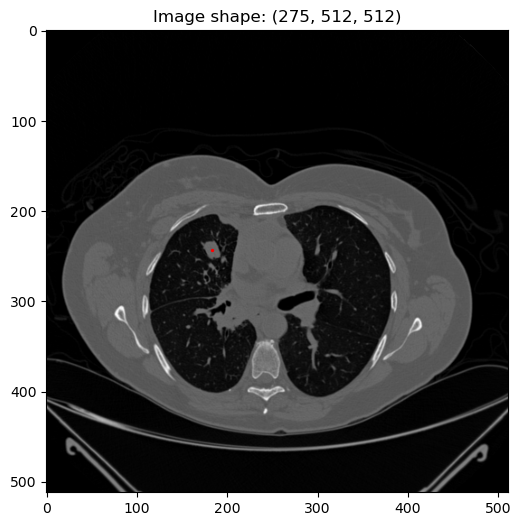

In [26]:
import matplotlib.pyplot as plt
import nibabel as nib
import numpy as np

img_path = '../data/1546.nii.gz'

test_image_nib = nib.load(img_path)
test_image = np.transpose(test_image_nib.get_fdata(), (2, 1, 0))[:, -1::-1, -1::-1]

fig = plt.figure(figsize=(12, 6))
plt.imshow(test_image[159], cmap='gray')
plt.scatter([183], [243], s=2, c='red')
plt.title(f'Image shape: {test_image.shape}')
plt.show()

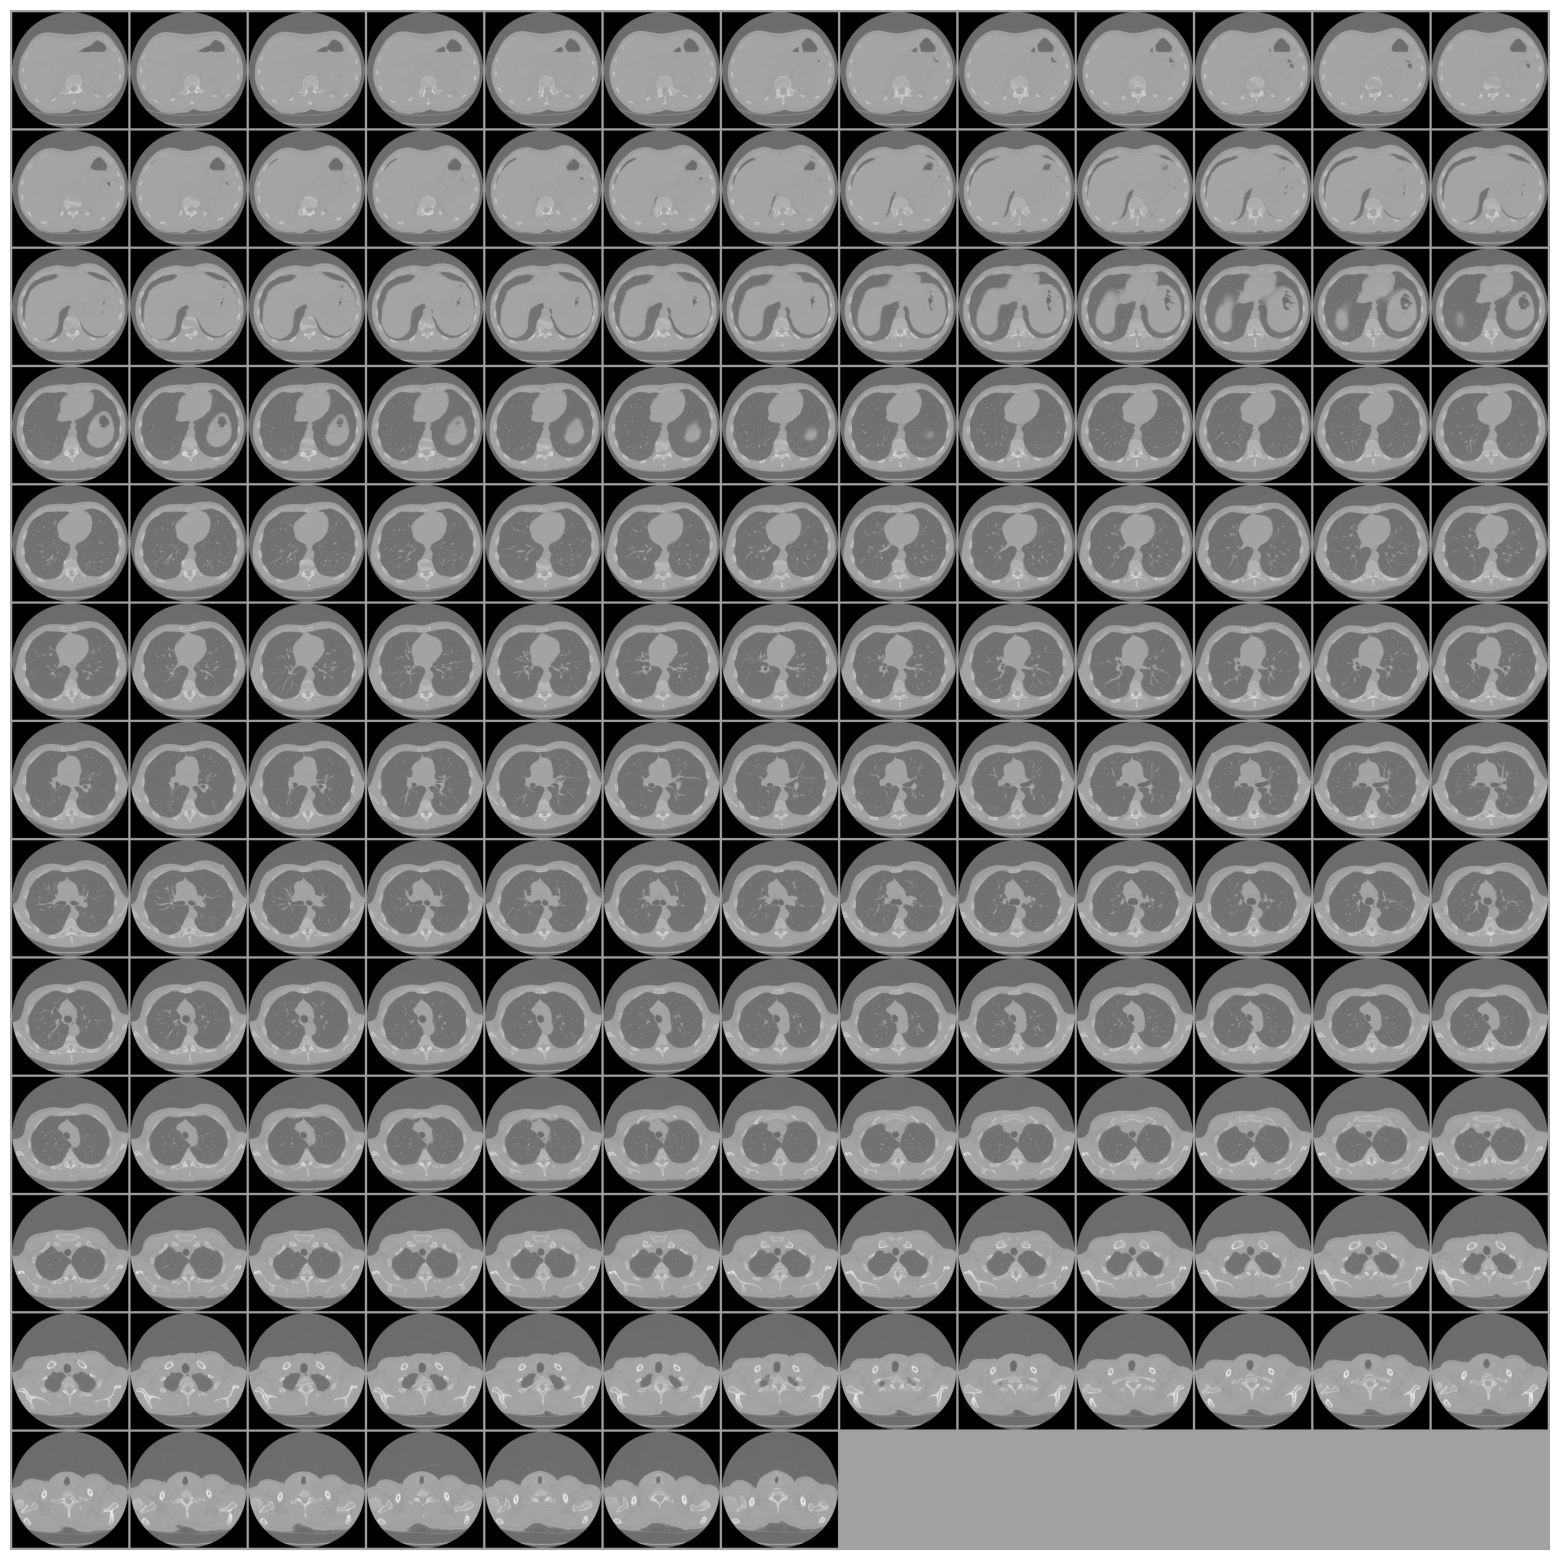

In [13]:
from skimage.util import montage

fig, ax1 = plt.subplots(1, 1, figsize=(20, 20))
ax1.imshow(montage(test_image, padding_width=10, fill=1), cmap='gray')
plt.axis('off')
plt.show()

### Dataset

preparing jobs...
extracting and augmenting samples...
Working on job: /home/natitov/hack_lct/leonid/CT-GAN/data/unhealthy_scans/1546   vox coord (zyx):  [159 243 183]
Working on job: /home/natitov/hack_lct/leonid/CT-GAN/data/unhealthy_scans/1045   vox coord (zyx):  [103 258 117]
Working on job: /home/natitov/hack_lct/leonid/CT-GAN/data/unhealthy_scans/2244   vox coord (zyx):  [ 65 360 294]
Working on job: /home/natitov/hack_lct/leonid/CT-GAN/data/unhealthy_scans/2244   vox coord (zyx):  [ 66 315  67]
Working on job: /home/natitov/hack_lct/leonid/CT-GAN/data/unhealthy_scans/2244   vox coord (zyx):  [ 97 403 192]
Working on job: /home/natitov/hack_lct/leonid/CT-GAN/data/unhealthy_scans/2244   vox coord (zyx):  [108 380 102]
Working on job: /home/natitov/hack_lct/leonid/CT-GAN/data/unhealthy_scans/6031   vox coord (zyx):  [ 51 315 119]
Working on job: /home/natitov/hack_lct/leonid/CT-GAN/data/unhealthy_scans/6031   vox coord (zyx):  [ 64 290 240]
Working on job: /home/natitov/hack_lct/le

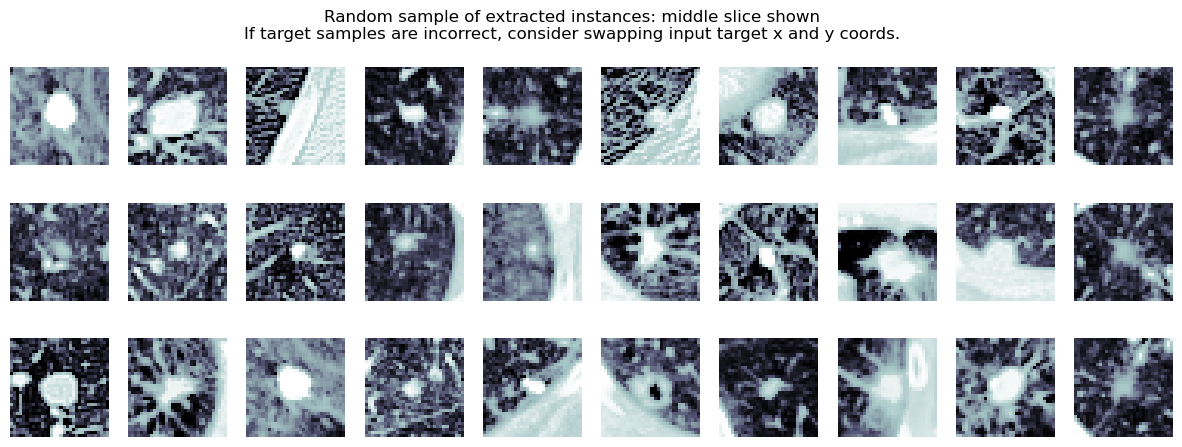

saving the dataset


In [21]:
from procedures.datasetBuilder import Extractor

builder = Extractor(is_healthy_dataset=False, parallelize=False)
builder.extract()

## Model

### Training

In [22]:
from procedures.trainer import Trainer

CTGAN_inj = Trainer(isInjector = False)
CTGAN_inj.train(epochs=200, batch_size=32, sample_interval=50)

2022-11-05 01:45:50.709693: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1512] Adding visible gpu devices: 0
2022-11-05 01:45:50.709752: I tensorflow/core/common_runtime/gpu/gpu_device.cc:984] Device interconnect StreamExecutor with strength 1 edge matrix:
2022-11-05 01:45:50.709761: I tensorflow/core/common_runtime/gpu/gpu_device.cc:990]      0 
2022-11-05 01:45:50.709767: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1003] 0:   N 
2022-11-05 01:45:50.709899: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1115] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 30588 MB memory) -> physical GPU (device: 0, name: Tesla V100-PCIE-32GB, pci bus id: 0000:8b:00.0, compute capability: 7.0)


loading preprocessed dataset...
Instructions for updating:
Colocations handled automatically by placer.
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 32, 1 0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 32, 32, 32, 1 0                                            
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, 32, 32, 32, 2 0           input_1[0][0]                    
                                                                 input_2[0][0]                    
_______________________________________________________________________________________

  0%|          | 0/200 [00:00<?, ?it/s]

0it [00:00, ?it/s]

2022-11-05 01:46:00.787994: E tensorflow/core/grappler/optimizers/dependency_optimizer.cc:704] Iteration = 0, topological sort failed with message: The graph couldn't be sorted in topological order.
2022-11-05 01:46:00.790598: E tensorflow/core/grappler/optimizers/dependency_optimizer.cc:704] Iteration = 1, topological sort failed with message: The graph couldn't be sorted in topological order.
2022-11-05 01:46:00.820003: E tensorflow/core/grappler/optimizers/dependency_optimizer.cc:704] Iteration = 0, topological sort failed with message: The graph couldn't be sorted in topological order.
2022-11-05 01:46:00.822286: E tensorflow/core/grappler/optimizers/dependency_optimizer.cc:704] Iteration = 1, topological sort failed with message: The graph couldn't be sorted in topological order.


Instructions for updating:
Use tf.cast instead.
[Epoch 0/200] [Batch 0/43] [D loss: 0.743221, acc:  43%] [G loss: 53.773438] time: 0:00:35.569388
[Epoch 0/200] [Batch 1/43] [D loss: 0.624845, acc:  45%] [G loss: 62.148327] time: 0:00:37.404244
[Epoch 0/200] [Batch 2/43] [D loss: 0.598613, acc:  45%] [G loss: 46.176174] time: 0:00:38.457523
[Epoch 0/200] [Batch 3/43] [D loss: 0.495528, acc:  53%] [G loss: 40.326408] time: 0:00:39.518834
[Epoch 0/200] [Batch 4/43] [D loss: 0.472134, acc:  50%] [G loss: 31.060345] time: 0:00:40.565290
[Epoch 0/200] [Batch 5/43] [D loss: 0.397896, acc:  55%] [G loss: 28.894333] time: 0:00:41.632473
[Epoch 0/200] [Batch 6/43] [D loss: 0.364729, acc:  55%] [G loss: 22.316856] time: 0:00:42.685016
[Epoch 0/200] [Batch 7/43] [D loss: 0.313160, acc:  61%] [G loss: 19.345774] time: 0:00:43.753976
[Epoch 0/200] [Batch 8/43] [D loss: 0.341400, acc:  57%] [G loss: 25.545681] time: 0:00:44.799314
[Epoch 0/200] [Batch 9/43] [D loss: 0.286932, acc:  62%] [G loss: 21.7

0it [00:00, ?it/s]

[Epoch 1/200] [Batch 0/43] [D loss: 0.186334, acc:  72%] [G loss: 9.610813] time: 0:01:25.098934
[Epoch 1/200] [Batch 1/43] [D loss: 0.227336, acc:  65%] [G loss: 8.780621] time: 0:01:26.491947
[Epoch 1/200] [Batch 2/43] [D loss: 0.226754, acc:  65%] [G loss: 9.506457] time: 0:01:27.541686
[Epoch 1/200] [Batch 3/43] [D loss: 0.262185, acc:  59%] [G loss: 10.212909] time: 0:01:28.600320
[Epoch 1/200] [Batch 4/43] [D loss: 0.199536, acc:  73%] [G loss: 8.725226] time: 0:01:29.650939
[Epoch 1/200] [Batch 5/43] [D loss: 0.188100, acc:  72%] [G loss: 9.782982] time: 0:01:30.698849
[Epoch 1/200] [Batch 6/43] [D loss: 0.261076, acc:  58%] [G loss: 9.995776] time: 0:01:31.768094
[Epoch 1/200] [Batch 7/43] [D loss: 0.187874, acc:  73%] [G loss: 9.072487] time: 0:01:32.833269
[Epoch 1/200] [Batch 8/43] [D loss: 0.222177, acc:  65%] [G loss: 9.059361] time: 0:01:33.887537
[Epoch 1/200] [Batch 9/43] [D loss: 0.213441, acc:  70%] [G loss: 8.422582] time: 0:01:34.938442
[Epoch 1/200] [Batch 10/43] [

0it [00:00, ?it/s]

[Epoch 2/200] [Batch 0/43] [D loss: 0.154797, acc:  79%] [G loss: 8.307064] time: 0:02:12.864494
[Epoch 2/200] [Batch 1/43] [D loss: 0.147835, acc:  81%] [G loss: 8.579842] time: 0:02:14.237630
[Epoch 2/200] [Batch 2/43] [D loss: 0.182534, acc:  74%] [G loss: 8.492577] time: 0:02:15.288418
[Epoch 2/200] [Batch 3/43] [D loss: 0.169773, acc:  75%] [G loss: 8.695378] time: 0:02:16.338055
[Epoch 2/200] [Batch 4/43] [D loss: 0.141457, acc:  82%] [G loss: 8.082993] time: 0:02:17.384240
[Epoch 2/200] [Batch 5/43] [D loss: 0.138371, acc:  83%] [G loss: 8.973663] time: 0:02:18.430308
[Epoch 2/200] [Batch 6/43] [D loss: 0.173059, acc:  75%] [G loss: 8.157608] time: 0:02:19.483272
[Epoch 2/200] [Batch 7/43] [D loss: 0.138451, acc:  82%] [G loss: 7.984899] time: 0:02:20.543183
[Epoch 2/200] [Batch 8/43] [D loss: 0.145374, acc:  85%] [G loss: 8.740191] time: 0:02:21.587311
[Epoch 2/200] [Batch 9/43] [D loss: 0.173355, acc:  76%] [G loss: 8.605680] time: 0:02:22.636322
[Epoch 2/200] [Batch 10/43] [D

0it [00:00, ?it/s]

[Epoch 3/200] [Batch 0/43] [D loss: 0.155716, acc:  82%] [G loss: 7.749600] time: 0:03:00.509891
[Epoch 3/200] [Batch 1/43] [D loss: 0.148050, acc:  83%] [G loss: 7.768215] time: 0:03:01.890714
[Epoch 3/200] [Batch 2/43] [D loss: 0.170762, acc:  77%] [G loss: 7.736994] time: 0:03:02.935302
[Epoch 3/200] [Batch 3/43] [D loss: 0.127263, acc:  87%] [G loss: 7.776069] time: 0:03:03.986516
[Epoch 3/200] [Batch 4/43] [D loss: 0.148172, acc:  82%] [G loss: 7.754220] time: 0:03:05.037613
[Epoch 3/200] [Batch 5/43] [D loss: 0.113244, acc:  89%] [G loss: 8.188071] time: 0:03:06.083774
[Epoch 3/200] [Batch 6/43] [D loss: 0.148670, acc:  81%] [G loss: 7.535783] time: 0:03:07.141766
[Epoch 3/200] [Batch 7/43] [D loss: 0.128743, acc:  87%] [G loss: 7.592569] time: 0:03:08.194344
[Epoch 3/200] [Batch 8/43] [D loss: 0.113566, acc:  89%] [G loss: 8.417222] time: 0:03:09.240854
[Epoch 3/200] [Batch 9/43] [D loss: 0.137969, acc:  84%] [G loss: 7.721947] time: 0:03:10.295830
[Epoch 3/200] [Batch 10/43] [D

0it [00:00, ?it/s]

[Epoch 4/200] [Batch 0/43] [D loss: 0.122414, acc:  86%] [G loss: 7.183875] time: 0:03:48.249343
[Epoch 4/200] [Batch 1/43] [D loss: 0.145288, acc:  83%] [G loss: 7.183468] time: 0:03:49.643460
[Epoch 4/200] [Batch 2/43] [D loss: 0.151133, acc:  81%] [G loss: 7.819984] time: 0:03:50.690187
[Epoch 4/200] [Batch 3/43] [D loss: 0.087606, acc:  92%] [G loss: 8.211567] time: 0:03:51.740497
[Epoch 4/200] [Batch 4/43] [D loss: 0.134231, acc:  86%] [G loss: 7.550896] time: 0:03:52.799977
[Epoch 4/200] [Batch 5/43] [D loss: 0.132131, acc:  85%] [G loss: 7.632057] time: 0:03:53.842949
[Epoch 4/200] [Batch 6/43] [D loss: 0.136428, acc:  85%] [G loss: 7.129610] time: 0:03:54.891378
[Epoch 4/200] [Batch 7/43] [D loss: 0.129772, acc:  88%] [G loss: 7.235285] time: 0:03:55.942940
[Epoch 4/200] [Batch 8/43] [D loss: 0.123839, acc:  88%] [G loss: 7.456287] time: 0:03:57.007471
[Epoch 4/200] [Batch 9/43] [D loss: 0.109127, acc:  90%] [G loss: 7.033016] time: 0:03:58.052517
[Epoch 4/200] [Batch 10/43] [D

0it [00:00, ?it/s]

[Epoch 5/200] [Batch 0/43] [D loss: 0.157058, acc:  82%] [G loss: 7.836462] time: 0:04:35.921121
[Epoch 5/200] [Batch 1/43] [D loss: 0.130837, acc:  86%] [G loss: 7.543925] time: 0:04:37.324663
[Epoch 5/200] [Batch 2/43] [D loss: 0.164393, acc:  77%] [G loss: 7.174539] time: 0:04:38.369506
[Epoch 5/200] [Batch 3/43] [D loss: 0.132880, acc:  86%] [G loss: 8.012982] time: 0:04:39.430380
[Epoch 5/200] [Batch 4/43] [D loss: 0.126326, acc:  86%] [G loss: 6.973412] time: 0:04:40.508909
[Epoch 5/200] [Batch 5/43] [D loss: 0.140346, acc:  85%] [G loss: 7.563778] time: 0:04:41.552361
[Epoch 5/200] [Batch 6/43] [D loss: 0.113142, acc:  90%] [G loss: 7.155395] time: 0:04:42.600409
[Epoch 5/200] [Batch 7/43] [D loss: 0.145007, acc:  83%] [G loss: 6.956348] time: 0:04:43.655494
[Epoch 5/200] [Batch 8/43] [D loss: 0.161815, acc:  80%] [G loss: 7.783400] time: 0:04:44.702754
[Epoch 5/200] [Batch 9/43] [D loss: 0.133446, acc:  87%] [G loss: 7.610844] time: 0:04:45.756507
[Epoch 5/200] [Batch 10/43] [D

0it [00:00, ?it/s]

[Epoch 6/200] [Batch 0/43] [D loss: 0.109036, acc:  89%] [G loss: 11.358341] time: 0:05:23.661811
[Epoch 6/200] [Batch 1/43] [D loss: 0.101648, acc:  91%] [G loss: 10.737770] time: 0:05:25.318696
[Epoch 6/200] [Batch 2/43] [D loss: 0.075526, acc:  94%] [G loss: 10.040802] time: 0:05:26.365856
[Epoch 6/200] [Batch 3/43] [D loss: 0.055643, acc:  97%] [G loss: 9.726715] time: 0:05:27.414519
[Epoch 6/200] [Batch 4/43] [D loss: 0.051624, acc:  97%] [G loss: 8.798196] time: 0:05:28.461164
[Epoch 6/200] [Batch 5/43] [D loss: 0.037042, acc:  97%] [G loss: 9.193601] time: 0:05:29.523132
[Epoch 6/200] [Batch 6/43] [D loss: 0.036678, acc:  98%] [G loss: 8.178024] time: 0:05:30.583605
[Epoch 6/200] [Batch 7/43] [D loss: 0.031327, acc:  99%] [G loss: 7.856264] time: 0:05:31.639359
[Epoch 6/200] [Batch 8/43] [D loss: 0.038711, acc:  98%] [G loss: 8.257681] time: 0:05:32.713346
[Epoch 6/200] [Batch 9/43] [D loss: 0.035626, acc:  98%] [G loss: 8.243845] time: 0:05:33.757149
[Epoch 6/200] [Batch 10/43]

0it [00:00, ?it/s]

[Epoch 7/200] [Batch 0/43] [D loss: 0.081695, acc:  94%] [G loss: 6.600644] time: 0:06:11.801408
[Epoch 7/200] [Batch 1/43] [D loss: 0.102389, acc:  94%] [G loss: 6.638566] time: 0:06:13.200291
[Epoch 7/200] [Batch 2/43] [D loss: 0.128310, acc:  87%] [G loss: 7.257617] time: 0:06:14.252010
[Epoch 7/200] [Batch 3/43] [D loss: 0.061429, acc:  97%] [G loss: 7.492013] time: 0:06:15.313093
[Epoch 7/200] [Batch 4/43] [D loss: 0.115560, acc:  90%] [G loss: 6.415052] time: 0:06:16.370586
[Epoch 7/200] [Batch 5/43] [D loss: 0.083500, acc:  94%] [G loss: 7.044979] time: 0:06:17.421297
[Epoch 7/200] [Batch 6/43] [D loss: 0.091189, acc:  95%] [G loss: 6.904586] time: 0:06:18.470251
[Epoch 7/200] [Batch 7/43] [D loss: 0.069650, acc:  97%] [G loss: 7.650050] time: 0:06:19.528879
[Epoch 7/200] [Batch 8/43] [D loss: 0.126158, acc:  85%] [G loss: 7.050667] time: 0:06:20.575385
[Epoch 7/200] [Batch 9/43] [D loss: 0.152303, acc:  81%] [G loss: 7.773936] time: 0:06:21.625731
[Epoch 7/200] [Batch 10/43] [D

0it [00:00, ?it/s]

[Epoch 8/200] [Batch 0/43] [D loss: 0.117194, acc:  90%] [G loss: 6.570231] time: 0:06:59.572061
[Epoch 8/200] [Batch 1/43] [D loss: 0.097846, acc:  93%] [G loss: 7.509249] time: 0:07:00.949606
[Epoch 8/200] [Batch 2/43] [D loss: 0.102501, acc:  91%] [G loss: 7.170396] time: 0:07:02.005256
[Epoch 8/200] [Batch 3/43] [D loss: 0.110895, acc:  92%] [G loss: 7.243416] time: 0:07:03.057817
[Epoch 8/200] [Batch 4/43] [D loss: 0.149214, acc:  85%] [G loss: 6.220415] time: 0:07:04.110797
[Epoch 8/200] [Batch 5/43] [D loss: 0.101772, acc:  92%] [G loss: 6.652101] time: 0:07:05.156816
[Epoch 8/200] [Batch 6/43] [D loss: 0.102676, acc:  92%] [G loss: 6.491084] time: 0:07:06.215734
[Epoch 8/200] [Batch 7/43] [D loss: 0.100377, acc:  94%] [G loss: 7.174103] time: 0:07:07.271229
[Epoch 8/200] [Batch 8/43] [D loss: 0.061420, acc:  96%] [G loss: 7.443416] time: 0:07:08.324586
[Epoch 8/200] [Batch 9/43] [D loss: 0.105320, acc:  91%] [G loss: 6.398329] time: 0:07:09.372244
[Epoch 8/200] [Batch 10/43] [D

0it [00:00, ?it/s]

[Epoch 9/200] [Batch 0/43] [D loss: 0.112379, acc:  90%] [G loss: 6.303183] time: 0:07:47.329212
[Epoch 9/200] [Batch 1/43] [D loss: 0.091149, acc:  94%] [G loss: 6.105872] time: 0:07:48.711814
[Epoch 9/200] [Batch 2/43] [D loss: 0.099464, acc:  94%] [G loss: 7.164704] time: 0:07:49.771792
[Epoch 9/200] [Batch 3/43] [D loss: 0.071138, acc:  97%] [G loss: 6.826684] time: 0:07:50.823536
[Epoch 9/200] [Batch 4/43] [D loss: 0.149030, acc:  86%] [G loss: 6.363828] time: 0:07:51.879401
[Epoch 9/200] [Batch 5/43] [D loss: 0.056689, acc:  97%] [G loss: 7.244742] time: 0:07:52.925889
[Epoch 9/200] [Batch 6/43] [D loss: 0.112311, acc:  89%] [G loss: 6.404195] time: 0:07:53.982513
[Epoch 9/200] [Batch 7/43] [D loss: 0.093475, acc:  95%] [G loss: 6.780133] time: 0:07:55.029168
[Epoch 9/200] [Batch 8/43] [D loss: 0.104755, acc:  93%] [G loss: 6.699471] time: 0:07:56.103183
[Epoch 9/200] [Batch 9/43] [D loss: 0.101840, acc:  93%] [G loss: 6.133845] time: 0:07:57.164745
[Epoch 9/200] [Batch 10/43] [D

0it [00:00, ?it/s]

[Epoch 10/200] [Batch 0/43] [D loss: 0.080322, acc:  97%] [G loss: 6.183451] time: 0:08:35.143475
[Epoch 10/200] [Batch 1/43] [D loss: 0.086620, acc:  97%] [G loss: 6.210276] time: 0:08:36.543503
[Epoch 10/200] [Batch 2/43] [D loss: 0.083646, acc:  95%] [G loss: 6.187283] time: 0:08:37.589412
[Epoch 10/200] [Batch 3/43] [D loss: 0.119154, acc:  90%] [G loss: 7.392509] time: 0:08:38.645259
[Epoch 10/200] [Batch 4/43] [D loss: 0.075699, acc:  95%] [G loss: 6.341710] time: 0:08:39.700009
[Epoch 10/200] [Batch 5/43] [D loss: 0.111377, acc:  89%] [G loss: 10.437460] time: 0:08:40.747370
[Epoch 10/200] [Batch 6/43] [D loss: 0.588955, acc:  56%] [G loss: 9.873007] time: 0:08:41.805070
[Epoch 10/200] [Batch 7/43] [D loss: 0.294867, acc:  68%] [G loss: 14.417603] time: 0:08:42.853134
[Epoch 10/200] [Batch 8/43] [D loss: 0.182853, acc:  78%] [G loss: 12.515039] time: 0:08:43.898023
[Epoch 10/200] [Batch 9/43] [D loss: 0.145907, acc:  81%] [G loss: 9.342863] time: 0:08:44.957664
[Epoch 10/200] [B

0it [00:00, ?it/s]

[Epoch 11/200] [Batch 0/43] [D loss: 0.044965, acc:  98%] [G loss: 6.280687] time: 0:09:22.910291
[Epoch 11/200] [Batch 1/43] [D loss: 0.056775, acc:  98%] [G loss: 6.690747] time: 0:09:24.317076
[Epoch 11/200] [Batch 2/43] [D loss: 0.075914, acc:  93%] [G loss: 6.333121] time: 0:09:25.373073
[Epoch 11/200] [Batch 3/43] [D loss: 0.037800, acc:  99%] [G loss: 7.200413] time: 0:09:26.423134
[Epoch 11/200] [Batch 4/43] [D loss: 0.045769, acc:  99%] [G loss: 6.454013] time: 0:09:27.478197
[Epoch 11/200] [Batch 5/43] [D loss: 0.051416, acc:  97%] [G loss: 6.319767] time: 0:09:28.526184
[Epoch 11/200] [Batch 6/43] [D loss: 0.054092, acc:  97%] [G loss: 6.346334] time: 0:09:29.577867
[Epoch 11/200] [Batch 7/43] [D loss: 0.038578, acc:  99%] [G loss: 6.880926] time: 0:09:30.638698
[Epoch 11/200] [Batch 8/43] [D loss: 0.045276, acc:  98%] [G loss: 6.427275] time: 0:09:31.704593
[Epoch 11/200] [Batch 9/43] [D loss: 0.083877, acc:  94%] [G loss: 6.161899] time: 0:09:32.751890
[Epoch 11/200] [Batc

0it [00:00, ?it/s]

[Epoch 12/200] [Batch 0/43] [D loss: 0.072474, acc:  97%] [G loss: 5.972169] time: 0:10:10.699356
[Epoch 12/200] [Batch 1/43] [D loss: 0.087131, acc:  96%] [G loss: 6.359953] time: 0:10:12.078951
[Epoch 12/200] [Batch 2/43] [D loss: 0.090657, acc:  94%] [G loss: 6.111975] time: 0:10:13.125420
[Epoch 12/200] [Batch 3/43] [D loss: 0.056793, acc:  97%] [G loss: 7.089989] time: 0:10:14.186361
[Epoch 12/200] [Batch 4/43] [D loss: 0.063860, acc:  98%] [G loss: 6.134470] time: 0:10:15.239407
[Epoch 12/200] [Batch 5/43] [D loss: 0.051133, acc:  98%] [G loss: 6.155272] time: 0:10:16.287976
[Epoch 12/200] [Batch 6/43] [D loss: 0.057195, acc:  98%] [G loss: 5.938193] time: 0:10:17.362876
[Epoch 12/200] [Batch 7/43] [D loss: 0.055154, acc:  99%] [G loss: 6.451108] time: 0:10:18.414454
[Epoch 12/200] [Batch 8/43] [D loss: 0.062915, acc:  98%] [G loss: 6.638593] time: 0:10:19.465332
[Epoch 12/200] [Batch 9/43] [D loss: 0.055628, acc:  99%] [G loss: 6.561837] time: 0:10:20.514086
[Epoch 12/200] [Batc

0it [00:00, ?it/s]

[Epoch 13/200] [Batch 0/43] [D loss: 0.053513, acc:  98%] [G loss: 6.291461] time: 0:10:58.480661
[Epoch 13/200] [Batch 1/43] [D loss: 0.110114, acc:  92%] [G loss: 5.722180] time: 0:10:59.892163
[Epoch 13/200] [Batch 2/43] [D loss: 0.188357, acc:  69%] [G loss: 6.839662] time: 0:11:00.942158
[Epoch 13/200] [Batch 3/43] [D loss: 0.056872, acc:  98%] [G loss: 6.319755] time: 0:11:01.995761
[Epoch 13/200] [Batch 4/43] [D loss: 0.100662, acc:  94%] [G loss: 5.802819] time: 0:11:03.042986
[Epoch 13/200] [Batch 5/43] [D loss: 0.072335, acc:  96%] [G loss: 6.208650] time: 0:11:04.089073
[Epoch 13/200] [Batch 6/43] [D loss: 0.103953, acc:  92%] [G loss: 5.906466] time: 0:11:05.151082
[Epoch 13/200] [Batch 7/43] [D loss: 0.082345, acc:  99%] [G loss: 5.960547] time: 0:11:06.203244
[Epoch 13/200] [Batch 8/43] [D loss: 0.053038, acc:  98%] [G loss: 6.182372] time: 0:11:07.292810
[Epoch 13/200] [Batch 9/43] [D loss: 0.082425, acc:  96%] [G loss: 6.215577] time: 0:11:08.356458
[Epoch 13/200] [Batc

0it [00:00, ?it/s]

[Epoch 14/200] [Batch 0/43] [D loss: 0.090136, acc:  95%] [G loss: 5.720012] time: 0:11:46.282649
[Epoch 14/200] [Batch 1/43] [D loss: 0.096150, acc:  97%] [G loss: 5.604795] time: 0:11:47.676159
[Epoch 14/200] [Batch 2/43] [D loss: 0.117374, acc:  88%] [G loss: 6.198751] time: 0:11:48.724826
[Epoch 14/200] [Batch 3/43] [D loss: 0.046675, acc:  99%] [G loss: 6.098997] time: 0:11:49.779605
[Epoch 14/200] [Batch 4/43] [D loss: 0.091284, acc:  96%] [G loss: 5.463323] time: 0:11:50.841695
[Epoch 14/200] [Batch 5/43] [D loss: 0.061203, acc:  97%] [G loss: 5.926959] time: 0:11:51.886610
[Epoch 14/200] [Batch 6/43] [D loss: 0.103993, acc:  94%] [G loss: 6.227851] time: 0:11:52.952569
[Epoch 14/200] [Batch 7/43] [D loss: 0.057225, acc:  99%] [G loss: 6.092806] time: 0:11:54.003266
[Epoch 14/200] [Batch 8/43] [D loss: 0.049269, acc:  98%] [G loss: 6.135975] time: 0:11:55.054218
[Epoch 14/200] [Batch 9/43] [D loss: 0.132214, acc:  89%] [G loss: 6.059095] time: 0:11:56.121788
[Epoch 14/200] [Batc

0it [00:00, ?it/s]

[Epoch 15/200] [Batch 0/43] [D loss: 0.063910, acc:  97%] [G loss: 6.014127] time: 0:12:34.093581
[Epoch 15/200] [Batch 1/43] [D loss: 0.112559, acc:  95%] [G loss: 6.157159] time: 0:12:35.491634
[Epoch 15/200] [Batch 2/43] [D loss: 0.110115, acc:  90%] [G loss: 5.941292] time: 0:12:36.543012
[Epoch 15/200] [Batch 3/43] [D loss: 0.040658, acc:  98%] [G loss: 6.241013] time: 0:12:37.612925
[Epoch 15/200] [Batch 4/43] [D loss: 0.085811, acc:  97%] [G loss: 5.858263] time: 0:12:38.663503
[Epoch 15/200] [Batch 5/43] [D loss: 0.095099, acc:  91%] [G loss: 5.840243] time: 0:12:39.709588
[Epoch 15/200] [Batch 6/43] [D loss: 0.094585, acc:  93%] [G loss: 6.122988] time: 0:12:40.765120
[Epoch 15/200] [Batch 7/43] [D loss: 0.058644, acc:  99%] [G loss: 5.898653] time: 0:12:41.814761
[Epoch 15/200] [Batch 8/43] [D loss: 0.052440, acc:  99%] [G loss: 6.723919] time: 0:12:42.865504
[Epoch 15/200] [Batch 9/43] [D loss: 0.084370, acc:  97%] [G loss: 5.967103] time: 0:12:43.916855
[Epoch 15/200] [Batc

0it [00:00, ?it/s]

[Epoch 16/200] [Batch 0/43] [D loss: 0.088142, acc:  97%] [G loss: 5.864021] time: 0:13:21.951656
[Epoch 16/200] [Batch 1/43] [D loss: 0.065657, acc:  98%] [G loss: 6.327095] time: 0:13:23.381059
[Epoch 16/200] [Batch 2/43] [D loss: 0.106714, acc:  91%] [G loss: 5.918856] time: 0:13:24.429280
[Epoch 16/200] [Batch 3/43] [D loss: 0.088401, acc:  91%] [G loss: 7.169085] time: 0:13:25.474751
[Epoch 16/200] [Batch 4/43] [D loss: 0.092482, acc:  97%] [G loss: 5.482460] time: 0:13:26.529156
[Epoch 16/200] [Batch 5/43] [D loss: 0.105728, acc:  89%] [G loss: 6.997789] time: 0:13:27.585018
[Epoch 16/200] [Batch 6/43] [D loss: 0.057041, acc:  98%] [G loss: 5.988948] time: 0:13:28.637899
[Epoch 16/200] [Batch 7/43] [D loss: 0.053906, acc:  99%] [G loss: 6.607979] time: 0:13:29.687656
[Epoch 16/200] [Batch 8/43] [D loss: 0.076264, acc:  95%] [G loss: 6.001089] time: 0:13:30.734721
[Epoch 16/200] [Batch 9/43] [D loss: 0.094946, acc:  95%] [G loss: 6.247814] time: 0:13:31.797548
[Epoch 16/200] [Batc

0it [00:00, ?it/s]

[Epoch 17/200] [Batch 0/43] [D loss: 0.053137, acc:  99%] [G loss: 6.105596] time: 0:14:09.786376
[Epoch 17/200] [Batch 1/43] [D loss: 0.101267, acc:  94%] [G loss: 5.586580] time: 0:14:11.188249
[Epoch 17/200] [Batch 2/43] [D loss: 0.135726, acc:  83%] [G loss: 6.125040] time: 0:14:12.236530
[Epoch 17/200] [Batch 3/43] [D loss: 0.119362, acc:  85%] [G loss: 6.021718] time: 0:14:13.286317
[Epoch 17/200] [Batch 4/43] [D loss: 0.101678, acc:  95%] [G loss: 6.240153] time: 0:14:14.338198
[Epoch 17/200] [Batch 5/43] [D loss: 0.054357, acc:  98%] [G loss: 6.098706] time: 0:14:15.386448
[Epoch 17/200] [Batch 6/43] [D loss: 0.084226, acc:  96%] [G loss: 6.043150] time: 0:14:16.432966
[Epoch 17/200] [Batch 7/43] [D loss: 0.079744, acc:  97%] [G loss: 5.825158] time: 0:14:17.477290
[Epoch 17/200] [Batch 8/43] [D loss: 0.099462, acc:  91%] [G loss: 5.944100] time: 0:14:18.543212
[Epoch 17/200] [Batch 9/43] [D loss: 0.088010, acc:  98%] [G loss: 6.135126] time: 0:14:19.628971
[Epoch 17/200] [Batc

0it [00:00, ?it/s]

[Epoch 18/200] [Batch 0/43] [D loss: 0.101337, acc:  96%] [G loss: 5.400842] time: 0:14:57.677912
[Epoch 18/200] [Batch 1/43] [D loss: 0.079314, acc:  96%] [G loss: 5.386314] time: 0:14:59.114993
[Epoch 18/200] [Batch 2/43] [D loss: 0.151252, acc:  79%] [G loss: 5.662347] time: 0:15:00.160936
[Epoch 18/200] [Batch 3/43] [D loss: 0.142211, acc:  79%] [G loss: 5.779787] time: 0:15:01.206473
[Epoch 18/200] [Batch 4/43] [D loss: 0.080520, acc:  96%] [G loss: 5.436740] time: 0:15:02.258075
[Epoch 18/200] [Batch 5/43] [D loss: 0.078494, acc:  96%] [G loss: 6.084369] time: 0:15:03.303631
[Epoch 18/200] [Batch 6/43] [D loss: 0.081080, acc:  97%] [G loss: 5.452091] time: 0:15:04.357721
[Epoch 18/200] [Batch 7/43] [D loss: 0.061233, acc:  99%] [G loss: 5.599032] time: 0:15:05.426206
[Epoch 18/200] [Batch 8/43] [D loss: 0.064957, acc:  98%] [G loss: 6.181515] time: 0:15:06.475483
[Epoch 18/200] [Batch 9/43] [D loss: 0.147047, acc:  86%] [G loss: 5.855516] time: 0:15:07.524022
[Epoch 18/200] [Batc

0it [00:00, ?it/s]

[Epoch 19/200] [Batch 0/43] [D loss: 0.066647, acc:  99%] [G loss: 5.274534] time: 0:15:45.446197
[Epoch 19/200] [Batch 1/43] [D loss: 0.069778, acc:  98%] [G loss: 5.538529] time: 0:15:47.209613
[Epoch 19/200] [Batch 2/43] [D loss: 0.114114, acc:  88%] [G loss: 5.751167] time: 0:15:48.254580
[Epoch 19/200] [Batch 3/43] [D loss: 0.078196, acc:  96%] [G loss: 5.722797] time: 0:15:49.314125
[Epoch 19/200] [Batch 4/43] [D loss: 0.056106, acc:  98%] [G loss: 6.036132] time: 0:15:50.377607
[Epoch 19/200] [Batch 5/43] [D loss: 0.158830, acc:  73%] [G loss: 5.765319] time: 0:15:51.419792
[Epoch 19/200] [Batch 6/43] [D loss: 0.175050, acc:  72%] [G loss: 6.447575] time: 0:15:52.469417
[Epoch 19/200] [Batch 7/43] [D loss: 0.057333, acc:  99%] [G loss: 5.950659] time: 0:15:53.518377
[Epoch 19/200] [Batch 8/43] [D loss: 0.155661, acc:  77%] [G loss: 5.882979] time: 0:15:54.566008
[Epoch 19/200] [Batch 9/43] [D loss: 0.197459, acc:  74%] [G loss: 5.934739] time: 0:15:55.626353
[Epoch 19/200] [Batc

0it [00:00, ?it/s]

[Epoch 20/200] [Batch 0/43] [D loss: 0.104244, acc:  96%] [G loss: 5.853391] time: 0:16:33.556013
[Epoch 20/200] [Batch 1/43] [D loss: 0.072550, acc:  97%] [G loss: 5.907570] time: 0:16:34.957475
[Epoch 20/200] [Batch 2/43] [D loss: 0.071473, acc:  97%] [G loss: 5.829857] time: 0:16:36.004274
[Epoch 20/200] [Batch 3/43] [D loss: 0.080079, acc:  95%] [G loss: 6.641376] time: 0:16:37.071276
[Epoch 20/200] [Batch 4/43] [D loss: 0.086805, acc:  97%] [G loss: 5.204789] time: 0:16:38.125362
[Epoch 20/200] [Batch 5/43] [D loss: 0.079753, acc:  95%] [G loss: 6.499645] time: 0:16:39.172985
[Epoch 20/200] [Batch 6/43] [D loss: 0.048352, acc:  99%] [G loss: 5.787286] time: 0:16:40.233659
[Epoch 20/200] [Batch 7/43] [D loss: 0.066513, acc:  99%] [G loss: 5.932876] time: 0:16:41.293287
[Epoch 20/200] [Batch 8/43] [D loss: 0.135532, acc:  78%] [G loss: 5.940482] time: 0:16:42.338980
[Epoch 20/200] [Batch 9/43] [D loss: 0.068747, acc:  99%] [G loss: 5.602591] time: 0:16:43.414610
[Epoch 20/200] [Batc

0it [00:00, ?it/s]

[Epoch 21/200] [Batch 0/43] [D loss: 0.072565, acc:  99%] [G loss: 5.308014] time: 0:17:21.359608
[Epoch 21/200] [Batch 1/43] [D loss: 0.074261, acc:  98%] [G loss: 5.453236] time: 0:17:22.753410
[Epoch 21/200] [Batch 2/43] [D loss: 0.150144, acc:  76%] [G loss: 5.975114] time: 0:17:23.797857
[Epoch 21/200] [Batch 3/43] [D loss: 0.027587, acc:  99%] [G loss: 5.653061] time: 0:17:24.850033
[Epoch 21/200] [Batch 4/43] [D loss: 0.081685, acc:  97%] [G loss: 5.943748] time: 0:17:25.894956
[Epoch 21/200] [Batch 5/43] [D loss: 0.150639, acc:  73%] [G loss: 5.768324] time: 0:17:26.946001
[Epoch 21/200] [Batch 6/43] [D loss: 0.054002, acc:  99%] [G loss: 5.794435] time: 0:17:27.995996
[Epoch 21/200] [Batch 7/43] [D loss: 0.060186, acc:  99%] [G loss: 5.778282] time: 0:17:29.050999
[Epoch 21/200] [Batch 8/43] [D loss: 0.108990, acc:  91%] [G loss: 5.894791] time: 0:17:30.098627
[Epoch 21/200] [Batch 9/43] [D loss: 0.106073, acc:  94%] [G loss: 5.580742] time: 0:17:31.146376
[Epoch 21/200] [Batc

0it [00:00, ?it/s]

[Epoch 22/200] [Batch 0/43] [D loss: 0.074266, acc:  98%] [G loss: 5.666495] time: 0:18:09.047090
[Epoch 22/200] [Batch 1/43] [D loss: 0.115531, acc:  95%] [G loss: 6.029383] time: 0:18:10.469809
[Epoch 22/200] [Batch 2/43] [D loss: 0.126773, acc:  87%] [G loss: 5.533794] time: 0:18:11.516346
[Epoch 22/200] [Batch 3/43] [D loss: 0.163190, acc:  69%] [G loss: 6.349195] time: 0:18:12.586855
[Epoch 22/200] [Batch 4/43] [D loss: 0.111440, acc:  95%] [G loss: 5.132939] time: 0:18:13.647664
[Epoch 22/200] [Batch 5/43] [D loss: 0.129510, acc:  85%] [G loss: 5.749039] time: 0:18:14.694812
[Epoch 22/200] [Batch 6/43] [D loss: 0.062420, acc:  98%] [G loss: 5.694149] time: 0:18:15.760031
[Epoch 22/200] [Batch 7/43] [D loss: 0.083406, acc:  98%] [G loss: 5.579634] time: 0:18:16.818341
[Epoch 22/200] [Batch 8/43] [D loss: 0.069306, acc:  98%] [G loss: 5.625507] time: 0:18:17.863026
[Epoch 22/200] [Batch 9/43] [D loss: 0.068810, acc:  98%] [G loss: 5.345132] time: 0:18:18.905882
[Epoch 22/200] [Batc

0it [00:00, ?it/s]

[Epoch 23/200] [Batch 0/43] [D loss: 0.084834, acc:  97%] [G loss: 5.925665] time: 0:18:56.734908
[Epoch 23/200] [Batch 1/43] [D loss: 0.078370, acc:  98%] [G loss: 5.445179] time: 0:18:58.141079
[Epoch 23/200] [Batch 2/43] [D loss: 0.061637, acc:  98%] [G loss: 5.821260] time: 0:18:59.187430
[Epoch 23/200] [Batch 3/43] [D loss: 0.063522, acc:  98%] [G loss: 5.649181] time: 0:19:00.250682
[Epoch 23/200] [Batch 4/43] [D loss: 0.090216, acc:  98%] [G loss: 5.210683] time: 0:19:01.294077
[Epoch 23/200] [Batch 5/43] [D loss: 0.048625, acc:  99%] [G loss: 5.655673] time: 0:19:02.337365
[Epoch 23/200] [Batch 6/43] [D loss: 0.066546, acc:  99%] [G loss: 5.297391] time: 0:19:03.384956
[Epoch 23/200] [Batch 7/43] [D loss: 0.131718, acc:  84%] [G loss: 5.618939] time: 0:19:04.437058
[Epoch 23/200] [Batch 8/43] [D loss: 0.044464, acc:  99%] [G loss: 5.678092] time: 0:19:05.484026
[Epoch 23/200] [Batch 9/43] [D loss: 0.077992, acc:  97%] [G loss: 5.248855] time: 0:19:06.534240
[Epoch 23/200] [Batc

0it [00:00, ?it/s]

[Epoch 24/200] [Batch 0/43] [D loss: 0.104015, acc:  95%] [G loss: 5.260437] time: 0:19:44.479166
[Epoch 24/200] [Batch 1/43] [D loss: 0.070044, acc:  98%] [G loss: 5.256113] time: 0:19:45.888892
[Epoch 24/200] [Batch 2/43] [D loss: 0.048462, acc:  99%] [G loss: 5.758366] time: 0:19:46.933630
[Epoch 24/200] [Batch 3/43] [D loss: 0.134938, acc:  79%] [G loss: 5.810463] time: 0:19:48.011758
[Epoch 24/200] [Batch 4/43] [D loss: 0.095089, acc:  97%] [G loss: 5.169347] time: 0:19:49.060133
[Epoch 24/200] [Batch 5/43] [D loss: 0.067511, acc:  98%] [G loss: 5.438912] time: 0:19:50.106986
[Epoch 24/200] [Batch 6/43] [D loss: 0.106716, acc:  94%] [G loss: 5.406260] time: 0:19:51.159208
[Epoch 24/200] [Batch 7/43] [D loss: 0.095541, acc:  97%] [G loss: 5.752534] time: 0:19:52.205773
[Epoch 24/200] [Batch 8/43] [D loss: 0.086940, acc:  95%] [G loss: 5.965246] time: 0:19:53.252008
[Epoch 24/200] [Batch 9/43] [D loss: 0.168474, acc:  84%] [G loss: 5.502943] time: 0:19:54.319966
[Epoch 24/200] [Batc

0it [00:00, ?it/s]

[Epoch 25/200] [Batch 0/43] [D loss: 0.108785, acc:  95%] [G loss: 5.357502] time: 0:20:32.305528
[Epoch 25/200] [Batch 1/43] [D loss: 0.074505, acc:  99%] [G loss: 5.179839] time: 0:20:33.697931
[Epoch 25/200] [Batch 2/43] [D loss: 0.054545, acc:  99%] [G loss: 5.377290] time: 0:20:34.746484
[Epoch 25/200] [Batch 3/43] [D loss: 0.036434, acc:  99%] [G loss: 5.716982] time: 0:20:35.822675
[Epoch 25/200] [Batch 4/43] [D loss: 0.087759, acc:  98%] [G loss: 5.039015] time: 0:20:36.888684
[Epoch 25/200] [Batch 5/43] [D loss: 0.074862, acc:  97%] [G loss: 5.333576] time: 0:20:37.933519
[Epoch 25/200] [Batch 6/43] [D loss: 0.069515, acc:  98%] [G loss: 5.342669] time: 0:20:38.992020
[Epoch 25/200] [Batch 7/43] [D loss: 0.043955, acc: 100%] [G loss: 5.764062] time: 0:20:40.040837
[Epoch 25/200] [Batch 8/43] [D loss: 0.129419, acc:  82%] [G loss: 5.953469] time: 0:20:41.085125
[Epoch 25/200] [Batch 9/43] [D loss: 0.068352, acc:  98%] [G loss: 5.495015] time: 0:20:42.138016
[Epoch 25/200] [Batc

0it [00:00, ?it/s]

[Epoch 26/200] [Batch 0/43] [D loss: 0.097941, acc:  98%] [G loss: 5.136611] time: 0:21:20.059858
[Epoch 26/200] [Batch 1/43] [D loss: 0.087839, acc:  97%] [G loss: 5.074441] time: 0:21:21.443000
[Epoch 26/200] [Batch 2/43] [D loss: 0.073996, acc:  98%] [G loss: 5.348884] time: 0:21:22.490703
[Epoch 26/200] [Batch 3/43] [D loss: 0.055270, acc:  99%] [G loss: 5.346047] time: 0:21:23.540037
[Epoch 26/200] [Batch 4/43] [D loss: 0.132710, acc:  92%] [G loss: 4.963353] time: 0:21:24.587549
[Epoch 26/200] [Batch 5/43] [D loss: 0.083567, acc:  97%] [G loss: 5.301723] time: 0:21:25.653673
[Epoch 26/200] [Batch 6/43] [D loss: 0.068373, acc:  99%] [G loss: 5.151572] time: 0:21:26.701234
[Epoch 26/200] [Batch 7/43] [D loss: 0.059822, acc:  99%] [G loss: 5.440345] time: 0:21:27.745764
[Epoch 26/200] [Batch 8/43] [D loss: 0.062416, acc:  99%] [G loss: 5.689478] time: 0:21:28.793952
[Epoch 26/200] [Batch 9/43] [D loss: 0.127014, acc:  93%] [G loss: 5.251163] time: 0:21:29.843738
[Epoch 26/200] [Batc

0it [00:00, ?it/s]

[Epoch 27/200] [Batch 0/43] [D loss: 0.181832, acc:  71%] [G loss: 5.367379] time: 0:22:07.922794
[Epoch 27/200] [Batch 1/43] [D loss: 0.096011, acc:  97%] [G loss: 5.062356] time: 0:22:09.313359
[Epoch 27/200] [Batch 2/43] [D loss: 0.063999, acc:  99%] [G loss: 5.405176] time: 0:22:10.363801
[Epoch 27/200] [Batch 3/43] [D loss: 0.072586, acc:  98%] [G loss: 5.479445] time: 0:22:11.411104
[Epoch 27/200] [Batch 4/43] [D loss: 0.183636, acc:  75%] [G loss: 5.035971] time: 0:22:12.455990
[Epoch 27/200] [Batch 5/43] [D loss: 0.108378, acc:  91%] [G loss: 5.430727] time: 0:22:13.515032
[Epoch 27/200] [Batch 6/43] [D loss: 0.065138, acc:  99%] [G loss: 5.377825] time: 0:22:14.581070
[Epoch 27/200] [Batch 7/43] [D loss: 0.109303, acc:  95%] [G loss: 5.472284] time: 0:22:15.628565
[Epoch 27/200] [Batch 8/43] [D loss: 0.106201, acc:  93%] [G loss: 5.670535] time: 0:22:16.684770
[Epoch 27/200] [Batch 9/43] [D loss: 0.077464, acc:  97%] [G loss: 5.511031] time: 0:22:17.733613
[Epoch 27/200] [Batc

0it [00:00, ?it/s]

[Epoch 28/200] [Batch 0/43] [D loss: 0.090849, acc:  97%] [G loss: 5.163757] time: 0:22:55.817464
[Epoch 28/200] [Batch 1/43] [D loss: 0.089707, acc:  98%] [G loss: 5.115961] time: 0:22:57.202682
[Epoch 28/200] [Batch 2/43] [D loss: 0.064093, acc:  99%] [G loss: 5.796781] time: 0:22:58.251812
[Epoch 28/200] [Batch 3/43] [D loss: 0.031530, acc: 100%] [G loss: 5.498925] time: 0:22:59.305135
[Epoch 28/200] [Batch 4/43] [D loss: 0.119838, acc:  96%] [G loss: 5.296968] time: 0:23:00.350818
[Epoch 28/200] [Batch 5/43] [D loss: 0.107856, acc:  89%] [G loss: 5.661851] time: 0:23:01.398743
[Epoch 28/200] [Batch 6/43] [D loss: 0.040084, acc:  99%] [G loss: 5.580499] time: 0:23:02.456034
[Epoch 28/200] [Batch 7/43] [D loss: 0.138870, acc:  83%] [G loss: 5.985241] time: 0:23:03.502727
[Epoch 28/200] [Batch 8/43] [D loss: 0.077011, acc:  97%] [G loss: 5.878747] time: 0:23:04.569659
[Epoch 28/200] [Batch 9/43] [D loss: 0.061652, acc:  99%] [G loss: 5.295613] time: 0:23:05.619943
[Epoch 28/200] [Batc

0it [00:00, ?it/s]

[Epoch 29/200] [Batch 0/43] [D loss: 0.135730, acc:  90%] [G loss: 5.341371] time: 0:23:43.575322
[Epoch 29/200] [Batch 1/43] [D loss: 0.088251, acc:  98%] [G loss: 5.010073] time: 0:23:44.959120
[Epoch 29/200] [Batch 2/43] [D loss: 0.094092, acc:  97%] [G loss: 5.278153] time: 0:23:46.005783
[Epoch 29/200] [Batch 3/43] [D loss: 0.043940, acc:  99%] [G loss: 5.666491] time: 0:23:47.057783
[Epoch 29/200] [Batch 4/43] [D loss: 0.090539, acc:  98%] [G loss: 5.222445] time: 0:23:48.103922
[Epoch 29/200] [Batch 5/43] [D loss: 0.133912, acc:  82%] [G loss: 5.382092] time: 0:23:49.148458
[Epoch 29/200] [Batch 6/43] [D loss: 0.056488, acc:  99%] [G loss: 5.213106] time: 0:23:50.199737
[Epoch 29/200] [Batch 7/43] [D loss: 0.071243, acc:  99%] [G loss: 5.419294] time: 0:23:51.245554
[Epoch 29/200] [Batch 8/43] [D loss: 0.107309, acc:  92%] [G loss: 5.495352] time: 0:23:52.293774
[Epoch 29/200] [Batch 9/43] [D loss: 0.096232, acc:  97%] [G loss: 5.156997] time: 0:23:53.337509
[Epoch 29/200] [Batc

0it [00:00, ?it/s]

[Epoch 30/200] [Batch 0/43] [D loss: 0.200344, acc:  67%] [G loss: 5.287835] time: 0:24:31.289615
[Epoch 30/200] [Batch 1/43] [D loss: 0.091871, acc:  95%] [G loss: 5.485779] time: 0:24:32.695623
[Epoch 30/200] [Batch 2/43] [D loss: 0.112865, acc:  94%] [G loss: 5.418064] time: 0:24:33.742866
[Epoch 30/200] [Batch 3/43] [D loss: 0.088562, acc:  97%] [G loss: 5.484375] time: 0:24:34.794356
[Epoch 30/200] [Batch 4/43] [D loss: 0.091395, acc:  96%] [G loss: 5.698978] time: 0:24:35.841878
[Epoch 30/200] [Batch 5/43] [D loss: 0.083853, acc:  97%] [G loss: 5.738880] time: 0:24:36.890369
[Epoch 30/200] [Batch 6/43] [D loss: 0.106052, acc:  93%] [G loss: 5.787786] time: 0:24:37.933785
[Epoch 30/200] [Batch 7/43] [D loss: 0.051187, acc:  99%] [G loss: 5.382870] time: 0:24:38.988047
[Epoch 30/200] [Batch 8/43] [D loss: 0.047226, acc:  99%] [G loss: 5.794102] time: 0:24:40.033449
[Epoch 30/200] [Batch 9/43] [D loss: 0.147712, acc:  83%] [G loss: 5.279334] time: 0:24:41.105280
[Epoch 30/200] [Batc

0it [00:00, ?it/s]

[Epoch 31/200] [Batch 0/43] [D loss: 0.132195, acc:  92%] [G loss: 5.253769] time: 0:25:19.019608
[Epoch 31/200] [Batch 1/43] [D loss: 0.093074, acc:  98%] [G loss: 4.972476] time: 0:25:20.398440
[Epoch 31/200] [Batch 2/43] [D loss: 0.094276, acc:  98%] [G loss: 5.409879] time: 0:25:21.446257
[Epoch 31/200] [Batch 3/43] [D loss: 0.096107, acc:  94%] [G loss: 6.064964] time: 0:25:22.501087
[Epoch 31/200] [Batch 4/43] [D loss: 0.082239, acc:  98%] [G loss: 4.927865] time: 0:25:23.551292
[Epoch 31/200] [Batch 5/43] [D loss: 0.111756, acc:  93%] [G loss: 5.248072] time: 0:25:24.618918
[Epoch 31/200] [Batch 6/43] [D loss: 0.089900, acc:  98%] [G loss: 5.427833] time: 0:25:25.692211
[Epoch 31/200] [Batch 7/43] [D loss: 0.098490, acc:  98%] [G loss: 5.604099] time: 0:25:26.739734
[Epoch 31/200] [Batch 8/43] [D loss: 0.097542, acc:  94%] [G loss: 5.838557] time: 0:25:27.785615
[Epoch 31/200] [Batch 9/43] [D loss: 0.074792, acc:  98%] [G loss: 5.246375] time: 0:25:28.872497
[Epoch 31/200] [Batc

0it [00:00, ?it/s]

[Epoch 32/200] [Batch 0/43] [D loss: 0.129350, acc:  94%] [G loss: 5.064174] time: 0:26:06.869629
[Epoch 32/200] [Batch 1/43] [D loss: 0.112522, acc:  97%] [G loss: 5.110127] time: 0:26:08.259222
[Epoch 32/200] [Batch 2/43] [D loss: 0.063317, acc:  99%] [G loss: 5.215395] time: 0:26:09.303777
[Epoch 32/200] [Batch 3/43] [D loss: 0.105254, acc:  93%] [G loss: 5.347056] time: 0:26:10.359511
[Epoch 32/200] [Batch 4/43] [D loss: 0.141934, acc:  91%] [G loss: 5.326117] time: 0:26:11.404019
[Epoch 32/200] [Batch 5/43] [D loss: 0.048699, acc:  99%] [G loss: 5.598531] time: 0:26:12.448122
[Epoch 32/200] [Batch 6/43] [D loss: 0.047052, acc:  99%] [G loss: 5.497218] time: 0:26:13.503565
[Epoch 32/200] [Batch 7/43] [D loss: 0.074589, acc:  98%] [G loss: 5.476568] time: 0:26:14.546429
[Epoch 32/200] [Batch 8/43] [D loss: 0.071940, acc:  96%] [G loss: 5.738222] time: 0:26:15.601464
[Epoch 32/200] [Batch 9/43] [D loss: 0.074124, acc:  98%] [G loss: 5.252180] time: 0:26:16.644370
[Epoch 32/200] [Batc

0it [00:00, ?it/s]

[Epoch 33/200] [Batch 0/43] [D loss: 0.095061, acc:  98%] [G loss: 5.042909] time: 0:26:54.613318
[Epoch 33/200] [Batch 1/43] [D loss: 0.132690, acc:  95%] [G loss: 4.974738] time: 0:26:56.001727
[Epoch 33/200] [Batch 2/43] [D loss: 0.079519, acc:  98%] [G loss: 5.227962] time: 0:26:57.054429
[Epoch 33/200] [Batch 3/43] [D loss: 0.049384, acc:  99%] [G loss: 5.362737] time: 0:26:58.118627
[Epoch 33/200] [Batch 4/43] [D loss: 0.086973, acc:  99%] [G loss: 5.028635] time: 0:26:59.174770
[Epoch 33/200] [Batch 5/43] [D loss: 0.124077, acc:  88%] [G loss: 5.733181] time: 0:27:00.218837
[Epoch 33/200] [Batch 6/43] [D loss: 0.052274, acc:  99%] [G loss: 5.307244] time: 0:27:01.275980
[Epoch 33/200] [Batch 7/43] [D loss: 0.081167, acc:  98%] [G loss: 6.043344] time: 0:27:02.327393
[Epoch 33/200] [Batch 8/43] [D loss: 0.052444, acc:  99%] [G loss: 5.341063] time: 0:27:03.376760
[Epoch 33/200] [Batch 9/43] [D loss: 0.062902, acc:  99%] [G loss: 5.481075] time: 0:27:04.422580
[Epoch 33/200] [Batc

0it [00:00, ?it/s]

[Epoch 34/200] [Batch 0/43] [D loss: 0.099367, acc:  98%] [G loss: 5.030694] time: 0:27:42.454796
[Epoch 34/200] [Batch 1/43] [D loss: 0.078767, acc:  98%] [G loss: 4.979170] time: 0:27:43.852572
[Epoch 34/200] [Batch 2/43] [D loss: 0.100550, acc:  97%] [G loss: 5.638125] time: 0:27:44.897472
[Epoch 34/200] [Batch 3/43] [D loss: 0.049861, acc:  99%] [G loss: 5.427499] time: 0:27:45.955572
[Epoch 34/200] [Batch 4/43] [D loss: 0.060873, acc:  99%] [G loss: 5.001848] time: 0:27:47.007778
[Epoch 34/200] [Batch 5/43] [D loss: 0.151363, acc:  73%] [G loss: 5.223975] time: 0:27:48.052776
[Epoch 34/200] [Batch 6/43] [D loss: 0.071354, acc:  98%] [G loss: 5.133730] time: 0:27:49.100679
[Epoch 34/200] [Batch 7/43] [D loss: 0.218025, acc:  59%] [G loss: 5.700329] time: 0:27:50.146236
[Epoch 34/200] [Batch 8/43] [D loss: 0.065586, acc:  99%] [G loss: 5.349418] time: 0:27:51.199105
[Epoch 34/200] [Batch 9/43] [D loss: 0.097877, acc:  96%] [G loss: 5.129591] time: 0:27:52.261562
[Epoch 34/200] [Batc

0it [00:00, ?it/s]

[Epoch 35/200] [Batch 0/43] [D loss: 0.138896, acc:  92%] [G loss: 5.390535] time: 0:28:30.258506
[Epoch 35/200] [Batch 1/43] [D loss: 0.136372, acc:  95%] [G loss: 5.137099] time: 0:28:32.170997
[Epoch 35/200] [Batch 2/43] [D loss: 0.093472, acc:  98%] [G loss: 5.708331] time: 0:28:33.215032
[Epoch 35/200] [Batch 3/43] [D loss: 0.064929, acc:  99%] [G loss: 5.240301] time: 0:28:34.263924
[Epoch 35/200] [Batch 4/43] [D loss: 0.099705, acc:  99%] [G loss: 4.992064] time: 0:28:35.313666
[Epoch 35/200] [Batch 5/43] [D loss: 0.109216, acc:  95%] [G loss: 5.243855] time: 0:28:36.383615
[Epoch 35/200] [Batch 6/43] [D loss: 0.127930, acc:  93%] [G loss: 5.450843] time: 0:28:37.438669
[Epoch 35/200] [Batch 7/43] [D loss: 0.060385, acc:  99%] [G loss: 5.537806] time: 0:28:38.484949
[Epoch 35/200] [Batch 8/43] [D loss: 0.056214, acc:  99%] [G loss: 5.366838] time: 0:28:39.532888
[Epoch 35/200] [Batch 9/43] [D loss: 0.103796, acc:  96%] [G loss: 5.452868] time: 0:28:40.575940
[Epoch 35/200] [Batc

0it [00:00, ?it/s]

[Epoch 36/200] [Batch 0/43] [D loss: 0.146002, acc:  87%] [G loss: 5.022768] time: 0:29:18.564301
[Epoch 36/200] [Batch 1/43] [D loss: 0.102139, acc:  97%] [G loss: 5.028150] time: 0:29:19.968283
[Epoch 36/200] [Batch 2/43] [D loss: 0.092897, acc:  98%] [G loss: 5.263035] time: 0:29:21.017626
[Epoch 36/200] [Batch 3/43] [D loss: 0.120719, acc:  87%] [G loss: 6.441243] time: 0:29:22.063769
[Epoch 36/200] [Batch 4/43] [D loss: 0.073268, acc:  99%] [G loss: 4.911997] time: 0:29:23.109286
[Epoch 36/200] [Batch 5/43] [D loss: 0.112832, acc:  93%] [G loss: 5.966077] time: 0:29:24.171770
[Epoch 36/200] [Batch 6/43] [D loss: 0.071063, acc:  98%] [G loss: 5.289135] time: 0:29:25.222323
[Epoch 36/200] [Batch 7/43] [D loss: 0.055342, acc:  99%] [G loss: 5.637380] time: 0:29:26.269494
[Epoch 36/200] [Batch 8/43] [D loss: 0.100023, acc:  88%] [G loss: 5.570155] time: 0:29:27.320950
[Epoch 36/200] [Batch 9/43] [D loss: 0.093499, acc:  98%] [G loss: 5.067628] time: 0:29:28.366102
[Epoch 36/200] [Batc

0it [00:00, ?it/s]

[Epoch 37/200] [Batch 0/43] [D loss: 0.085271, acc:  99%] [G loss: 4.872561] time: 0:30:06.302130
[Epoch 37/200] [Batch 1/43] [D loss: 0.135945, acc:  92%] [G loss: 4.991601] time: 0:30:07.685575
[Epoch 37/200] [Batch 2/43] [D loss: 0.125401, acc:  87%] [G loss: 5.681066] time: 0:30:08.733872
[Epoch 37/200] [Batch 3/43] [D loss: 0.032541, acc: 100%] [G loss: 5.247128] time: 0:30:09.811751
[Epoch 37/200] [Batch 4/43] [D loss: 0.110623, acc:  98%] [G loss: 4.743679] time: 0:30:10.867039
[Epoch 37/200] [Batch 5/43] [D loss: 0.090144, acc:  97%] [G loss: 5.426240] time: 0:30:11.905533
[Epoch 37/200] [Batch 6/43] [D loss: 0.050607, acc:  99%] [G loss: 5.473132] time: 0:30:12.959394
[Epoch 37/200] [Batch 7/43] [D loss: 0.067173, acc:  99%] [G loss: 5.120220] time: 0:30:14.007043
[Epoch 37/200] [Batch 8/43] [D loss: 0.093261, acc:  94%] [G loss: 5.261990] time: 0:30:15.052680
[Epoch 37/200] [Batch 9/43] [D loss: 0.098286, acc:  97%] [G loss: 5.145458] time: 0:30:16.096716
[Epoch 37/200] [Batc

0it [00:00, ?it/s]

[Epoch 38/200] [Batch 0/43] [D loss: 0.117966, acc:  96%] [G loss: 5.024850] time: 0:30:53.906271
[Epoch 38/200] [Batch 1/43] [D loss: 0.127054, acc:  96%] [G loss: 5.148176] time: 0:30:55.298452
[Epoch 38/200] [Batch 2/43] [D loss: 0.082894, acc:  99%] [G loss: 5.479913] time: 0:30:56.346245
[Epoch 38/200] [Batch 3/43] [D loss: 0.096134, acc:  95%] [G loss: 5.472461] time: 0:30:57.391199
[Epoch 38/200] [Batch 4/43] [D loss: 0.136243, acc:  93%] [G loss: 5.025499] time: 0:30:58.440776
[Epoch 38/200] [Batch 5/43] [D loss: 0.074524, acc:  99%] [G loss: 5.873507] time: 0:30:59.493206
[Epoch 38/200] [Batch 6/43] [D loss: 0.061061, acc:  98%] [G loss: 5.355649] time: 0:31:00.540403
[Epoch 38/200] [Batch 7/43] [D loss: 0.064998, acc:  99%] [G loss: 5.492302] time: 0:31:01.605967
[Epoch 38/200] [Batch 8/43] [D loss: 0.090306, acc:  92%] [G loss: 5.422031] time: 0:31:02.669174
[Epoch 38/200] [Batch 9/43] [D loss: 0.071337, acc:  99%] [G loss: 4.977848] time: 0:31:03.715445
[Epoch 38/200] [Batc

0it [00:00, ?it/s]

[Epoch 39/200] [Batch 0/43] [D loss: 0.091341, acc:  99%] [G loss: 5.214607] time: 0:31:41.564261
[Epoch 39/200] [Batch 1/43] [D loss: 0.068885, acc:  99%] [G loss: 4.863135] time: 0:31:42.958503
[Epoch 39/200] [Batch 2/43] [D loss: 0.084597, acc:  98%] [G loss: 5.034887] time: 0:31:44.006530
[Epoch 39/200] [Batch 3/43] [D loss: 0.027534, acc: 100%] [G loss: 5.398199] time: 0:31:45.076505
[Epoch 39/200] [Batch 4/43] [D loss: 0.111851, acc:  95%] [G loss: 4.971976] time: 0:31:46.121918
[Epoch 39/200] [Batch 5/43] [D loss: 0.086387, acc:  96%] [G loss: 5.323728] time: 0:31:47.193062
[Epoch 39/200] [Batch 6/43] [D loss: 0.078147, acc:  98%] [G loss: 5.075229] time: 0:31:48.234720
[Epoch 39/200] [Batch 7/43] [D loss: 0.060670, acc: 100%] [G loss: 5.493143] time: 0:31:49.281654
[Epoch 39/200] [Batch 8/43] [D loss: 0.115588, acc:  87%] [G loss: 6.009270] time: 0:31:50.326666
[Epoch 39/200] [Batch 9/43] [D loss: 0.071062, acc:  99%] [G loss: 5.286924] time: 0:31:51.377314
[Epoch 39/200] [Batc

0it [00:00, ?it/s]

[Epoch 40/200] [Batch 0/43] [D loss: 0.101509, acc:  97%] [G loss: 4.943182] time: 0:32:29.289339
[Epoch 40/200] [Batch 1/43] [D loss: 0.119786, acc:  97%] [G loss: 4.859651] time: 0:32:30.696433
[Epoch 40/200] [Batch 2/43] [D loss: 0.204122, acc:  65%] [G loss: 5.398036] time: 0:32:31.736796
[Epoch 40/200] [Batch 3/43] [D loss: 0.060853, acc:  99%] [G loss: 5.121185] time: 0:32:32.790204
[Epoch 40/200] [Batch 4/43] [D loss: 0.082195, acc:  97%] [G loss: 4.764030] time: 0:32:33.841089
[Epoch 40/200] [Batch 5/43] [D loss: 0.056009, acc: 100%] [G loss: 5.116505] time: 0:32:34.883737
[Epoch 40/200] [Batch 6/43] [D loss: 0.078338, acc:  98%] [G loss: 4.984647] time: 0:32:35.935456
[Epoch 40/200] [Batch 7/43] [D loss: 0.118166, acc:  90%] [G loss: 5.636341] time: 0:32:36.980476
[Epoch 40/200] [Batch 8/43] [D loss: 0.109009, acc:  90%] [G loss: 5.312816] time: 0:32:38.029310
[Epoch 40/200] [Batch 9/43] [D loss: 0.078665, acc:  98%] [G loss: 5.214495] time: 0:32:39.077669
[Epoch 40/200] [Batc

0it [00:00, ?it/s]

[Epoch 41/200] [Batch 0/43] [D loss: 0.129537, acc:  97%] [G loss: 5.019891] time: 0:33:17.139813
[Epoch 41/200] [Batch 1/43] [D loss: 0.110466, acc:  95%] [G loss: 4.894549] time: 0:33:18.561269
[Epoch 41/200] [Batch 2/43] [D loss: 0.071235, acc:  99%] [G loss: 5.546509] time: 0:33:19.605364
[Epoch 41/200] [Batch 3/43] [D loss: 0.133199, acc:  82%] [G loss: 5.848804] time: 0:33:20.653029
[Epoch 41/200] [Batch 4/43] [D loss: 0.065409, acc: 100%] [G loss: 5.343501] time: 0:33:21.700947
[Epoch 41/200] [Batch 5/43] [D loss: 0.045604, acc:  99%] [G loss: 5.378284] time: 0:33:22.747225
[Epoch 41/200] [Batch 6/43] [D loss: 0.133500, acc:  88%] [G loss: 5.221852] time: 0:33:23.806900
[Epoch 41/200] [Batch 7/43] [D loss: 0.099209, acc:  97%] [G loss: 5.471008] time: 0:33:24.859795
[Epoch 41/200] [Batch 8/43] [D loss: 0.028043, acc:  99%] [G loss: 5.686474] time: 0:33:25.902352
[Epoch 41/200] [Batch 9/43] [D loss: 0.079516, acc:  98%] [G loss: 5.091335] time: 0:33:26.953418
[Epoch 41/200] [Batc

0it [00:00, ?it/s]

[Epoch 42/200] [Batch 0/43] [D loss: 0.094356, acc:  99%] [G loss: 4.904768] time: 0:34:04.812449
[Epoch 42/200] [Batch 1/43] [D loss: 0.138530, acc:  93%] [G loss: 4.979697] time: 0:34:06.219451
[Epoch 42/200] [Batch 2/43] [D loss: 0.128879, acc:  90%] [G loss: 5.695384] time: 0:34:07.269963
[Epoch 42/200] [Batch 3/43] [D loss: 0.058956, acc:  99%] [G loss: 5.090557] time: 0:34:08.318354
[Epoch 42/200] [Batch 4/43] [D loss: 0.120740, acc:  96%] [G loss: 4.903693] time: 0:34:09.383074
[Epoch 42/200] [Batch 5/43] [D loss: 0.066667, acc:  99%] [G loss: 5.221514] time: 0:34:10.430520
[Epoch 42/200] [Batch 6/43] [D loss: 0.060963, acc:  98%] [G loss: 5.377456] time: 0:34:11.481255
[Epoch 42/200] [Batch 7/43] [D loss: 0.074192, acc:  98%] [G loss: 4.996782] time: 0:34:12.534395
[Epoch 42/200] [Batch 8/43] [D loss: 0.143852, acc:  73%] [G loss: 5.388020] time: 0:34:13.587279
[Epoch 42/200] [Batch 9/43] [D loss: 0.062008, acc:  99%] [G loss: 5.112493] time: 0:34:14.637244
[Epoch 42/200] [Batc

0it [00:00, ?it/s]

[Epoch 43/200] [Batch 0/43] [D loss: 0.151294, acc:  88%] [G loss: 4.878161] time: 0:34:52.558624
[Epoch 43/200] [Batch 1/43] [D loss: 0.114373, acc:  96%] [G loss: 5.325631] time: 0:34:53.949557
[Epoch 43/200] [Batch 2/43] [D loss: 0.097005, acc:  99%] [G loss: 5.410532] time: 0:34:55.001431
[Epoch 43/200] [Batch 3/43] [D loss: 0.039178, acc:  99%] [G loss: 5.601063] time: 0:34:56.090124
[Epoch 43/200] [Batch 4/43] [D loss: 0.098068, acc:  98%] [G loss: 4.822669] time: 0:34:57.149298
[Epoch 43/200] [Batch 5/43] [D loss: 0.181527, acc:  66%] [G loss: 5.075122] time: 0:34:58.203519
[Epoch 43/200] [Batch 6/43] [D loss: 0.119658, acc:  92%] [G loss: 5.366190] time: 0:34:59.247749
[Epoch 43/200] [Batch 7/43] [D loss: 0.059151, acc:  99%] [G loss: 5.883114] time: 0:35:00.306672
[Epoch 43/200] [Batch 8/43] [D loss: 0.082849, acc:  96%] [G loss: 5.300005] time: 0:35:01.359976
[Epoch 43/200] [Batch 9/43] [D loss: 0.165576, acc:  79%] [G loss: 4.935025] time: 0:35:02.407830
[Epoch 43/200] [Batc

0it [00:00, ?it/s]

[Epoch 44/200] [Batch 0/43] [D loss: 0.141997, acc:  89%] [G loss: 5.244863] time: 0:35:40.284068
[Epoch 44/200] [Batch 1/43] [D loss: 0.091473, acc:  98%] [G loss: 4.897882] time: 0:35:41.677481
[Epoch 44/200] [Batch 2/43] [D loss: 0.063087, acc:  99%] [G loss: 5.473394] time: 0:35:42.727101
[Epoch 44/200] [Batch 3/43] [D loss: 0.106268, acc:  91%] [G loss: 5.101076] time: 0:35:43.774304
[Epoch 44/200] [Batch 4/43] [D loss: 0.106387, acc:  97%] [G loss: 4.889363] time: 0:35:44.823932
[Epoch 44/200] [Batch 5/43] [D loss: 0.105093, acc:  94%] [G loss: 5.085435] time: 0:35:45.868314
[Epoch 44/200] [Batch 6/43] [D loss: 0.074411, acc:  99%] [G loss: 4.928885] time: 0:35:46.923437
[Epoch 44/200] [Batch 7/43] [D loss: 0.058470, acc: 100%] [G loss: 5.043072] time: 0:35:47.972210
[Epoch 44/200] [Batch 8/43] [D loss: 0.072809, acc:  99%] [G loss: 5.205869] time: 0:35:49.024660
[Epoch 44/200] [Batch 9/43] [D loss: 0.065205, acc:  99%] [G loss: 4.989285] time: 0:35:50.076798
[Epoch 44/200] [Batc

0it [00:00, ?it/s]

[Epoch 45/200] [Batch 0/43] [D loss: 0.104299, acc:  99%] [G loss: 5.044912] time: 0:36:28.114460
[Epoch 45/200] [Batch 1/43] [D loss: 0.089024, acc:  98%] [G loss: 5.651310] time: 0:36:29.521386
[Epoch 45/200] [Batch 2/43] [D loss: 0.098915, acc:  96%] [G loss: 5.477263] time: 0:36:30.568316
[Epoch 45/200] [Batch 3/43] [D loss: 0.055835, acc:  99%] [G loss: 5.227803] time: 0:36:31.624936
[Epoch 45/200] [Batch 4/43] [D loss: 0.107022, acc:  98%] [G loss: 4.718716] time: 0:36:32.671398
[Epoch 45/200] [Batch 5/43] [D loss: 0.119196, acc:  91%] [G loss: 5.147520] time: 0:36:33.733517
[Epoch 45/200] [Batch 6/43] [D loss: 0.053550, acc:  98%] [G loss: 5.422224] time: 0:36:34.783917
[Epoch 45/200] [Batch 7/43] [D loss: 0.090528, acc:  97%] [G loss: 4.966356] time: 0:36:35.835996
[Epoch 45/200] [Batch 8/43] [D loss: 0.107721, acc:  92%] [G loss: 5.783188] time: 0:36:36.879466
[Epoch 45/200] [Batch 9/43] [D loss: 0.070004, acc:  99%] [G loss: 5.275953] time: 0:36:37.940900
[Epoch 45/200] [Batc

0it [00:00, ?it/s]

[Epoch 46/200] [Batch 0/43] [D loss: 0.142593, acc:  92%] [G loss: 4.936596] time: 0:37:15.938012
[Epoch 46/200] [Batch 1/43] [D loss: 0.119232, acc:  98%] [G loss: 4.725574] time: 0:37:17.362542
[Epoch 46/200] [Batch 2/43] [D loss: 0.086028, acc:  99%] [G loss: 5.104753] time: 0:37:18.411060
[Epoch 46/200] [Batch 3/43] [D loss: 0.050106, acc:  99%] [G loss: 4.990916] time: 0:37:19.473579
[Epoch 46/200] [Batch 4/43] [D loss: 0.114260, acc:  97%] [G loss: 4.616509] time: 0:37:20.524787
[Epoch 46/200] [Batch 5/43] [D loss: 0.120432, acc:  90%] [G loss: 5.340322] time: 0:37:21.573876
[Epoch 46/200] [Batch 6/43] [D loss: 0.052566, acc:  99%] [G loss: 4.906345] time: 0:37:22.624657
[Epoch 46/200] [Batch 7/43] [D loss: 0.036440, acc: 100%] [G loss: 5.074771] time: 0:37:23.672025
[Epoch 46/200] [Batch 8/43] [D loss: 0.095272, acc:  93%] [G loss: 5.156066] time: 0:37:24.721355
[Epoch 46/200] [Batch 9/43] [D loss: 0.211408, acc:  60%] [G loss: 5.316067] time: 0:37:25.780829
[Epoch 46/200] [Batc

0it [00:00, ?it/s]

[Epoch 47/200] [Batch 0/43] [D loss: 0.097378, acc:  99%] [G loss: 4.881901] time: 0:38:03.687472
[Epoch 47/200] [Batch 1/43] [D loss: 0.102551, acc:  98%] [G loss: 4.786453] time: 0:38:05.121899
[Epoch 47/200] [Batch 2/43] [D loss: 0.071230, acc:  99%] [G loss: 5.349806] time: 0:38:06.169981
[Epoch 47/200] [Batch 3/43] [D loss: 0.061962, acc:  99%] [G loss: 5.063727] time: 0:38:07.221272
[Epoch 47/200] [Batch 4/43] [D loss: 0.130980, acc:  94%] [G loss: 4.922413] time: 0:38:08.271562
[Epoch 47/200] [Batch 5/43] [D loss: 0.073097, acc:  98%] [G loss: 5.139255] time: 0:38:09.335073
[Epoch 47/200] [Batch 6/43] [D loss: 0.065745, acc:  99%] [G loss: 5.165452] time: 0:38:10.381701
[Epoch 47/200] [Batch 7/43] [D loss: 0.059635, acc: 100%] [G loss: 5.005160] time: 0:38:11.429587
[Epoch 47/200] [Batch 8/43] [D loss: 0.071237, acc:  98%] [G loss: 5.206074] time: 0:38:12.484268
[Epoch 47/200] [Batch 9/43] [D loss: 0.090778, acc:  98%] [G loss: 4.890326] time: 0:38:13.534971
[Epoch 47/200] [Batc

0it [00:00, ?it/s]

[Epoch 48/200] [Batch 0/43] [D loss: 0.143848, acc:  92%] [G loss: 4.957206] time: 0:38:51.452856
[Epoch 48/200] [Batch 1/43] [D loss: 0.116970, acc:  98%] [G loss: 4.739869] time: 0:38:52.853140
[Epoch 48/200] [Batch 2/43] [D loss: 0.122519, acc:  93%] [G loss: 5.023766] time: 0:38:53.904149
[Epoch 48/200] [Batch 3/43] [D loss: 0.041230, acc:  99%] [G loss: 5.145680] time: 0:38:54.959321
[Epoch 48/200] [Batch 4/43] [D loss: 0.095337, acc:  99%] [G loss: 4.754902] time: 0:38:56.022237
[Epoch 48/200] [Batch 5/43] [D loss: 0.147275, acc:  81%] [G loss: 5.021606] time: 0:38:57.071029
[Epoch 48/200] [Batch 6/43] [D loss: 0.119950, acc:  93%] [G loss: 5.154181] time: 0:38:58.136236
[Epoch 48/200] [Batch 7/43] [D loss: 0.044313, acc: 100%] [G loss: 5.472719] time: 0:38:59.206303
[Epoch 48/200] [Batch 8/43] [D loss: 0.063008, acc: 100%] [G loss: 5.265882] time: 0:39:00.255498
[Epoch 48/200] [Batch 9/43] [D loss: 0.150454, acc:  85%] [G loss: 5.120033] time: 0:39:01.302213
[Epoch 48/200] [Batc

0it [00:00, ?it/s]

[Epoch 49/200] [Batch 0/43] [D loss: 0.128452, acc:  93%] [G loss: 4.766326] time: 0:39:39.257492
[Epoch 49/200] [Batch 1/43] [D loss: 0.111484, acc:  98%] [G loss: 4.899135] time: 0:39:40.650209
[Epoch 49/200] [Batch 2/43] [D loss: 0.081734, acc:  99%] [G loss: 5.103996] time: 0:39:41.698145
[Epoch 49/200] [Batch 3/43] [D loss: 0.052935, acc:  99%] [G loss: 4.988457] time: 0:39:42.752844
[Epoch 49/200] [Batch 4/43] [D loss: 0.092514, acc:  99%] [G loss: 4.593781] time: 0:39:43.819715
[Epoch 49/200] [Batch 5/43] [D loss: 0.055222, acc:  99%] [G loss: 5.085576] time: 0:39:44.866317
[Epoch 49/200] [Batch 6/43] [D loss: 0.085531, acc:  98%] [G loss: 5.128709] time: 0:39:45.918775
[Epoch 49/200] [Batch 7/43] [D loss: 0.113955, acc:  92%] [G loss: 4.950957] time: 0:39:46.962245
[Epoch 49/200] [Batch 8/43] [D loss: 0.070072, acc:  98%] [G loss: 5.090292] time: 0:39:48.011461
[Epoch 49/200] [Batch 9/43] [D loss: 0.071691, acc:  98%] [G loss: 5.071903] time: 0:39:49.081828
[Epoch 49/200] [Batc

0it [00:00, ?it/s]

[Epoch 50/200] [Batch 0/43] [D loss: 0.078206, acc:  99%] [G loss: 5.019726] time: 0:40:27.031352
[Epoch 50/200] [Batch 1/43] [D loss: 0.139039, acc:  93%] [G loss: 5.141286] time: 0:40:28.436516
[Epoch 50/200] [Batch 2/43] [D loss: 0.084324, acc:  98%] [G loss: 4.962283] time: 0:40:29.480233
[Epoch 50/200] [Batch 3/43] [D loss: 0.030466, acc: 100%] [G loss: 5.323553] time: 0:40:30.533889
[Epoch 50/200] [Batch 4/43] [D loss: 0.119385, acc:  95%] [G loss: 5.003617] time: 0:40:31.590748
[Epoch 50/200] [Batch 5/43] [D loss: 0.143289, acc:  81%] [G loss: 5.271400] time: 0:40:32.638207
[Epoch 50/200] [Batch 6/43] [D loss: 0.087790, acc:  97%] [G loss: 5.166810] time: 0:40:33.692522
[Epoch 50/200] [Batch 7/43] [D loss: 0.071030, acc:  99%] [G loss: 5.118104] time: 0:40:34.739919
[Epoch 50/200] [Batch 8/43] [D loss: 0.065745, acc:  99%] [G loss: 5.292424] time: 0:40:35.784450
[Epoch 50/200] [Batch 9/43] [D loss: 0.093223, acc:  98%] [G loss: 4.914526] time: 0:40:36.838087
[Epoch 50/200] [Batc

0it [00:00, ?it/s]

[Epoch 51/200] [Batch 0/43] [D loss: 0.138503, acc:  94%] [G loss: 4.919342] time: 0:41:14.744837
[Epoch 51/200] [Batch 1/43] [D loss: 0.101313, acc:  97%] [G loss: 4.961610] time: 0:41:16.121472
[Epoch 51/200] [Batch 2/43] [D loss: 0.134046, acc:  93%] [G loss: 5.174503] time: 0:41:17.170933
[Epoch 51/200] [Batch 3/43] [D loss: 0.064827, acc: 100%] [G loss: 5.281877] time: 0:41:18.235081
[Epoch 51/200] [Batch 4/43] [D loss: 0.105082, acc:  98%] [G loss: 4.712870] time: 0:41:19.283832
[Epoch 51/200] [Batch 5/43] [D loss: 0.067745, acc:  99%] [G loss: 4.879690] time: 0:41:20.329593
[Epoch 51/200] [Batch 6/43] [D loss: 0.099102, acc:  98%] [G loss: 4.803259] time: 0:41:21.391914
[Epoch 51/200] [Batch 7/43] [D loss: 0.119120, acc:  92%] [G loss: 4.909552] time: 0:41:22.444072
[Epoch 51/200] [Batch 8/43] [D loss: 0.096304, acc:  95%] [G loss: 5.112844] time: 0:41:23.495216
[Epoch 51/200] [Batch 9/43] [D loss: 0.091047, acc:  98%] [G loss: 4.799376] time: 0:41:24.541337
[Epoch 51/200] [Batc

0it [00:00, ?it/s]

[Epoch 52/200] [Batch 0/43] [D loss: 0.168625, acc:  86%] [G loss: 4.990460] time: 0:42:02.442658
[Epoch 52/200] [Batch 1/43] [D loss: 0.119130, acc:  95%] [G loss: 4.958929] time: 0:42:03.846424
[Epoch 52/200] [Batch 2/43] [D loss: 0.123630, acc:  97%] [G loss: 5.252820] time: 0:42:04.893186
[Epoch 52/200] [Batch 3/43] [D loss: 0.085921, acc:  98%] [G loss: 4.866738] time: 0:42:05.952190
[Epoch 52/200] [Batch 4/43] [D loss: 0.086710, acc:  98%] [G loss: 4.586125] time: 0:42:07.007928
[Epoch 52/200] [Batch 5/43] [D loss: 0.130689, acc:  90%] [G loss: 5.347341] time: 0:42:08.055366
[Epoch 52/200] [Batch 6/43] [D loss: 0.078199, acc:  99%] [G loss: 4.948582] time: 0:42:09.107466
[Epoch 52/200] [Batch 7/43] [D loss: 0.101059, acc:  96%] [G loss: 4.982552] time: 0:42:10.159394
[Epoch 52/200] [Batch 8/43] [D loss: 0.114936, acc:  88%] [G loss: 5.119397] time: 0:42:11.221730
[Epoch 52/200] [Batch 9/43] [D loss: 0.130682, acc:  95%] [G loss: 4.944784] time: 0:42:12.272050
[Epoch 52/200] [Batc

0it [00:00, ?it/s]

[Epoch 53/200] [Batch 0/43] [D loss: 0.102571, acc:  99%] [G loss: 4.706511] time: 0:42:50.241739
[Epoch 53/200] [Batch 1/43] [D loss: 0.099340, acc:  99%] [G loss: 5.154728] time: 0:42:51.675341
[Epoch 53/200] [Batch 2/43] [D loss: 0.112309, acc:  96%] [G loss: 5.152888] time: 0:42:52.722478
[Epoch 53/200] [Batch 3/43] [D loss: 0.098435, acc:  94%] [G loss: 5.440654] time: 0:42:53.771871
[Epoch 53/200] [Batch 4/43] [D loss: 0.085505, acc:  99%] [G loss: 4.712587] time: 0:42:54.824311
[Epoch 53/200] [Batch 5/43] [D loss: 0.097385, acc:  97%] [G loss: 5.388294] time: 0:42:55.878338
[Epoch 53/200] [Batch 6/43] [D loss: 0.057640, acc:  99%] [G loss: 5.051494] time: 0:42:56.929623
[Epoch 53/200] [Batch 7/43] [D loss: 0.049562, acc:  99%] [G loss: 4.883427] time: 0:42:57.982488
[Epoch 53/200] [Batch 8/43] [D loss: 0.056402, acc:  98%] [G loss: 5.114722] time: 0:42:59.028357
[Epoch 53/200] [Batch 9/43] [D loss: 0.098877, acc:  98%] [G loss: 5.156059] time: 0:43:00.085709
[Epoch 53/200] [Batc

0it [00:00, ?it/s]

[Epoch 54/200] [Batch 0/43] [D loss: 0.114445, acc:  98%] [G loss: 4.921465] time: 0:43:38.204295
[Epoch 54/200] [Batch 1/43] [D loss: 0.091392, acc:  99%] [G loss: 4.866667] time: 0:43:39.604498
[Epoch 54/200] [Batch 2/43] [D loss: 0.093518, acc:  99%] [G loss: 5.377888] time: 0:43:40.656242
[Epoch 54/200] [Batch 3/43] [D loss: 0.059969, acc:  99%] [G loss: 4.861519] time: 0:43:41.704134
[Epoch 54/200] [Batch 4/43] [D loss: 0.098104, acc:  99%] [G loss: 4.645988] time: 0:43:42.748515
[Epoch 54/200] [Batch 5/43] [D loss: 0.098135, acc:  96%] [G loss: 5.124138] time: 0:43:43.809553
[Epoch 54/200] [Batch 6/43] [D loss: 0.072430, acc:  99%] [G loss: 4.922044] time: 0:43:44.860854
[Epoch 54/200] [Batch 7/43] [D loss: 0.074683, acc:  99%] [G loss: 5.370497] time: 0:43:45.904746
[Epoch 54/200] [Batch 8/43] [D loss: 0.038235, acc: 100%] [G loss: 5.296030] time: 0:43:46.955433
[Epoch 54/200] [Batch 9/43] [D loss: 0.057623, acc:  99%] [G loss: 5.209177] time: 0:43:48.001927
[Epoch 54/200] [Batc

0it [00:00, ?it/s]

[Epoch 55/200] [Batch 0/43] [D loss: 0.119495, acc:  96%] [G loss: 4.701862] time: 0:44:26.039249
[Epoch 55/200] [Batch 1/43] [D loss: 0.081744, acc:  99%] [G loss: 4.658342] time: 0:44:28.134281
[Epoch 55/200] [Batch 2/43] [D loss: 0.094519, acc:  99%] [G loss: 4.864619] time: 0:44:29.181488
[Epoch 55/200] [Batch 3/43] [D loss: 0.111866, acc:  91%] [G loss: 4.890205] time: 0:44:30.236060
[Epoch 55/200] [Batch 4/43] [D loss: 0.072566, acc: 100%] [G loss: 4.782010] time: 0:44:31.282569
[Epoch 55/200] [Batch 5/43] [D loss: 0.048264, acc: 100%] [G loss: 5.141093] time: 0:44:32.349213
[Epoch 55/200] [Batch 6/43] [D loss: 0.145098, acc:  85%] [G loss: 5.301995] time: 0:44:33.398283
[Epoch 55/200] [Batch 7/43] [D loss: 0.125182, acc:  86%] [G loss: 4.974690] time: 0:44:34.447131
[Epoch 55/200] [Batch 8/43] [D loss: 0.061811, acc:  99%] [G loss: 5.085083] time: 0:44:35.498176
[Epoch 55/200] [Batch 9/43] [D loss: 0.101779, acc:  98%] [G loss: 4.810264] time: 0:44:36.547649
[Epoch 55/200] [Batc

0it [00:00, ?it/s]

[Epoch 56/200] [Batch 0/43] [D loss: 0.138022, acc:  89%] [G loss: 4.959832] time: 0:45:14.566933
[Epoch 56/200] [Batch 1/43] [D loss: 0.100631, acc:  99%] [G loss: 4.732615] time: 0:45:15.947622
[Epoch 56/200] [Batch 2/43] [D loss: 0.077643, acc:  99%] [G loss: 4.998316] time: 0:45:17.000774
[Epoch 56/200] [Batch 3/43] [D loss: 0.101055, acc:  94%] [G loss: 5.332970] time: 0:45:18.052040
[Epoch 56/200] [Batch 4/43] [D loss: 0.095003, acc:  99%] [G loss: 4.623824] time: 0:45:19.104176
[Epoch 56/200] [Batch 5/43] [D loss: 0.080188, acc:  98%] [G loss: 4.926995] time: 0:45:20.165184
[Epoch 56/200] [Batch 6/43] [D loss: 0.101626, acc:  97%] [G loss: 4.928947] time: 0:45:21.213506
[Epoch 56/200] [Batch 7/43] [D loss: 0.095423, acc:  97%] [G loss: 5.092577] time: 0:45:22.258898
[Epoch 56/200] [Batch 8/43] [D loss: 0.108449, acc:  91%] [G loss: 5.119633] time: 0:45:23.311500
[Epoch 56/200] [Batch 9/43] [D loss: 0.133481, acc:  96%] [G loss: 5.048072] time: 0:45:24.357933
[Epoch 56/200] [Batc

0it [00:00, ?it/s]

[Epoch 57/200] [Batch 0/43] [D loss: 0.077390, acc:  99%] [G loss: 4.674060] time: 0:46:02.296620
[Epoch 57/200] [Batch 1/43] [D loss: 0.102282, acc:  98%] [G loss: 4.997434] time: 0:46:03.678690
[Epoch 57/200] [Batch 2/43] [D loss: 0.106492, acc:  95%] [G loss: 5.110342] time: 0:46:04.726431
[Epoch 57/200] [Batch 3/43] [D loss: 0.098409, acc:  94%] [G loss: 5.414466] time: 0:46:05.772199
[Epoch 57/200] [Batch 4/43] [D loss: 0.082719, acc:  99%] [G loss: 4.630130] time: 0:46:06.821546
[Epoch 57/200] [Batch 5/43] [D loss: 0.101517, acc:  96%] [G loss: 4.878632] time: 0:46:07.878262
[Epoch 57/200] [Batch 6/43] [D loss: 0.090589, acc:  99%] [G loss: 4.754877] time: 0:46:08.922474
[Epoch 57/200] [Batch 7/43] [D loss: 0.083062, acc:  99%] [G loss: 4.909681] time: 0:46:09.972948
[Epoch 57/200] [Batch 8/43] [D loss: 0.033697, acc: 100%] [G loss: 4.924799] time: 0:46:11.020290
[Epoch 57/200] [Batch 9/43] [D loss: 0.056471, acc: 100%] [G loss: 4.843663] time: 0:46:12.078815
[Epoch 57/200] [Batc

0it [00:00, ?it/s]

[Epoch 58/200] [Batch 0/43] [D loss: 0.119863, acc:  96%] [G loss: 4.821499] time: 0:46:50.050002
[Epoch 58/200] [Batch 1/43] [D loss: 0.081885, acc:  99%] [G loss: 4.789640] time: 0:46:51.425700
[Epoch 58/200] [Batch 2/43] [D loss: 0.056891, acc: 100%] [G loss: 5.311635] time: 0:46:52.483190
[Epoch 58/200] [Batch 3/43] [D loss: 0.074802, acc:  98%] [G loss: 4.781012] time: 0:46:53.540795
[Epoch 58/200] [Batch 4/43] [D loss: 0.124556, acc:  90%] [G loss: 4.719440] time: 0:46:54.591718
[Epoch 58/200] [Batch 5/43] [D loss: 0.051808, acc: 100%] [G loss: 5.065382] time: 0:46:55.636891
[Epoch 58/200] [Batch 6/43] [D loss: 0.060191, acc:  99%] [G loss: 4.864531] time: 0:46:56.688487
[Epoch 58/200] [Batch 7/43] [D loss: 0.092693, acc:  97%] [G loss: 5.118473] time: 0:46:57.734709
[Epoch 58/200] [Batch 8/43] [D loss: 0.093576, acc:  94%] [G loss: 5.123205] time: 0:46:58.806455
[Epoch 58/200] [Batch 9/43] [D loss: 0.078609, acc:  99%] [G loss: 4.796154] time: 0:46:59.861843
[Epoch 58/200] [Batc

0it [00:00, ?it/s]

[Epoch 59/200] [Batch 0/43] [D loss: 0.102129, acc:  99%] [G loss: 4.639473] time: 0:47:38.024196
[Epoch 59/200] [Batch 1/43] [D loss: 0.104383, acc:  99%] [G loss: 4.750164] time: 0:47:39.432291
[Epoch 59/200] [Batch 2/43] [D loss: 0.124693, acc:  93%] [G loss: 5.270551] time: 0:47:40.479308
[Epoch 59/200] [Batch 3/43] [D loss: 0.093949, acc:  97%] [G loss: 4.794376] time: 0:47:41.527752
[Epoch 59/200] [Batch 4/43] [D loss: 0.118816, acc:  97%] [G loss: 4.453907] time: 0:47:42.574683
[Epoch 59/200] [Batch 5/43] [D loss: 0.065567, acc:  99%] [G loss: 5.104467] time: 0:47:43.620701
[Epoch 59/200] [Batch 6/43] [D loss: 0.068171, acc:  99%] [G loss: 5.146970] time: 0:47:44.671254
[Epoch 59/200] [Batch 7/43] [D loss: 0.088215, acc:  98%] [G loss: 4.960647] time: 0:47:45.733319
[Epoch 59/200] [Batch 8/43] [D loss: 0.078213, acc:  97%] [G loss: 4.998153] time: 0:47:46.784255
[Epoch 59/200] [Batch 9/43] [D loss: 0.067231, acc:  99%] [G loss: 5.235292] time: 0:47:47.828146
[Epoch 59/200] [Batc

0it [00:00, ?it/s]

[Epoch 60/200] [Batch 0/43] [D loss: 0.112919, acc:  98%] [G loss: 4.625688] time: 0:48:25.762677
[Epoch 60/200] [Batch 1/43] [D loss: 0.089434, acc:  99%] [G loss: 4.725237] time: 0:48:27.168540
[Epoch 60/200] [Batch 2/43] [D loss: 0.082966, acc:  99%] [G loss: 5.058646] time: 0:48:28.216836
[Epoch 60/200] [Batch 3/43] [D loss: 0.045423, acc: 100%] [G loss: 5.113054] time: 0:48:29.270990
[Epoch 60/200] [Batch 4/43] [D loss: 0.083780, acc:  99%] [G loss: 4.496718] time: 0:48:30.320797
[Epoch 60/200] [Batch 5/43] [D loss: 0.051157, acc:  99%] [G loss: 4.866234] time: 0:48:31.371203
[Epoch 60/200] [Batch 6/43] [D loss: 0.067451, acc:  99%] [G loss: 4.792208] time: 0:48:32.415948
[Epoch 60/200] [Batch 7/43] [D loss: 0.045957, acc: 100%] [G loss: 4.861756] time: 0:48:33.482279
[Epoch 60/200] [Batch 8/43] [D loss: 0.092619, acc:  92%] [G loss: 5.104541] time: 0:48:34.564389
[Epoch 60/200] [Batch 9/43] [D loss: 0.068045, acc:  99%] [G loss: 5.117863] time: 0:48:35.615691
[Epoch 60/200] [Batc

0it [00:00, ?it/s]

[Epoch 61/200] [Batch 0/43] [D loss: 0.096546, acc:  99%] [G loss: 4.916389] time: 0:49:13.547304
[Epoch 61/200] [Batch 1/43] [D loss: 0.088643, acc:  99%] [G loss: 4.696703] time: 0:49:14.951330
[Epoch 61/200] [Batch 2/43] [D loss: 0.102111, acc:  97%] [G loss: 5.216048] time: 0:49:15.996883
[Epoch 61/200] [Batch 3/43] [D loss: 0.043488, acc: 100%] [G loss: 4.857631] time: 0:49:17.062659
[Epoch 61/200] [Batch 4/43] [D loss: 0.064885, acc:  99%] [G loss: 4.889240] time: 0:49:18.114152
[Epoch 61/200] [Batch 5/43] [D loss: 0.090233, acc:  96%] [G loss: 5.142488] time: 0:49:19.160189
[Epoch 61/200] [Batch 6/43] [D loss: 0.048722, acc:  99%] [G loss: 4.751458] time: 0:49:20.215735
[Epoch 61/200] [Batch 7/43] [D loss: 0.029064, acc: 100%] [G loss: 5.293425] time: 0:49:21.259569
[Epoch 61/200] [Batch 8/43] [D loss: 0.046106, acc:  99%] [G loss: 4.967352] time: 0:49:22.316168
[Epoch 61/200] [Batch 9/43] [D loss: 0.112127, acc:  92%] [G loss: 4.814367] time: 0:49:23.365273
[Epoch 61/200] [Batc

0it [00:00, ?it/s]

[Epoch 62/200] [Batch 0/43] [D loss: 0.098076, acc:  98%] [G loss: 4.644081] time: 0:50:01.286838
[Epoch 62/200] [Batch 1/43] [D loss: 0.091175, acc:  99%] [G loss: 5.220208] time: 0:50:02.666853
[Epoch 62/200] [Batch 2/43] [D loss: 0.135779, acc:  90%] [G loss: 5.200750] time: 0:50:03.713532
[Epoch 62/200] [Batch 3/43] [D loss: 0.124896, acc:  87%] [G loss: 5.350430] time: 0:50:04.766890
[Epoch 62/200] [Batch 4/43] [D loss: 0.082259, acc:  98%] [G loss: 4.533502] time: 0:50:05.814936
[Epoch 62/200] [Batch 5/43] [D loss: 0.048835, acc: 100%] [G loss: 4.978742] time: 0:50:06.868077
[Epoch 62/200] [Batch 6/43] [D loss: 0.097572, acc:  97%] [G loss: 4.867143] time: 0:50:07.919945
[Epoch 62/200] [Batch 7/43] [D loss: 0.136411, acc:  78%] [G loss: 5.076532] time: 0:50:08.981959
[Epoch 62/200] [Batch 8/43] [D loss: 0.060831, acc:  99%] [G loss: 5.087055] time: 0:50:10.039249
[Epoch 62/200] [Batch 9/43] [D loss: 0.068927, acc:  99%] [G loss: 4.732622] time: 0:50:11.093648
[Epoch 62/200] [Batc

0it [00:00, ?it/s]

[Epoch 63/200] [Batch 0/43] [D loss: 0.140850, acc:  93%] [G loss: 4.928164] time: 0:50:49.057788
[Epoch 63/200] [Batch 1/43] [D loss: 0.101203, acc:  99%] [G loss: 5.082522] time: 0:50:50.454979
[Epoch 63/200] [Batch 2/43] [D loss: 0.082965, acc:  99%] [G loss: 5.096357] time: 0:50:51.504688
[Epoch 63/200] [Batch 3/43] [D loss: 0.073202, acc:  98%] [G loss: 5.017428] time: 0:50:52.564937
[Epoch 63/200] [Batch 4/43] [D loss: 0.109123, acc:  97%] [G loss: 4.516111] time: 0:50:53.633391
[Epoch 63/200] [Batch 5/43] [D loss: 0.069022, acc:  99%] [G loss: 5.070631] time: 0:50:54.679869
[Epoch 63/200] [Batch 6/43] [D loss: 0.095475, acc:  98%] [G loss: 5.178458] time: 0:50:55.733549
[Epoch 63/200] [Batch 7/43] [D loss: 0.055163, acc:  99%] [G loss: 4.900760] time: 0:50:56.794143
[Epoch 63/200] [Batch 8/43] [D loss: 0.047649, acc: 100%] [G loss: 5.013258] time: 0:50:57.840662
[Epoch 63/200] [Batch 9/43] [D loss: 0.077684, acc:  99%] [G loss: 4.867669] time: 0:50:58.894722
[Epoch 63/200] [Batc

0it [00:00, ?it/s]

[Epoch 64/200] [Batch 0/43] [D loss: 0.108773, acc:  98%] [G loss: 4.701131] time: 0:51:36.977043
[Epoch 64/200] [Batch 1/43] [D loss: 0.088254, acc:  99%] [G loss: 5.202899] time: 0:51:38.350588
[Epoch 64/200] [Batch 2/43] [D loss: 0.082034, acc:  99%] [G loss: 5.084695] time: 0:51:39.403277
[Epoch 64/200] [Batch 3/43] [D loss: 0.063339, acc:  99%] [G loss: 5.167477] time: 0:51:40.457178
[Epoch 64/200] [Batch 4/43] [D loss: 0.069415, acc:  99%] [G loss: 4.465622] time: 0:51:41.506686
[Epoch 64/200] [Batch 5/43] [D loss: 0.052738, acc:  99%] [G loss: 4.899466] time: 0:51:42.549452
[Epoch 64/200] [Batch 6/43] [D loss: 0.050435, acc:  99%] [G loss: 4.837357] time: 0:51:43.624155
[Epoch 64/200] [Batch 7/43] [D loss: 0.109056, acc:  90%] [G loss: 5.596892] time: 0:51:44.681665
[Epoch 64/200] [Batch 8/43] [D loss: 0.046994, acc:  98%] [G loss: 5.926855] time: 0:51:45.727964
[Epoch 64/200] [Batch 9/43] [D loss: 0.076848, acc:  97%] [G loss: 5.834191] time: 0:51:46.780972
[Epoch 64/200] [Batc

0it [00:00, ?it/s]

[Epoch 65/200] [Batch 0/43] [D loss: 0.100754, acc:  98%] [G loss: 4.751504] time: 0:52:24.663396
[Epoch 65/200] [Batch 1/43] [D loss: 0.150942, acc:  87%] [G loss: 4.751590] time: 0:52:26.030559
[Epoch 65/200] [Batch 2/43] [D loss: 0.068382, acc: 100%] [G loss: 5.002367] time: 0:52:27.079281
[Epoch 65/200] [Batch 3/43] [D loss: 0.036820, acc:  99%] [G loss: 4.866152] time: 0:52:28.132874
[Epoch 65/200] [Batch 4/43] [D loss: 0.094392, acc:  97%] [G loss: 4.481801] time: 0:52:29.176532
[Epoch 65/200] [Batch 5/43] [D loss: 0.083392, acc:  97%] [G loss: 4.772490] time: 0:52:30.226804
[Epoch 65/200] [Batch 6/43] [D loss: 0.071442, acc:  99%] [G loss: 5.448645] time: 0:52:31.274903
[Epoch 65/200] [Batch 7/43] [D loss: 0.036604, acc: 100%] [G loss: 5.430027] time: 0:52:32.334552
[Epoch 65/200] [Batch 8/43] [D loss: 0.123169, acc:  83%] [G loss: 5.194402] time: 0:52:33.382315
[Epoch 65/200] [Batch 9/43] [D loss: 0.100126, acc:  96%] [G loss: 5.485570] time: 0:52:34.430041
[Epoch 65/200] [Batc

0it [00:00, ?it/s]

[Epoch 66/200] [Batch 0/43] [D loss: 0.094479, acc:  99%] [G loss: 4.765706] time: 0:53:12.410751
[Epoch 66/200] [Batch 1/43] [D loss: 0.085354, acc:  99%] [G loss: 5.238660] time: 0:53:13.804521
[Epoch 66/200] [Batch 2/43] [D loss: 0.093218, acc:  97%] [G loss: 5.091715] time: 0:53:14.853110
[Epoch 66/200] [Batch 3/43] [D loss: 0.056444, acc:  99%] [G loss: 4.832439] time: 0:53:15.909845
[Epoch 66/200] [Batch 4/43] [D loss: 0.083955, acc:  99%] [G loss: 4.482301] time: 0:53:16.959494
[Epoch 66/200] [Batch 5/43] [D loss: 0.064038, acc:  99%] [G loss: 4.897542] time: 0:53:18.006638
[Epoch 66/200] [Batch 6/43] [D loss: 0.039756, acc:  99%] [G loss: 4.947776] time: 0:53:19.075213
[Epoch 66/200] [Batch 7/43] [D loss: 0.084368, acc:  95%] [G loss: 4.940209] time: 0:53:20.120727
[Epoch 66/200] [Batch 8/43] [D loss: 0.103161, acc:  90%] [G loss: 5.015353] time: 0:53:21.179722
[Epoch 66/200] [Batch 9/43] [D loss: 0.061564, acc: 100%] [G loss: 4.859431] time: 0:53:22.225337
[Epoch 66/200] [Batc

0it [00:00, ?it/s]

[Epoch 67/200] [Batch 0/43] [D loss: 0.144468, acc:  90%] [G loss: 4.690102] time: 0:54:00.256871
[Epoch 67/200] [Batch 1/43] [D loss: 0.100575, acc:  99%] [G loss: 4.816626] time: 0:54:01.635753
[Epoch 67/200] [Batch 2/43] [D loss: 0.099323, acc:  98%] [G loss: 4.899854] time: 0:54:02.689942
[Epoch 67/200] [Batch 3/43] [D loss: 0.095559, acc:  95%] [G loss: 4.821187] time: 0:54:03.741505
[Epoch 67/200] [Batch 4/43] [D loss: 0.083175, acc:  99%] [G loss: 4.596127] time: 0:54:04.792128
[Epoch 67/200] [Batch 5/43] [D loss: 0.065629, acc:  99%] [G loss: 4.926681] time: 0:54:05.853070
[Epoch 67/200] [Batch 6/43] [D loss: 0.058601, acc:  99%] [G loss: 4.957615] time: 0:54:06.905761
[Epoch 67/200] [Batch 7/43] [D loss: 0.040450, acc:  99%] [G loss: 5.093958] time: 0:54:07.961197
[Epoch 67/200] [Batch 8/43] [D loss: 0.060835, acc:  98%] [G loss: 5.170788] time: 0:54:09.013798
[Epoch 67/200] [Batch 9/43] [D loss: 0.051680, acc:  99%] [G loss: 4.992520] time: 0:54:10.064102
[Epoch 67/200] [Batc

0it [00:00, ?it/s]

[Epoch 68/200] [Batch 0/43] [D loss: 0.104767, acc:  98%] [G loss: 4.623700] time: 0:54:48.008971
[Epoch 68/200] [Batch 1/43] [D loss: 0.105679, acc:  98%] [G loss: 4.703833] time: 0:54:49.426383
[Epoch 68/200] [Batch 2/43] [D loss: 0.093519, acc:  97%] [G loss: 5.224050] time: 0:54:50.479807
[Epoch 68/200] [Batch 3/43] [D loss: 0.063219, acc:  98%] [G loss: 4.786301] time: 0:54:51.549505
[Epoch 68/200] [Batch 4/43] [D loss: 0.082331, acc:  99%] [G loss: 5.269467] time: 0:54:52.601914
[Epoch 68/200] [Batch 5/43] [D loss: 0.039160, acc: 100%] [G loss: 5.069316] time: 0:54:53.647120
[Epoch 68/200] [Batch 6/43] [D loss: 0.057038, acc:  99%] [G loss: 4.967220] time: 0:54:54.706960
[Epoch 68/200] [Batch 7/43] [D loss: 0.102026, acc:  91%] [G loss: 4.960184] time: 0:54:55.758473
[Epoch 68/200] [Batch 8/43] [D loss: 0.076359, acc:  95%] [G loss: 5.006517] time: 0:54:56.811343
[Epoch 68/200] [Batch 9/43] [D loss: 0.086562, acc:  98%] [G loss: 4.982127] time: 0:54:57.855754
[Epoch 68/200] [Batc

0it [00:00, ?it/s]

[Epoch 69/200] [Batch 0/43] [D loss: 0.094758, acc:  98%] [G loss: 4.952055] time: 0:55:35.774047
[Epoch 69/200] [Batch 1/43] [D loss: 0.118756, acc:  96%] [G loss: 4.819829] time: 0:55:37.154198
[Epoch 69/200] [Batch 2/43] [D loss: 0.110249, acc:  93%] [G loss: 5.020079] time: 0:55:38.205478
[Epoch 69/200] [Batch 3/43] [D loss: 0.049133, acc:  99%] [G loss: 4.971768] time: 0:55:39.260697
[Epoch 69/200] [Batch 4/43] [D loss: 0.083523, acc:  99%] [G loss: 4.450918] time: 0:55:40.306109
[Epoch 69/200] [Batch 5/43] [D loss: 0.086855, acc:  97%] [G loss: 4.964633] time: 0:55:41.358142
[Epoch 69/200] [Batch 6/43] [D loss: 0.051414, acc: 100%] [G loss: 4.784496] time: 0:55:42.403451
[Epoch 69/200] [Batch 7/43] [D loss: 0.040082, acc: 100%] [G loss: 4.823846] time: 0:55:43.460715
[Epoch 69/200] [Batch 8/43] [D loss: 0.072033, acc:  98%] [G loss: 5.000519] time: 0:55:44.509611
[Epoch 69/200] [Batch 9/43] [D loss: 0.044495, acc: 100%] [G loss: 4.720441] time: 0:55:45.557353
[Epoch 69/200] [Batc

0it [00:00, ?it/s]

[Epoch 70/200] [Batch 0/43] [D loss: 0.094299, acc:  98%] [G loss: 4.789289] time: 0:56:23.451495
[Epoch 70/200] [Batch 1/43] [D loss: 0.073118, acc:  99%] [G loss: 5.052211] time: 0:56:24.820026
[Epoch 70/200] [Batch 2/43] [D loss: 0.077425, acc:  98%] [G loss: 5.146265] time: 0:56:25.872332
[Epoch 70/200] [Batch 3/43] [D loss: 0.075932, acc:  97%] [G loss: 4.812516] time: 0:56:26.922288
[Epoch 70/200] [Batch 4/43] [D loss: 0.072361, acc:  99%] [G loss: 4.512485] time: 0:56:27.974201
[Epoch 70/200] [Batch 5/43] [D loss: 0.081209, acc:  98%] [G loss: 4.844566] time: 0:56:29.029014
[Epoch 70/200] [Batch 6/43] [D loss: 0.078965, acc:  99%] [G loss: 4.704038] time: 0:56:30.074639
[Epoch 70/200] [Batch 7/43] [D loss: 0.046007, acc: 100%] [G loss: 4.906776] time: 0:56:31.140991
[Epoch 70/200] [Batch 8/43] [D loss: 0.065491, acc:  98%] [G loss: 4.942987] time: 0:56:32.210192
[Epoch 70/200] [Batch 9/43] [D loss: 0.062659, acc: 100%] [G loss: 4.809162] time: 0:56:33.255780
[Epoch 70/200] [Batc

0it [00:00, ?it/s]

[Epoch 71/200] [Batch 0/43] [D loss: 0.106747, acc:  97%] [G loss: 4.869982] time: 0:57:11.204502
[Epoch 71/200] [Batch 1/43] [D loss: 0.118290, acc:  98%] [G loss: 4.609215] time: 0:57:12.608308
[Epoch 71/200] [Batch 2/43] [D loss: 0.163208, acc:  86%] [G loss: 5.093181] time: 0:57:13.657568
[Epoch 71/200] [Batch 3/43] [D loss: 0.059434, acc:  99%] [G loss: 5.153738] time: 0:57:14.725314
[Epoch 71/200] [Batch 4/43] [D loss: 0.086584, acc:  99%] [G loss: 4.602712] time: 0:57:15.772123
[Epoch 71/200] [Batch 5/43] [D loss: 0.074967, acc:  99%] [G loss: 5.197097] time: 0:57:16.824015
[Epoch 71/200] [Batch 6/43] [D loss: 0.069684, acc:  99%] [G loss: 4.908845] time: 0:57:17.872799
[Epoch 71/200] [Batch 7/43] [D loss: 0.073643, acc:  98%] [G loss: 5.138803] time: 0:57:18.935977
[Epoch 71/200] [Batch 8/43] [D loss: 0.031306, acc:  99%] [G loss: 5.097901] time: 0:57:19.987095
[Epoch 71/200] [Batch 9/43] [D loss: 0.045375, acc:  99%] [G loss: 4.919734] time: 0:57:21.035126
[Epoch 71/200] [Batc

0it [00:00, ?it/s]

[Epoch 72/200] [Batch 0/43] [D loss: 0.091915, acc:  99%] [G loss: 4.597896] time: 0:57:59.000177
[Epoch 72/200] [Batch 1/43] [D loss: 0.064407, acc:  99%] [G loss: 4.740929] time: 0:58:00.375322
[Epoch 72/200] [Batch 2/43] [D loss: 0.084213, acc:  99%] [G loss: 4.773867] time: 0:58:01.424733
[Epoch 72/200] [Batch 3/43] [D loss: 0.127013, acc:  80%] [G loss: 5.274952] time: 0:58:02.480904
[Epoch 72/200] [Batch 4/43] [D loss: 0.058749, acc:  99%] [G loss: 4.434538] time: 0:58:03.529126
[Epoch 72/200] [Batch 5/43] [D loss: 0.040565, acc: 100%] [G loss: 4.983424] time: 0:58:04.585642
[Epoch 72/200] [Batch 6/43] [D loss: 0.070105, acc:  99%] [G loss: 4.947742] time: 0:58:05.635197
[Epoch 72/200] [Batch 7/43] [D loss: 0.113380, acc:  86%] [G loss: 5.042064] time: 0:58:06.689631
[Epoch 72/200] [Batch 8/43] [D loss: 0.103631, acc:  92%] [G loss: 5.373775] time: 0:58:07.738165
[Epoch 72/200] [Batch 9/43] [D loss: 0.056048, acc: 100%] [G loss: 5.057467] time: 0:58:08.799282
[Epoch 72/200] [Batc

0it [00:00, ?it/s]

[Epoch 73/200] [Batch 0/43] [D loss: 0.117233, acc:  96%] [G loss: 4.812042] time: 0:58:46.768692
[Epoch 73/200] [Batch 1/43] [D loss: 0.090541, acc:  99%] [G loss: 4.619494] time: 0:58:48.177108
[Epoch 73/200] [Batch 2/43] [D loss: 0.088767, acc:  99%] [G loss: 4.888083] time: 0:58:49.221853
[Epoch 73/200] [Batch 3/43] [D loss: 0.050028, acc: 100%] [G loss: 4.852149] time: 0:58:50.281554
[Epoch 73/200] [Batch 4/43] [D loss: 0.127878, acc:  92%] [G loss: 4.506529] time: 0:58:51.334141
[Epoch 73/200] [Batch 5/43] [D loss: 0.094093, acc:  96%] [G loss: 4.966442] time: 0:58:52.384604
[Epoch 73/200] [Batch 6/43] [D loss: 0.052866, acc:  99%] [G loss: 4.777737] time: 0:58:53.441946
[Epoch 73/200] [Batch 7/43] [D loss: 0.033124, acc: 100%] [G loss: 4.788532] time: 0:58:54.487273
[Epoch 73/200] [Batch 8/43] [D loss: 0.046317, acc:  99%] [G loss: 4.920946] time: 0:58:55.547125
[Epoch 73/200] [Batch 9/43] [D loss: 0.094523, acc:  94%] [G loss: 4.607625] time: 0:58:56.592360
[Epoch 73/200] [Batc

0it [00:00, ?it/s]

[Epoch 74/200] [Batch 0/43] [D loss: 0.099764, acc:  98%] [G loss: 4.727076] time: 0:59:34.562148
[Epoch 74/200] [Batch 1/43] [D loss: 0.052826, acc: 100%] [G loss: 4.842414] time: 0:59:35.935885
[Epoch 74/200] [Batch 2/43] [D loss: 0.065985, acc:  99%] [G loss: 5.344122] time: 0:59:36.985114
[Epoch 74/200] [Batch 3/43] [D loss: 0.116686, acc:  84%] [G loss: 4.806916] time: 0:59:38.036036
[Epoch 74/200] [Batch 4/43] [D loss: 0.134234, acc:  87%] [G loss: 4.699685] time: 0:59:39.080798
[Epoch 74/200] [Batch 5/43] [D loss: 0.043087, acc:  99%] [G loss: 4.947093] time: 0:59:40.152250
[Epoch 74/200] [Batch 6/43] [D loss: 0.045746, acc:  99%] [G loss: 5.289187] time: 0:59:41.202641
[Epoch 74/200] [Batch 7/43] [D loss: 0.053619, acc:  99%] [G loss: 4.924531] time: 0:59:42.251041
[Epoch 74/200] [Batch 8/43] [D loss: 0.068715, acc:  97%] [G loss: 5.126910] time: 0:59:43.306202
[Epoch 74/200] [Batch 9/43] [D loss: 0.058555, acc: 100%] [G loss: 5.046937] time: 0:59:44.350421
[Epoch 74/200] [Batc

0it [00:00, ?it/s]

[Epoch 75/200] [Batch 0/43] [D loss: 0.109992, acc:  97%] [G loss: 4.790075] time: 1:00:22.266219
[Epoch 75/200] [Batch 1/43] [D loss: 0.068189, acc: 100%] [G loss: 4.845397] time: 1:00:23.660049
[Epoch 75/200] [Batch 2/43] [D loss: 0.113535, acc:  95%] [G loss: 5.110677] time: 1:00:24.715635
[Epoch 75/200] [Batch 3/43] [D loss: 0.143012, acc:  80%] [G loss: 4.793882] time: 1:00:25.768711
[Epoch 75/200] [Batch 4/43] [D loss: 0.096840, acc:  98%] [G loss: 4.480680] time: 1:00:26.823230
[Epoch 75/200] [Batch 5/43] [D loss: 0.061084, acc: 100%] [G loss: 4.841163] time: 1:00:27.889938
[Epoch 75/200] [Batch 6/43] [D loss: 0.062732, acc:  99%] [G loss: 4.765112] time: 1:00:28.939460
[Epoch 75/200] [Batch 7/43] [D loss: 0.108007, acc:  93%] [G loss: 5.074563] time: 1:00:29.986482
[Epoch 75/200] [Batch 8/43] [D loss: 0.085384, acc:  95%] [G loss: 4.957797] time: 1:00:31.032405
[Epoch 75/200] [Batch 9/43] [D loss: 0.058601, acc: 100%] [G loss: 4.738609] time: 1:00:32.081167
[Epoch 75/200] [Batc

0it [00:00, ?it/s]

[Epoch 76/200] [Batch 0/43] [D loss: 0.088388, acc:  99%] [G loss: 4.753457] time: 1:01:10.082877
[Epoch 76/200] [Batch 1/43] [D loss: 0.093874, acc:  99%] [G loss: 4.619802] time: 1:01:11.481328
[Epoch 76/200] [Batch 2/43] [D loss: 0.077505, acc:  99%] [G loss: 4.918777] time: 1:01:12.539613
[Epoch 76/200] [Batch 3/43] [D loss: 0.070873, acc:  98%] [G loss: 4.922296] time: 1:01:13.594334
[Epoch 76/200] [Batch 4/43] [D loss: 0.077677, acc:  99%] [G loss: 4.544555] time: 1:01:14.647538
[Epoch 76/200] [Batch 5/43] [D loss: 0.046477, acc: 100%] [G loss: 4.979512] time: 1:01:15.711660
[Epoch 76/200] [Batch 6/43] [D loss: 0.141620, acc:  83%] [G loss: 4.972856] time: 1:01:16.758229
[Epoch 76/200] [Batch 7/43] [D loss: 0.115755, acc:  89%] [G loss: 5.094483] time: 1:01:17.815123
[Epoch 76/200] [Batch 8/43] [D loss: 0.050983, acc:  99%] [G loss: 5.192213] time: 1:01:18.862545
[Epoch 76/200] [Batch 9/43] [D loss: 0.074616, acc: 100%] [G loss: 4.808638] time: 1:01:19.929914
[Epoch 76/200] [Batc

0it [00:00, ?it/s]

[Epoch 77/200] [Batch 0/43] [D loss: 0.112505, acc:  97%] [G loss: 4.674074] time: 1:01:57.891727
[Epoch 77/200] [Batch 1/43] [D loss: 0.081133, acc:  99%] [G loss: 4.733819] time: 1:01:59.272039
[Epoch 77/200] [Batch 2/43] [D loss: 0.077880, acc:  99%] [G loss: 4.940413] time: 1:02:00.326043
[Epoch 77/200] [Batch 3/43] [D loss: 0.055466, acc: 100%] [G loss: 4.846694] time: 1:02:01.386997
[Epoch 77/200] [Batch 4/43] [D loss: 0.099614, acc:  96%] [G loss: 4.518021] time: 1:02:02.435540
[Epoch 77/200] [Batch 5/43] [D loss: 0.049431, acc: 100%] [G loss: 4.833259] time: 1:02:03.481896
[Epoch 77/200] [Batch 6/43] [D loss: 0.056416, acc:  99%] [G loss: 5.009826] time: 1:02:04.539288
[Epoch 77/200] [Batch 7/43] [D loss: 0.097987, acc:  93%] [G loss: 4.947650] time: 1:02:05.587123
[Epoch 77/200] [Batch 8/43] [D loss: 0.076127, acc:  97%] [G loss: 4.874079] time: 1:02:06.645246
[Epoch 77/200] [Batch 9/43] [D loss: 0.068392, acc:  99%] [G loss: 4.695953] time: 1:02:07.692365
[Epoch 77/200] [Batc

0it [00:00, ?it/s]

[Epoch 78/200] [Batch 0/43] [D loss: 0.116109, acc:  95%] [G loss: 4.769746] time: 1:02:45.637615
[Epoch 78/200] [Batch 1/43] [D loss: 0.072158, acc: 100%] [G loss: 4.451837] time: 1:02:47.034390
[Epoch 78/200] [Batch 2/43] [D loss: 0.107484, acc:  96%] [G loss: 4.987185] time: 1:02:48.082954
[Epoch 78/200] [Batch 3/43] [D loss: 0.042722, acc: 100%] [G loss: 5.120238] time: 1:02:49.151407
[Epoch 78/200] [Batch 4/43] [D loss: 0.081890, acc:  99%] [G loss: 4.573225] time: 1:02:50.201975
[Epoch 78/200] [Batch 5/43] [D loss: 0.054038, acc:  99%] [G loss: 4.838079] time: 1:02:51.247734
[Epoch 78/200] [Batch 6/43] [D loss: 0.056730, acc:  99%] [G loss: 5.157475] time: 1:02:52.315525
[Epoch 78/200] [Batch 7/43] [D loss: 0.038894, acc: 100%] [G loss: 4.853817] time: 1:02:53.370410
[Epoch 78/200] [Batch 8/43] [D loss: 0.050441, acc:  98%] [G loss: 4.947392] time: 1:02:54.412080
[Epoch 78/200] [Batch 9/43] [D loss: 0.053623, acc: 100%] [G loss: 4.780729] time: 1:02:55.471745
[Epoch 78/200] [Batc

0it [00:00, ?it/s]

[Epoch 79/200] [Batch 0/43] [D loss: 0.092998, acc:  97%] [G loss: 4.863329] time: 1:03:33.438593
[Epoch 79/200] [Batch 1/43] [D loss: 0.056414, acc: 100%] [G loss: 4.670547] time: 1:03:34.815727
[Epoch 79/200] [Batch 2/43] [D loss: 0.067732, acc:  99%] [G loss: 4.892101] time: 1:03:35.862630
[Epoch 79/200] [Batch 3/43] [D loss: 0.079001, acc:  95%] [G loss: 4.982366] time: 1:03:36.920139
[Epoch 79/200] [Batch 4/43] [D loss: 0.079684, acc:  98%] [G loss: 4.539604] time: 1:03:37.965833
[Epoch 79/200] [Batch 5/43] [D loss: 0.071546, acc:  98%] [G loss: 4.913151] time: 1:03:39.012889
[Epoch 79/200] [Batch 6/43] [D loss: 0.047761, acc:  99%] [G loss: 5.336185] time: 1:03:40.062533
[Epoch 79/200] [Batch 7/43] [D loss: 0.107572, acc:  89%] [G loss: 5.049554] time: 1:03:41.109036
[Epoch 79/200] [Batch 8/43] [D loss: 0.082247, acc:  95%] [G loss: 5.025058] time: 1:03:42.157493
[Epoch 79/200] [Batch 9/43] [D loss: 0.085689, acc:  98%] [G loss: 5.030040] time: 1:03:43.204217
[Epoch 79/200] [Batc

0it [00:00, ?it/s]

[Epoch 80/200] [Batch 0/43] [D loss: 0.127762, acc:  94%] [G loss: 4.779924] time: 1:04:21.119363
[Epoch 80/200] [Batch 1/43] [D loss: 0.078116, acc: 100%] [G loss: 4.721840] time: 1:04:23.461417
[Epoch 80/200] [Batch 2/43] [D loss: 0.072448, acc:  99%] [G loss: 5.098241] time: 1:04:24.506168
[Epoch 80/200] [Batch 3/43] [D loss: 0.054841, acc:  99%] [G loss: 4.823702] time: 1:04:25.559608
[Epoch 80/200] [Batch 4/43] [D loss: 0.145150, acc:  81%] [G loss: 4.629163] time: 1:04:26.607648
[Epoch 80/200] [Batch 5/43] [D loss: 0.100254, acc:  97%] [G loss: 5.164046] time: 1:04:27.687903
[Epoch 80/200] [Batch 6/43] [D loss: 0.055575, acc:  99%] [G loss: 5.122133] time: 1:04:28.733793
[Epoch 80/200] [Batch 7/43] [D loss: 0.061871, acc:  99%] [G loss: 4.956840] time: 1:04:29.794395
[Epoch 80/200] [Batch 8/43] [D loss: 0.159832, acc:  67%] [G loss: 5.219134] time: 1:04:30.840031
[Epoch 80/200] [Batch 9/43] [D loss: 0.099339, acc:  96%] [G loss: 4.967581] time: 1:04:31.905638
[Epoch 80/200] [Batc

0it [00:00, ?it/s]

[Epoch 81/200] [Batch 0/43] [D loss: 0.079942, acc:  99%] [G loss: 4.885222] time: 1:05:09.895092
[Epoch 81/200] [Batch 1/43] [D loss: 0.075337, acc:  99%] [G loss: 4.765661] time: 1:05:11.275346
[Epoch 81/200] [Batch 2/43] [D loss: 0.119374, acc:  93%] [G loss: 5.025194] time: 1:05:12.323529
[Epoch 81/200] [Batch 3/43] [D loss: 0.105123, acc:  91%] [G loss: 4.859660] time: 1:05:13.399477
[Epoch 81/200] [Batch 4/43] [D loss: 0.087188, acc:  99%] [G loss: 4.593057] time: 1:05:14.453326
[Epoch 81/200] [Batch 5/43] [D loss: 0.085904, acc:  99%] [G loss: 5.050754] time: 1:05:15.501390
[Epoch 81/200] [Batch 6/43] [D loss: 0.105758, acc:  95%] [G loss: 4.843402] time: 1:05:16.564057
[Epoch 81/200] [Batch 7/43] [D loss: 0.047753, acc: 100%] [G loss: 5.064776] time: 1:05:17.610287
[Epoch 81/200] [Batch 8/43] [D loss: 0.076920, acc:  97%] [G loss: 5.077720] time: 1:05:18.658527
[Epoch 81/200] [Batch 9/43] [D loss: 0.131438, acc:  90%] [G loss: 4.991506] time: 1:05:19.717217
[Epoch 81/200] [Batc

0it [00:00, ?it/s]

[Epoch 82/200] [Batch 0/43] [D loss: 0.089599, acc:  98%] [G loss: 4.870147] time: 1:05:57.710059
[Epoch 82/200] [Batch 1/43] [D loss: 0.086609, acc:  99%] [G loss: 4.689693] time: 1:05:59.099969
[Epoch 82/200] [Batch 2/43] [D loss: 0.100253, acc:  97%] [G loss: 4.872973] time: 1:06:00.154776
[Epoch 82/200] [Batch 3/43] [D loss: 0.061613, acc:  99%] [G loss: 4.920616] time: 1:06:01.218883
[Epoch 82/200] [Batch 4/43] [D loss: 0.255527, acc:  56%] [G loss: 4.990450] time: 1:06:02.275922
[Epoch 82/200] [Batch 5/43] [D loss: 0.132038, acc:  89%] [G loss: 4.959220] time: 1:06:03.323147
[Epoch 82/200] [Batch 6/43] [D loss: 0.142168, acc:  88%] [G loss: 5.402594] time: 1:06:04.372938
[Epoch 82/200] [Batch 7/43] [D loss: 0.080610, acc:  98%] [G loss: 5.219039] time: 1:06:05.420830
[Epoch 82/200] [Batch 8/43] [D loss: 0.087130, acc:  97%] [G loss: 5.103111] time: 1:06:06.474006
[Epoch 82/200] [Batch 9/43] [D loss: 0.089721, acc:  99%] [G loss: 4.815067] time: 1:06:07.527263
[Epoch 82/200] [Batc

0it [00:00, ?it/s]

[Epoch 83/200] [Batch 0/43] [D loss: 0.087332, acc:  99%] [G loss: 4.641770] time: 1:06:45.416420
[Epoch 83/200] [Batch 1/43] [D loss: 0.065919, acc:  99%] [G loss: 4.603611] time: 1:06:46.810992
[Epoch 83/200] [Batch 2/43] [D loss: 0.104303, acc:  96%] [G loss: 4.793545] time: 1:06:47.860810
[Epoch 83/200] [Batch 3/43] [D loss: 0.144621, acc:  78%] [G loss: 5.070527] time: 1:06:48.912425
[Epoch 83/200] [Batch 4/43] [D loss: 0.087894, acc:  99%] [G loss: 4.953394] time: 1:06:49.957318
[Epoch 83/200] [Batch 5/43] [D loss: 0.092575, acc:  97%] [G loss: 4.935014] time: 1:06:51.006603
[Epoch 83/200] [Batch 6/43] [D loss: 0.099464, acc:  96%] [G loss: 5.502077] time: 1:06:52.052286
[Epoch 83/200] [Batch 7/43] [D loss: 0.056815, acc:  99%] [G loss: 4.962890] time: 1:06:53.121087
[Epoch 83/200] [Batch 8/43] [D loss: 0.143534, acc:  78%] [G loss: 5.145111] time: 1:06:54.168570
[Epoch 83/200] [Batch 9/43] [D loss: 0.071724, acc:  99%] [G loss: 4.883441] time: 1:06:55.218465
[Epoch 83/200] [Batc

0it [00:00, ?it/s]

[Epoch 84/200] [Batch 0/43] [D loss: 0.118278, acc:  96%] [G loss: 4.665560] time: 1:07:33.113318
[Epoch 84/200] [Batch 1/43] [D loss: 0.077919, acc:  99%] [G loss: 4.589634] time: 1:07:34.509011
[Epoch 84/200] [Batch 2/43] [D loss: 0.097137, acc:  98%] [G loss: 4.962567] time: 1:07:35.554837
[Epoch 84/200] [Batch 3/43] [D loss: 0.106409, acc:  94%] [G loss: 5.059224] time: 1:07:36.610915
[Epoch 84/200] [Batch 4/43] [D loss: 0.115081, acc:  97%] [G loss: 4.700210] time: 1:07:37.662111
[Epoch 84/200] [Batch 5/43] [D loss: 0.059329, acc:  99%] [G loss: 4.942014] time: 1:07:38.728675
[Epoch 84/200] [Batch 6/43] [D loss: 0.063396, acc:  99%] [G loss: 4.955503] time: 1:07:39.779229
[Epoch 84/200] [Batch 7/43] [D loss: 0.133807, acc:  81%] [G loss: 5.022565] time: 1:07:40.840165
[Epoch 84/200] [Batch 8/43] [D loss: 0.072536, acc:  97%] [G loss: 5.277481] time: 1:07:41.893885
[Epoch 84/200] [Batch 9/43] [D loss: 0.120776, acc:  93%] [G loss: 5.101451] time: 1:07:42.940269
[Epoch 84/200] [Batc

0it [00:00, ?it/s]

[Epoch 85/200] [Batch 0/43] [D loss: 0.116766, acc:  97%] [G loss: 4.712234] time: 1:08:20.949969
[Epoch 85/200] [Batch 1/43] [D loss: 0.064572, acc:  99%] [G loss: 4.690661] time: 1:08:22.317773
[Epoch 85/200] [Batch 2/43] [D loss: 0.096443, acc:  98%] [G loss: 4.953635] time: 1:08:23.366685
[Epoch 85/200] [Batch 3/43] [D loss: 0.060997, acc:  98%] [G loss: 4.943814] time: 1:08:24.418048
[Epoch 85/200] [Batch 4/43] [D loss: 0.092072, acc:  97%] [G loss: 4.532120] time: 1:08:25.466351
[Epoch 85/200] [Batch 5/43] [D loss: 0.089189, acc:  98%] [G loss: 4.993886] time: 1:08:26.521778
[Epoch 85/200] [Batch 6/43] [D loss: 0.053876, acc:  99%] [G loss: 5.575079] time: 1:08:27.567988
[Epoch 85/200] [Batch 7/43] [D loss: 0.074421, acc:  96%] [G loss: 5.045892] time: 1:08:28.651772
[Epoch 85/200] [Batch 8/43] [D loss: 0.053305, acc:  98%] [G loss: 5.195222] time: 1:08:29.700776
[Epoch 85/200] [Batch 9/43] [D loss: 0.050381, acc:  99%] [G loss: 5.042686] time: 1:08:30.746621
[Epoch 85/200] [Batc

0it [00:00, ?it/s]

[Epoch 86/200] [Batch 0/43] [D loss: 0.138974, acc:  92%] [G loss: 4.651473] time: 1:09:08.784101
[Epoch 86/200] [Batch 1/43] [D loss: 0.078402, acc: 100%] [G loss: 4.734538] time: 1:09:10.166660
[Epoch 86/200] [Batch 2/43] [D loss: 0.087011, acc:  99%] [G loss: 4.900432] time: 1:09:11.214922
[Epoch 86/200] [Batch 3/43] [D loss: 0.076683, acc:  98%] [G loss: 5.063497] time: 1:09:12.267095
[Epoch 86/200] [Batch 4/43] [D loss: 0.102267, acc:  97%] [G loss: 4.554403] time: 1:09:13.312103
[Epoch 86/200] [Batch 5/43] [D loss: 0.082436, acc:  98%] [G loss: 5.010048] time: 1:09:14.365839
[Epoch 86/200] [Batch 6/43] [D loss: 0.097119, acc:  95%] [G loss: 5.131175] time: 1:09:15.414653
[Epoch 86/200] [Batch 7/43] [D loss: 0.056070, acc:  99%] [G loss: 5.098126] time: 1:09:16.463778
[Epoch 86/200] [Batch 8/43] [D loss: 0.133172, acc:  82%] [G loss: 5.370134] time: 1:09:17.509968
[Epoch 86/200] [Batch 9/43] [D loss: 0.104544, acc:  96%] [G loss: 5.114325] time: 1:09:18.563534
[Epoch 86/200] [Batc

0it [00:00, ?it/s]

[Epoch 87/200] [Batch 0/43] [D loss: 0.106790, acc:  97%] [G loss: 4.596958] time: 1:09:56.478860
[Epoch 87/200] [Batch 1/43] [D loss: 0.101730, acc:  98%] [G loss: 4.645406] time: 1:09:57.850352
[Epoch 87/200] [Batch 2/43] [D loss: 0.110060, acc:  95%] [G loss: 4.923481] time: 1:09:58.900018
[Epoch 87/200] [Batch 3/43] [D loss: 0.065673, acc:  99%] [G loss: 5.285971] time: 1:09:59.947430
[Epoch 87/200] [Batch 4/43] [D loss: 0.083883, acc:  99%] [G loss: 4.856964] time: 1:10:00.993818
[Epoch 87/200] [Batch 5/43] [D loss: 0.109524, acc:  92%] [G loss: 5.199383] time: 1:10:02.045912
[Epoch 87/200] [Batch 6/43] [D loss: 0.057438, acc:  99%] [G loss: 4.917590] time: 1:10:03.092671
[Epoch 87/200] [Batch 7/43] [D loss: 0.095853, acc:  96%] [G loss: 5.203713] time: 1:10:04.153988
[Epoch 87/200] [Batch 8/43] [D loss: 0.113606, acc:  91%] [G loss: 5.169465] time: 1:10:05.198519
[Epoch 87/200] [Batch 9/43] [D loss: 0.091677, acc:  98%] [G loss: 4.994262] time: 1:10:06.259795
[Epoch 87/200] [Batc

0it [00:00, ?it/s]

[Epoch 88/200] [Batch 0/43] [D loss: 0.108909, acc:  97%] [G loss: 4.599474] time: 1:10:44.139559
[Epoch 88/200] [Batch 1/43] [D loss: 0.071639, acc:  99%] [G loss: 4.838414] time: 1:10:45.527298
[Epoch 88/200] [Batch 2/43] [D loss: 0.122233, acc:  96%] [G loss: 5.149363] time: 1:10:46.575110
[Epoch 88/200] [Batch 3/43] [D loss: 0.093131, acc:  97%] [G loss: 4.953353] time: 1:10:47.630423
[Epoch 88/200] [Batch 4/43] [D loss: 0.080260, acc:  99%] [G loss: 4.670898] time: 1:10:48.679556
[Epoch 88/200] [Batch 5/43] [D loss: 0.111239, acc:  94%] [G loss: 5.044498] time: 1:10:49.744527
[Epoch 88/200] [Batch 6/43] [D loss: 0.063421, acc:  99%] [G loss: 4.850137] time: 1:10:50.790530
[Epoch 88/200] [Batch 7/43] [D loss: 0.039835, acc: 100%] [G loss: 5.005766] time: 1:10:51.847259
[Epoch 88/200] [Batch 8/43] [D loss: 0.059574, acc:  98%] [G loss: 5.096668] time: 1:10:52.896257
[Epoch 88/200] [Batch 9/43] [D loss: 0.099422, acc:  96%] [G loss: 4.805079] time: 1:10:53.942301
[Epoch 88/200] [Batc

0it [00:00, ?it/s]

[Epoch 89/200] [Batch 0/43] [D loss: 0.142277, acc:  88%] [G loss: 4.705523] time: 1:11:31.870400
[Epoch 89/200] [Batch 1/43] [D loss: 0.103579, acc:  97%] [G loss: 5.204078] time: 1:11:33.243870
[Epoch 89/200] [Batch 2/43] [D loss: 0.074227, acc:  99%] [G loss: 5.142662] time: 1:11:34.295688
[Epoch 89/200] [Batch 3/43] [D loss: 0.080551, acc:  98%] [G loss: 4.911258] time: 1:11:35.345536
[Epoch 89/200] [Batch 4/43] [D loss: 0.081011, acc:  99%] [G loss: 4.529263] time: 1:11:36.391414
[Epoch 89/200] [Batch 5/43] [D loss: 0.068170, acc:  99%] [G loss: 4.973869] time: 1:11:37.443329
[Epoch 89/200] [Batch 6/43] [D loss: 0.111438, acc:  93%] [G loss: 4.770101] time: 1:11:38.489110
[Epoch 89/200] [Batch 7/43] [D loss: 0.109602, acc:  91%] [G loss: 5.030848] time: 1:11:39.546834
[Epoch 89/200] [Batch 8/43] [D loss: 0.074778, acc:  98%] [G loss: 5.145051] time: 1:11:40.595765
[Epoch 89/200] [Batch 9/43] [D loss: 0.066125, acc:  99%] [G loss: 4.813111] time: 1:11:41.650598
[Epoch 89/200] [Batc

0it [00:00, ?it/s]

[Epoch 90/200] [Batch 0/43] [D loss: 0.113410, acc:  97%] [G loss: 4.667394] time: 1:12:19.622534
[Epoch 90/200] [Batch 1/43] [D loss: 0.073594, acc:  99%] [G loss: 4.602861] time: 1:12:21.017247
[Epoch 90/200] [Batch 2/43] [D loss: 0.088130, acc:  99%] [G loss: 4.894303] time: 1:12:22.070507
[Epoch 90/200] [Batch 3/43] [D loss: 0.092080, acc:  97%] [G loss: 4.935077] time: 1:12:23.133835
[Epoch 90/200] [Batch 4/43] [D loss: 0.138005, acc:  89%] [G loss: 4.711852] time: 1:12:24.180553
[Epoch 90/200] [Batch 5/43] [D loss: 0.094806, acc:  97%] [G loss: 5.063268] time: 1:12:25.252280
[Epoch 90/200] [Batch 6/43] [D loss: 0.067812, acc:  99%] [G loss: 5.035534] time: 1:12:26.302065
[Epoch 90/200] [Batch 7/43] [D loss: 0.091884, acc:  97%] [G loss: 5.305205] time: 1:12:27.357789
[Epoch 90/200] [Batch 8/43] [D loss: 0.112439, acc:  89%] [G loss: 5.383010] time: 1:12:28.403134
[Epoch 90/200] [Batch 9/43] [D loss: 0.069550, acc:  99%] [G loss: 4.934378] time: 1:12:29.448297
[Epoch 90/200] [Batc

0it [00:00, ?it/s]

[Epoch 91/200] [Batch 0/43] [D loss: 0.110420, acc:  96%] [G loss: 4.707580] time: 1:13:07.469810
[Epoch 91/200] [Batch 1/43] [D loss: 0.096915, acc:  99%] [G loss: 4.712537] time: 1:13:08.845680
[Epoch 91/200] [Batch 2/43] [D loss: 0.122890, acc:  94%] [G loss: 5.039556] time: 1:13:09.894088
[Epoch 91/200] [Batch 3/43] [D loss: 0.050590, acc: 100%] [G loss: 5.254812] time: 1:13:10.941398
[Epoch 91/200] [Batch 4/43] [D loss: 0.069781, acc:  99%] [G loss: 4.875059] time: 1:13:11.986198
[Epoch 91/200] [Batch 5/43] [D loss: 0.120667, acc:  91%] [G loss: 5.294520] time: 1:13:13.038254
[Epoch 91/200] [Batch 6/43] [D loss: 0.104198, acc:  94%] [G loss: 4.885798] time: 1:13:14.084214
[Epoch 91/200] [Batch 7/43] [D loss: 0.061269, acc:  99%] [G loss: 4.992784] time: 1:13:15.151894
[Epoch 91/200] [Batch 8/43] [D loss: 0.103425, acc:  92%] [G loss: 5.384498] time: 1:13:16.197339
[Epoch 91/200] [Batch 9/43] [D loss: 0.080484, acc:  99%] [G loss: 5.143486] time: 1:13:17.246145
[Epoch 91/200] [Batc

0it [00:00, ?it/s]

[Epoch 92/200] [Batch 0/43] [D loss: 0.109937, acc:  97%] [G loss: 4.598256] time: 1:13:55.263595
[Epoch 92/200] [Batch 1/43] [D loss: 0.074188, acc:  99%] [G loss: 4.613099] time: 1:13:56.643848
[Epoch 92/200] [Batch 2/43] [D loss: 0.084380, acc:  98%] [G loss: 4.960704] time: 1:13:57.691347
[Epoch 92/200] [Batch 3/43] [D loss: 0.066515, acc:  99%] [G loss: 5.138985] time: 1:13:58.738262
[Epoch 92/200] [Batch 4/43] [D loss: 0.080233, acc:  98%] [G loss: 4.653266] time: 1:13:59.786506
[Epoch 92/200] [Batch 5/43] [D loss: 0.066432, acc:  99%] [G loss: 5.052353] time: 1:14:00.842349
[Epoch 92/200] [Batch 6/43] [D loss: 0.088406, acc:  98%] [G loss: 4.874662] time: 1:14:01.891191
[Epoch 92/200] [Batch 7/43] [D loss: 0.068149, acc:  99%] [G loss: 5.289921] time: 1:14:02.953477
[Epoch 92/200] [Batch 8/43] [D loss: 0.098569, acc:  92%] [G loss: 5.444079] time: 1:14:04.002163
[Epoch 92/200] [Batch 9/43] [D loss: 0.093572, acc:  98%] [G loss: 4.887755] time: 1:14:05.054513
[Epoch 92/200] [Batc

0it [00:00, ?it/s]

[Epoch 93/200] [Batch 0/43] [D loss: 0.107253, acc:  97%] [G loss: 4.604511] time: 1:14:42.994710
[Epoch 93/200] [Batch 1/43] [D loss: 0.079978, acc:  99%] [G loss: 4.668460] time: 1:14:44.387607
[Epoch 93/200] [Batch 2/43] [D loss: 0.105723, acc:  98%] [G loss: 4.999984] time: 1:14:45.435821
[Epoch 93/200] [Batch 3/43] [D loss: 0.075128, acc:  98%] [G loss: 5.122540] time: 1:14:46.499999
[Epoch 93/200] [Batch 4/43] [D loss: 0.068958, acc:  99%] [G loss: 4.606027] time: 1:14:47.551893
[Epoch 93/200] [Batch 5/43] [D loss: 0.075532, acc:  99%] [G loss: 5.338735] time: 1:14:48.601541
[Epoch 93/200] [Batch 6/43] [D loss: 0.072122, acc:  98%] [G loss: 4.933076] time: 1:14:49.644593
[Epoch 93/200] [Batch 7/43] [D loss: 0.112177, acc:  93%] [G loss: 5.415124] time: 1:14:50.693772
[Epoch 93/200] [Batch 8/43] [D loss: 0.083632, acc:  95%] [G loss: 5.094045] time: 1:14:51.744217
[Epoch 93/200] [Batch 9/43] [D loss: 0.069223, acc:  99%] [G loss: 5.039895] time: 1:14:52.795371
[Epoch 93/200] [Batc

0it [00:00, ?it/s]

[Epoch 94/200] [Batch 0/43] [D loss: 0.090689, acc:  98%] [G loss: 4.788137] time: 1:15:30.847953
[Epoch 94/200] [Batch 1/43] [D loss: 0.092074, acc:  97%] [G loss: 4.768835] time: 1:15:32.228480
[Epoch 94/200] [Batch 2/43] [D loss: 0.126584, acc:  93%] [G loss: 4.950438] time: 1:15:33.276930
[Epoch 94/200] [Batch 3/43] [D loss: 0.092620, acc:  96%] [G loss: 5.339599] time: 1:15:34.334412
[Epoch 94/200] [Batch 4/43] [D loss: 0.101156, acc:  98%] [G loss: 4.685824] time: 1:15:35.378251
[Epoch 94/200] [Batch 5/43] [D loss: 0.115961, acc:  95%] [G loss: 5.277785] time: 1:15:36.433108
[Epoch 94/200] [Batch 6/43] [D loss: 0.082060, acc:  99%] [G loss: 5.013057] time: 1:15:37.483755
[Epoch 94/200] [Batch 7/43] [D loss: 0.055665, acc:  99%] [G loss: 5.172733] time: 1:15:38.533926
[Epoch 94/200] [Batch 8/43] [D loss: 0.071736, acc:  98%] [G loss: 5.103122] time: 1:15:39.583178
[Epoch 94/200] [Batch 9/43] [D loss: 0.087220, acc:  98%] [G loss: 5.008386] time: 1:15:40.649736
[Epoch 94/200] [Batc

0it [00:00, ?it/s]

[Epoch 95/200] [Batch 0/43] [D loss: 0.122225, acc:  96%] [G loss: 4.842528] time: 1:16:18.581897
[Epoch 95/200] [Batch 1/43] [D loss: 0.086570, acc:  99%] [G loss: 4.672263] time: 1:16:19.957384
[Epoch 95/200] [Batch 2/43] [D loss: 0.091227, acc:  99%] [G loss: 4.902237] time: 1:16:21.006351
[Epoch 95/200] [Batch 3/43] [D loss: 0.102519, acc:  95%] [G loss: 4.942836] time: 1:16:22.058046
[Epoch 95/200] [Batch 4/43] [D loss: 0.115152, acc:  96%] [G loss: 4.832623] time: 1:16:23.108458
[Epoch 95/200] [Batch 5/43] [D loss: 0.110830, acc:  96%] [G loss: 5.157076] time: 1:16:24.170875
[Epoch 95/200] [Batch 6/43] [D loss: 0.099496, acc:  98%] [G loss: 4.926175] time: 1:16:25.218442
[Epoch 95/200] [Batch 7/43] [D loss: 0.044295, acc:  99%] [G loss: 5.270761] time: 1:16:26.267691
[Epoch 95/200] [Batch 8/43] [D loss: 0.118254, acc:  88%] [G loss: 5.200626] time: 1:16:27.315002
[Epoch 95/200] [Batch 9/43] [D loss: 0.109362, acc:  96%] [G loss: 4.960597] time: 1:16:28.370406
[Epoch 95/200] [Batc

0it [00:00, ?it/s]

[Epoch 96/200] [Batch 0/43] [D loss: 0.108638, acc:  97%] [G loss: 4.679669] time: 1:17:06.357521
[Epoch 96/200] [Batch 1/43] [D loss: 0.131933, acc:  93%] [G loss: 5.036214] time: 1:17:07.740277
[Epoch 96/200] [Batch 2/43] [D loss: 0.097833, acc:  99%] [G loss: 4.959538] time: 1:17:08.799568
[Epoch 96/200] [Batch 3/43] [D loss: 0.061256, acc: 100%] [G loss: 4.953149] time: 1:17:09.847690
[Epoch 96/200] [Batch 4/43] [D loss: 0.099853, acc:  98%] [G loss: 4.614829] time: 1:17:10.898902
[Epoch 96/200] [Batch 5/43] [D loss: 0.074321, acc:  99%] [G loss: 4.922716] time: 1:17:11.942130
[Epoch 96/200] [Batch 6/43] [D loss: 0.074206, acc:  99%] [G loss: 4.876651] time: 1:17:12.996194
[Epoch 96/200] [Batch 7/43] [D loss: 0.074695, acc:  97%] [G loss: 5.051852] time: 1:17:14.045405
[Epoch 96/200] [Batch 8/43] [D loss: 0.107674, acc:  91%] [G loss: 5.240171] time: 1:17:15.087449
[Epoch 96/200] [Batch 9/43] [D loss: 0.056372, acc: 100%] [G loss: 5.168975] time: 1:17:16.133435
[Epoch 96/200] [Batc

0it [00:00, ?it/s]

[Epoch 97/200] [Batch 0/43] [D loss: 0.081723, acc:  99%] [G loss: 4.826389] time: 1:17:54.042240
[Epoch 97/200] [Batch 1/43] [D loss: 0.076664, acc:  99%] [G loss: 4.852774] time: 1:17:55.449018
[Epoch 97/200] [Batch 2/43] [D loss: 0.098345, acc:  97%] [G loss: 4.919940] time: 1:17:56.501530
[Epoch 97/200] [Batch 3/43] [D loss: 0.089218, acc:  96%] [G loss: 4.826640] time: 1:17:57.555648
[Epoch 97/200] [Batch 4/43] [D loss: 0.084223, acc:  98%] [G loss: 4.554609] time: 1:17:58.608131
[Epoch 97/200] [Batch 5/43] [D loss: 0.117837, acc:  94%] [G loss: 5.230896] time: 1:17:59.672213
[Epoch 97/200] [Batch 6/43] [D loss: 0.071652, acc:  99%] [G loss: 4.831621] time: 1:18:00.722123
[Epoch 97/200] [Batch 7/43] [D loss: 0.034253, acc: 100%] [G loss: 5.485030] time: 1:18:01.798271
[Epoch 97/200] [Batch 8/43] [D loss: 0.106712, acc:  91%] [G loss: 4.975482] time: 1:18:02.849866
[Epoch 97/200] [Batch 9/43] [D loss: 0.130219, acc:  85%] [G loss: 5.120667] time: 1:18:03.893656
[Epoch 97/200] [Batc

0it [00:00, ?it/s]

[Epoch 98/200] [Batch 0/43] [D loss: 0.138836, acc:  92%] [G loss: 4.872952] time: 1:18:41.857816
[Epoch 98/200] [Batch 1/43] [D loss: 0.081186, acc:  99%] [G loss: 4.695797] time: 1:18:43.263594
[Epoch 98/200] [Batch 2/43] [D loss: 0.072606, acc:  99%] [G loss: 5.017903] time: 1:18:44.314197
[Epoch 98/200] [Batch 3/43] [D loss: 0.109950, acc:  92%] [G loss: 4.905657] time: 1:18:45.363619
[Epoch 98/200] [Batch 4/43] [D loss: 0.111271, acc:  95%] [G loss: 4.669766] time: 1:18:46.410782
[Epoch 98/200] [Batch 5/43] [D loss: 0.061268, acc:  99%] [G loss: 5.209805] time: 1:18:47.460059
[Epoch 98/200] [Batch 6/43] [D loss: 0.095672, acc:  97%] [G loss: 4.894807] time: 1:18:48.504601
[Epoch 98/200] [Batch 7/43] [D loss: 0.083558, acc:  97%] [G loss: 5.028903] time: 1:18:49.559955
[Epoch 98/200] [Batch 8/43] [D loss: 0.082499, acc:  96%] [G loss: 5.072862] time: 1:18:50.608211
[Epoch 98/200] [Batch 9/43] [D loss: 0.120353, acc:  93%] [G loss: 4.841393] time: 1:18:51.661387
[Epoch 98/200] [Batc

0it [00:00, ?it/s]

[Epoch 99/200] [Batch 0/43] [D loss: 0.127955, acc:  94%] [G loss: 4.746114] time: 1:19:29.675084
[Epoch 99/200] [Batch 1/43] [D loss: 0.119133, acc:  94%] [G loss: 5.196330] time: 1:19:31.066282
[Epoch 99/200] [Batch 2/43] [D loss: 0.093025, acc:  99%] [G loss: 5.230366] time: 1:19:32.112933
[Epoch 99/200] [Batch 3/43] [D loss: 0.058851, acc:  99%] [G loss: 5.150018] time: 1:19:33.160864
[Epoch 99/200] [Batch 4/43] [D loss: 0.107512, acc:  97%] [G loss: 4.615390] time: 1:19:34.207810
[Epoch 99/200] [Batch 5/43] [D loss: 0.105961, acc:  95%] [G loss: 4.998188] time: 1:19:35.257021
[Epoch 99/200] [Batch 6/43] [D loss: 0.070194, acc:  99%] [G loss: 5.108250] time: 1:19:36.303195
[Epoch 99/200] [Batch 7/43] [D loss: 0.053952, acc:  99%] [G loss: 5.421037] time: 1:19:37.366983
[Epoch 99/200] [Batch 8/43] [D loss: 0.092723, acc:  95%] [G loss: 5.074664] time: 1:19:38.419181
[Epoch 99/200] [Batch 9/43] [D loss: 0.105929, acc:  96%] [G loss: 5.156742] time: 1:19:39.469304
[Epoch 99/200] [Batc

0it [00:00, ?it/s]

[Epoch 100/200] [Batch 0/43] [D loss: 0.089026, acc:  99%] [G loss: 4.633704] time: 1:20:17.396986
[Epoch 100/200] [Batch 1/43] [D loss: 0.068706, acc: 100%] [G loss: 5.019920] time: 1:20:18.787832
[Epoch 100/200] [Batch 2/43] [D loss: 0.118750, acc:  94%] [G loss: 5.069383] time: 1:20:19.836762
[Epoch 100/200] [Batch 3/43] [D loss: 0.076489, acc:  98%] [G loss: 4.847917] time: 1:20:20.890312
[Epoch 100/200] [Batch 4/43] [D loss: 0.078528, acc:  99%] [G loss: 4.621272] time: 1:20:21.937016
[Epoch 100/200] [Batch 5/43] [D loss: 0.096426, acc:  97%] [G loss: 5.039827] time: 1:20:22.993850
[Epoch 100/200] [Batch 6/43] [D loss: 0.081261, acc:  98%] [G loss: 4.983791] time: 1:20:24.039584
[Epoch 100/200] [Batch 7/43] [D loss: 0.049940, acc:  99%] [G loss: 5.039885] time: 1:20:25.089756
[Epoch 100/200] [Batch 8/43] [D loss: 0.079968, acc:  97%] [G loss: 5.120918] time: 1:20:26.141761
[Epoch 100/200] [Batch 9/43] [D loss: 0.083766, acc:  99%] [G loss: 4.829006] time: 1:20:27.209405
[Epoch 100

0it [00:00, ?it/s]

[Epoch 101/200] [Batch 0/43] [D loss: 0.094917, acc:  98%] [G loss: 4.734053] time: 1:21:05.186004
[Epoch 101/200] [Batch 1/43] [D loss: 0.089577, acc:  99%] [G loss: 4.685392] time: 1:21:06.607991
[Epoch 101/200] [Batch 2/43] [D loss: 0.095394, acc:  98%] [G loss: 4.904436] time: 1:21:07.661245
[Epoch 101/200] [Batch 3/43] [D loss: 0.056741, acc:  99%] [G loss: 4.948307] time: 1:21:08.711367
[Epoch 101/200] [Batch 4/43] [D loss: 0.099299, acc:  97%] [G loss: 4.659950] time: 1:21:09.761903
[Epoch 101/200] [Batch 5/43] [D loss: 0.098268, acc:  97%] [G loss: 5.263320] time: 1:21:10.827602
[Epoch 101/200] [Batch 6/43] [D loss: 0.080457, acc:  99%] [G loss: 5.038416] time: 1:21:11.879643
[Epoch 101/200] [Batch 7/43] [D loss: 0.077142, acc:  98%] [G loss: 5.313496] time: 1:21:12.946893
[Epoch 101/200] [Batch 8/43] [D loss: 0.109278, acc:  94%] [G loss: 5.311923] time: 1:21:14.002456
[Epoch 101/200] [Batch 9/43] [D loss: 0.079624, acc:  99%] [G loss: 5.300058] time: 1:21:15.059065
[Epoch 101

0it [00:00, ?it/s]

[Epoch 102/200] [Batch 0/43] [D loss: 0.090590, acc: 100%] [G loss: 4.592707] time: 1:21:53.099160
[Epoch 102/200] [Batch 1/43] [D loss: 0.091415, acc:  99%] [G loss: 4.778524] time: 1:21:54.477712
[Epoch 102/200] [Batch 2/43] [D loss: 0.149928, acc:  87%] [G loss: 5.117248] time: 1:21:55.531404
[Epoch 102/200] [Batch 3/43] [D loss: 0.109285, acc:  93%] [G loss: 5.006712] time: 1:21:56.586095
[Epoch 102/200] [Batch 4/43] [D loss: 0.063172, acc:  99%] [G loss: 4.827075] time: 1:21:57.633322
[Epoch 102/200] [Batch 5/43] [D loss: 0.076154, acc:  99%] [G loss: 5.215903] time: 1:21:58.686849
[Epoch 102/200] [Batch 6/43] [D loss: 0.111415, acc:  94%] [G loss: 5.139514] time: 1:21:59.737930
[Epoch 102/200] [Batch 7/43] [D loss: 0.055839, acc:  99%] [G loss: 5.207122] time: 1:22:00.788189
[Epoch 102/200] [Batch 8/43] [D loss: 0.080193, acc:  96%] [G loss: 5.025861] time: 1:22:01.835132
[Epoch 102/200] [Batch 9/43] [D loss: 0.092675, acc:  98%] [G loss: 4.892467] time: 1:22:02.900926
[Epoch 102

0it [00:00, ?it/s]

[Epoch 103/200] [Batch 0/43] [D loss: 0.068118, acc:  99%] [G loss: 4.986627] time: 1:22:40.873249
[Epoch 103/200] [Batch 1/43] [D loss: 0.063266, acc:  99%] [G loss: 4.808381] time: 1:22:42.254435
[Epoch 103/200] [Batch 2/43] [D loss: 0.087709, acc:  98%] [G loss: 5.012047] time: 1:22:43.306011
[Epoch 103/200] [Batch 3/43] [D loss: 0.121324, acc:  86%] [G loss: 5.007866] time: 1:22:44.364135
[Epoch 103/200] [Batch 4/43] [D loss: 0.115607, acc:  94%] [G loss: 4.984249] time: 1:22:45.410163
[Epoch 103/200] [Batch 5/43] [D loss: 0.074817, acc:  99%] [G loss: 5.340491] time: 1:22:46.458037
[Epoch 103/200] [Batch 6/43] [D loss: 0.073013, acc:  99%] [G loss: 5.190471] time: 1:22:47.506033
[Epoch 103/200] [Batch 7/43] [D loss: 0.098005, acc:  96%] [G loss: 5.852783] time: 1:22:48.558570
[Epoch 103/200] [Batch 8/43] [D loss: 0.086295, acc:  96%] [G loss: 5.122556] time: 1:22:49.606862
[Epoch 103/200] [Batch 9/43] [D loss: 0.074588, acc: 100%] [G loss: 5.050826] time: 1:22:50.666105
[Epoch 103

0it [00:00, ?it/s]

[Epoch 104/200] [Batch 0/43] [D loss: 0.099715, acc:  97%] [G loss: 4.707984] time: 1:23:28.657735
[Epoch 104/200] [Batch 1/43] [D loss: 0.083645, acc:  99%] [G loss: 4.693244] time: 1:23:30.049172
[Epoch 104/200] [Batch 2/43] [D loss: 0.090438, acc:  99%] [G loss: 5.229958] time: 1:23:31.096138
[Epoch 104/200] [Batch 3/43] [D loss: 0.072159, acc:  99%] [G loss: 4.939659] time: 1:23:32.150174
[Epoch 104/200] [Batch 4/43] [D loss: 0.064830, acc:  99%] [G loss: 4.841783] time: 1:23:33.200079
[Epoch 104/200] [Batch 5/43] [D loss: 0.098665, acc:  95%] [G loss: 5.080653] time: 1:23:34.256663
[Epoch 104/200] [Batch 6/43] [D loss: 0.110826, acc:  94%] [G loss: 5.179530] time: 1:23:35.304250
[Epoch 104/200] [Batch 7/43] [D loss: 0.094422, acc:  96%] [G loss: 5.248988] time: 1:23:36.364320
[Epoch 104/200] [Batch 8/43] [D loss: 0.082004, acc:  97%] [G loss: 5.436109] time: 1:23:37.414568
[Epoch 104/200] [Batch 9/43] [D loss: 0.074672, acc:  99%] [G loss: 5.101502] time: 1:23:38.469989
[Epoch 104

0it [00:00, ?it/s]

[Epoch 105/200] [Batch 0/43] [D loss: 0.115584, acc:  97%] [G loss: 5.077192] time: 1:24:16.427054
[Epoch 105/200] [Batch 1/43] [D loss: 0.082919, acc:  98%] [G loss: 4.968487] time: 1:24:17.811958
[Epoch 105/200] [Batch 2/43] [D loss: 0.090078, acc:  98%] [G loss: 5.067151] time: 1:24:18.859153
[Epoch 105/200] [Batch 3/43] [D loss: 0.132050, acc:  87%] [G loss: 5.515958] time: 1:24:19.911387
[Epoch 105/200] [Batch 4/43] [D loss: 0.110580, acc:  98%] [G loss: 4.645984] time: 1:24:20.954829
[Epoch 105/200] [Batch 5/43] [D loss: 0.088272, acc:  99%] [G loss: 5.253973] time: 1:24:22.007121
[Epoch 105/200] [Batch 6/43] [D loss: 0.089043, acc:  98%] [G loss: 5.146644] time: 1:24:23.054608
[Epoch 105/200] [Batch 7/43] [D loss: 0.099114, acc:  96%] [G loss: 5.437365] time: 1:24:24.103223
[Epoch 105/200] [Batch 8/43] [D loss: 0.112968, acc:  92%] [G loss: 5.325783] time: 1:24:25.149874
[Epoch 105/200] [Batch 9/43] [D loss: 0.076345, acc:  99%] [G loss: 5.020704] time: 1:24:26.199955
[Epoch 105

0it [00:00, ?it/s]

[Epoch 106/200] [Batch 0/43] [D loss: 0.101583, acc:  97%] [G loss: 4.642940] time: 1:25:04.203432
[Epoch 106/200] [Batch 1/43] [D loss: 0.079752, acc:  99%] [G loss: 5.057345] time: 1:25:05.577684
[Epoch 106/200] [Batch 2/43] [D loss: 0.117409, acc:  95%] [G loss: 5.187269] time: 1:25:06.627251
[Epoch 106/200] [Batch 3/43] [D loss: 0.094077, acc:  98%] [G loss: 5.067675] time: 1:25:07.675896
[Epoch 106/200] [Batch 4/43] [D loss: 0.091019, acc:  98%] [G loss: 4.678158] time: 1:25:08.724363
[Epoch 106/200] [Batch 5/43] [D loss: 0.102645, acc:  98%] [G loss: 5.023594] time: 1:25:09.772163
[Epoch 106/200] [Batch 6/43] [D loss: 0.091720, acc:  98%] [G loss: 4.997021] time: 1:25:10.821677
[Epoch 106/200] [Batch 7/43] [D loss: 0.043583, acc: 100%] [G loss: 5.214165] time: 1:25:11.885703
[Epoch 106/200] [Batch 8/43] [D loss: 0.095963, acc:  95%] [G loss: 5.374808] time: 1:25:12.942252
[Epoch 106/200] [Batch 9/43] [D loss: 0.084079, acc:  99%] [G loss: 5.046573] time: 1:25:13.989332
[Epoch 106

0it [00:00, ?it/s]

[Epoch 107/200] [Batch 0/43] [D loss: 0.094378, acc:  99%] [G loss: 4.850856] time: 1:25:51.926845
[Epoch 107/200] [Batch 1/43] [D loss: 0.110510, acc:  98%] [G loss: 4.756363] time: 1:25:53.317360
[Epoch 107/200] [Batch 2/43] [D loss: 0.081199, acc:  99%] [G loss: 4.983597] time: 1:25:54.376596
[Epoch 107/200] [Batch 3/43] [D loss: 0.121578, acc:  91%] [G loss: 5.068516] time: 1:25:55.429418
[Epoch 107/200] [Batch 4/43] [D loss: 0.121119, acc:  94%] [G loss: 4.621889] time: 1:25:56.475334
[Epoch 107/200] [Batch 5/43] [D loss: 0.079249, acc:  99%] [G loss: 5.080492] time: 1:25:57.526514
[Epoch 107/200] [Batch 6/43] [D loss: 0.088655, acc:  99%] [G loss: 4.940723] time: 1:25:58.567804
[Epoch 107/200] [Batch 7/43] [D loss: 0.092213, acc:  97%] [G loss: 5.165906] time: 1:25:59.626709
[Epoch 107/200] [Batch 8/43] [D loss: 0.057109, acc:  99%] [G loss: 5.409622] time: 1:26:00.670858
[Epoch 107/200] [Batch 9/43] [D loss: 0.079234, acc:  99%] [G loss: 5.019019] time: 1:26:01.725291
[Epoch 107

0it [00:00, ?it/s]

[Epoch 108/200] [Batch 0/43] [D loss: 0.098018, acc:  98%] [G loss: 4.683022] time: 1:26:39.524194
[Epoch 108/200] [Batch 1/43] [D loss: 0.090606, acc:  98%] [G loss: 4.679698] time: 1:26:40.914761
[Epoch 108/200] [Batch 2/43] [D loss: 0.112461, acc:  97%] [G loss: 4.857531] time: 1:26:41.960670
[Epoch 108/200] [Batch 3/43] [D loss: 0.099132, acc:  97%] [G loss: 4.930212] time: 1:26:43.008877
[Epoch 108/200] [Batch 4/43] [D loss: 0.086022, acc:  99%] [G loss: 4.593817] time: 1:26:44.053363
[Epoch 108/200] [Batch 5/43] [D loss: 0.082777, acc:  99%] [G loss: 5.304190] time: 1:26:45.097383
[Epoch 108/200] [Batch 6/43] [D loss: 0.080145, acc:  99%] [G loss: 4.992390] time: 1:26:46.143905
[Epoch 108/200] [Batch 7/43] [D loss: 0.061893, acc:  99%] [G loss: 5.241929] time: 1:26:47.200212
[Epoch 108/200] [Batch 8/43] [D loss: 0.133392, acc:  83%] [G loss: 5.160431] time: 1:26:48.247350
[Epoch 108/200] [Batch 9/43] [D loss: 0.107747, acc:  97%] [G loss: 4.991962] time: 1:26:49.306974
[Epoch 108

0it [00:00, ?it/s]

[Epoch 109/200] [Batch 0/43] [D loss: 0.082847, acc:  99%] [G loss: 4.931525] time: 1:27:27.239226
[Epoch 109/200] [Batch 1/43] [D loss: 0.074836, acc:  99%] [G loss: 4.787270] time: 1:27:28.635071
[Epoch 109/200] [Batch 2/43] [D loss: 0.098331, acc:  97%] [G loss: 5.188040] time: 1:27:29.678719
[Epoch 109/200] [Batch 3/43] [D loss: 0.087173, acc:  98%] [G loss: 5.262329] time: 1:27:30.733223
[Epoch 109/200] [Batch 4/43] [D loss: 0.108678, acc:  97%] [G loss: 4.734066] time: 1:27:31.776235
[Epoch 109/200] [Batch 5/43] [D loss: 0.097004, acc:  97%] [G loss: 5.039557] time: 1:27:32.829936
[Epoch 109/200] [Batch 6/43] [D loss: 0.060091, acc:  99%] [G loss: 5.492760] time: 1:27:33.875579
[Epoch 109/200] [Batch 7/43] [D loss: 0.111578, acc:  93%] [G loss: 5.195675] time: 1:27:34.926462
[Epoch 109/200] [Batch 8/43] [D loss: 0.099986, acc:  95%] [G loss: 5.135059] time: 1:27:35.970415
[Epoch 109/200] [Batch 9/43] [D loss: 0.080839, acc:  99%] [G loss: 5.240051] time: 1:27:37.018345
[Epoch 109

0it [00:00, ?it/s]

[Epoch 110/200] [Batch 0/43] [D loss: 0.155792, acc:  85%] [G loss: 4.901301] time: 1:28:14.935638
[Epoch 110/200] [Batch 1/43] [D loss: 0.083117, acc:  99%] [G loss: 4.919038] time: 1:28:16.313953
[Epoch 110/200] [Batch 2/43] [D loss: 0.086616, acc:  99%] [G loss: 5.151037] time: 1:28:17.373587
[Epoch 110/200] [Batch 3/43] [D loss: 0.076023, acc:  99%] [G loss: 5.169374] time: 1:28:18.425158
[Epoch 110/200] [Batch 4/43] [D loss: 0.078803, acc:  99%] [G loss: 4.778084] time: 1:28:19.469495
[Epoch 110/200] [Batch 5/43] [D loss: 0.103222, acc:  96%] [G loss: 5.133744] time: 1:28:20.519666
[Epoch 110/200] [Batch 6/43] [D loss: 0.100048, acc:  97%] [G loss: 5.224953] time: 1:28:21.561209
[Epoch 110/200] [Batch 7/43] [D loss: 0.063315, acc:  98%] [G loss: 5.088066] time: 1:28:22.605621
[Epoch 110/200] [Batch 8/43] [D loss: 0.085519, acc:  96%] [G loss: 5.088982] time: 1:28:23.648145
[Epoch 110/200] [Batch 9/43] [D loss: 0.086044, acc:  99%] [G loss: 4.965513] time: 1:28:24.707041
[Epoch 110

0it [00:00, ?it/s]

[Epoch 111/200] [Batch 0/43] [D loss: 0.103870, acc:  98%] [G loss: 4.834642] time: 1:29:02.477086
[Epoch 111/200] [Batch 1/43] [D loss: 0.085939, acc:  99%] [G loss: 5.060928] time: 1:29:05.134115
[Epoch 111/200] [Batch 2/43] [D loss: 0.097181, acc:  98%] [G loss: 5.192595] time: 1:29:06.179945
[Epoch 111/200] [Batch 3/43] [D loss: 0.110474, acc:  96%] [G loss: 4.928198] time: 1:29:07.234713
[Epoch 111/200] [Batch 4/43] [D loss: 0.092922, acc:  98%] [G loss: 4.609020] time: 1:29:08.285663
[Epoch 111/200] [Batch 5/43] [D loss: 0.085212, acc:  99%] [G loss: 5.020947] time: 1:29:09.333057
[Epoch 111/200] [Batch 6/43] [D loss: 0.058867, acc:  99%] [G loss: 5.119648] time: 1:29:10.377624
[Epoch 111/200] [Batch 7/43] [D loss: 0.086312, acc:  97%] [G loss: 5.147144] time: 1:29:11.431754
[Epoch 111/200] [Batch 8/43] [D loss: 0.108682, acc:  91%] [G loss: 5.590380] time: 1:29:12.477221
[Epoch 111/200] [Batch 9/43] [D loss: 0.055747, acc: 100%] [G loss: 5.233186] time: 1:29:13.536556
[Epoch 111

0it [00:00, ?it/s]

[Epoch 112/200] [Batch 0/43] [D loss: 0.113066, acc:  98%] [G loss: 4.846875] time: 1:29:51.452918
[Epoch 112/200] [Batch 1/43] [D loss: 0.077751, acc:  99%] [G loss: 4.763270] time: 1:29:52.835975
[Epoch 112/200] [Batch 2/43] [D loss: 0.107828, acc:  98%] [G loss: 5.016188] time: 1:29:53.885727
[Epoch 112/200] [Batch 3/43] [D loss: 0.089599, acc:  97%] [G loss: 4.981253] time: 1:29:54.939449
[Epoch 112/200] [Batch 4/43] [D loss: 0.078285, acc:  99%] [G loss: 4.989167] time: 1:29:55.983851
[Epoch 112/200] [Batch 5/43] [D loss: 0.082886, acc:  99%] [G loss: 5.205760] time: 1:29:57.035630
[Epoch 112/200] [Batch 6/43] [D loss: 0.067504, acc:  99%] [G loss: 5.138293] time: 1:29:58.078196
[Epoch 112/200] [Batch 7/43] [D loss: 0.090902, acc:  96%] [G loss: 5.137685] time: 1:29:59.131515
[Epoch 112/200] [Batch 8/43] [D loss: 0.074979, acc:  98%] [G loss: 5.150093] time: 1:30:00.179462
[Epoch 112/200] [Batch 9/43] [D loss: 0.093880, acc:  97%] [G loss: 5.142482] time: 1:30:01.235317
[Epoch 112

0it [00:00, ?it/s]

[Epoch 113/200] [Batch 0/43] [D loss: 0.118981, acc:  96%] [G loss: 4.899381] time: 1:30:39.070085
[Epoch 113/200] [Batch 1/43] [D loss: 0.077353, acc:  99%] [G loss: 4.954414] time: 1:30:40.478143
[Epoch 113/200] [Batch 2/43] [D loss: 0.066974, acc:  99%] [G loss: 5.050789] time: 1:30:41.525978
[Epoch 113/200] [Batch 3/43] [D loss: 0.079855, acc:  98%] [G loss: 4.990084] time: 1:30:42.593900
[Epoch 113/200] [Batch 4/43] [D loss: 0.102007, acc:  97%] [G loss: 4.871750] time: 1:30:43.638286
[Epoch 113/200] [Batch 5/43] [D loss: 0.098174, acc:  97%] [G loss: 5.449880] time: 1:30:44.689774
[Epoch 113/200] [Batch 6/43] [D loss: 0.076675, acc:  98%] [G loss: 5.109311] time: 1:30:45.731688
[Epoch 113/200] [Batch 7/43] [D loss: 0.078409, acc:  98%] [G loss: 5.454331] time: 1:30:46.784138
[Epoch 113/200] [Batch 8/43] [D loss: 0.089178, acc:  96%] [G loss: 5.124365] time: 1:30:47.829374
[Epoch 113/200] [Batch 9/43] [D loss: 0.096724, acc:  97%] [G loss: 5.240133] time: 1:30:48.881870
[Epoch 113

0it [00:00, ?it/s]

[Epoch 114/200] [Batch 0/43] [D loss: 0.114005, acc:  97%] [G loss: 5.357871] time: 1:31:26.796366
[Epoch 114/200] [Batch 1/43] [D loss: 0.110305, acc:  97%] [G loss: 5.082879] time: 1:31:28.195189
[Epoch 114/200] [Batch 2/43] [D loss: 0.073395, acc:  99%] [G loss: 5.257549] time: 1:31:29.243213
[Epoch 114/200] [Batch 3/43] [D loss: 0.098902, acc:  95%] [G loss: 5.130176] time: 1:31:30.317119
[Epoch 114/200] [Batch 4/43] [D loss: 0.113696, acc:  95%] [G loss: 4.985007] time: 1:31:31.363433
[Epoch 114/200] [Batch 5/43] [D loss: 0.112027, acc:  94%] [G loss: 5.147782] time: 1:31:32.419437
[Epoch 114/200] [Batch 6/43] [D loss: 0.092902, acc:  98%] [G loss: 5.083463] time: 1:31:33.469753
[Epoch 114/200] [Batch 7/43] [D loss: 0.071905, acc:  98%] [G loss: 5.142201] time: 1:31:34.523087
[Epoch 114/200] [Batch 8/43] [D loss: 0.088904, acc:  96%] [G loss: 5.305654] time: 1:31:35.569904
[Epoch 114/200] [Batch 9/43] [D loss: 0.104214, acc:  97%] [G loss: 5.034065] time: 1:31:36.617889
[Epoch 114

0it [00:00, ?it/s]

[Epoch 115/200] [Batch 0/43] [D loss: 0.095784, acc:  99%] [G loss: 4.947340] time: 1:32:14.606659
[Epoch 115/200] [Batch 1/43] [D loss: 0.122410, acc:  97%] [G loss: 5.089398] time: 1:32:15.995112
[Epoch 115/200] [Batch 2/43] [D loss: 0.110781, acc:  97%] [G loss: 5.012826] time: 1:32:17.042408
[Epoch 115/200] [Batch 3/43] [D loss: 0.061899, acc:  99%] [G loss: 5.026990] time: 1:32:18.094609
[Epoch 115/200] [Batch 4/43] [D loss: 0.090763, acc:  98%] [G loss: 4.618215] time: 1:32:19.139051
[Epoch 115/200] [Batch 5/43] [D loss: 0.106307, acc:  97%] [G loss: 5.145188] time: 1:32:20.199491
[Epoch 115/200] [Batch 6/43] [D loss: 0.072389, acc:  98%] [G loss: 5.164816] time: 1:32:21.244197
[Epoch 115/200] [Batch 7/43] [D loss: 0.087133, acc:  96%] [G loss: 5.100008] time: 1:32:22.297381
[Epoch 115/200] [Batch 8/43] [D loss: 0.095314, acc:  95%] [G loss: 5.341084] time: 1:32:23.340231
[Epoch 115/200] [Batch 9/43] [D loss: 0.065930, acc:  99%] [G loss: 5.106956] time: 1:32:24.390134
[Epoch 115

0it [00:00, ?it/s]

[Epoch 116/200] [Batch 0/43] [D loss: 0.099224, acc:  98%] [G loss: 4.976928] time: 1:33:02.206840
[Epoch 116/200] [Batch 1/43] [D loss: 0.102325, acc:  99%] [G loss: 5.023747] time: 1:33:03.599080
[Epoch 116/200] [Batch 2/43] [D loss: 0.093545, acc:  98%] [G loss: 5.092804] time: 1:33:04.649226
[Epoch 116/200] [Batch 3/43] [D loss: 0.065553, acc:  99%] [G loss: 4.939575] time: 1:33:05.692504
[Epoch 116/200] [Batch 4/43] [D loss: 0.088548, acc:  98%] [G loss: 4.778389] time: 1:33:06.734236
[Epoch 116/200] [Batch 5/43] [D loss: 0.097845, acc:  97%] [G loss: 5.252254] time: 1:33:07.779021
[Epoch 116/200] [Batch 6/43] [D loss: 0.078114, acc:  99%] [G loss: 5.062121] time: 1:33:08.825063
[Epoch 116/200] [Batch 7/43] [D loss: 0.082451, acc:  97%] [G loss: 5.042624] time: 1:33:09.869138
[Epoch 116/200] [Batch 8/43] [D loss: 0.094190, acc:  96%] [G loss: 5.161390] time: 1:33:10.915795
[Epoch 116/200] [Batch 9/43] [D loss: 0.097500, acc:  98%] [G loss: 5.071860] time: 1:33:11.966836
[Epoch 116

0it [00:00, ?it/s]

[Epoch 117/200] [Batch 0/43] [D loss: 0.080243, acc:  99%] [G loss: 4.808158] time: 1:33:49.767824
[Epoch 117/200] [Batch 1/43] [D loss: 0.084578, acc:  99%] [G loss: 5.139939] time: 1:33:51.149535
[Epoch 117/200] [Batch 2/43] [D loss: 0.116428, acc:  95%] [G loss: 5.025457] time: 1:33:52.193811
[Epoch 117/200] [Batch 3/43] [D loss: 0.130986, acc:  86%] [G loss: 5.093934] time: 1:33:53.263841
[Epoch 117/200] [Batch 4/43] [D loss: 0.109094, acc:  97%] [G loss: 4.807020] time: 1:33:54.311352
[Epoch 117/200] [Batch 5/43] [D loss: 0.112332, acc:  96%] [G loss: 5.059042] time: 1:33:55.373976
[Epoch 117/200] [Batch 6/43] [D loss: 0.086232, acc:  98%] [G loss: 5.109771] time: 1:33:56.428260
[Epoch 117/200] [Batch 7/43] [D loss: 0.088466, acc:  97%] [G loss: 5.322433] time: 1:33:57.494461
[Epoch 117/200] [Batch 8/43] [D loss: 0.087602, acc:  97%] [G loss: 5.291553] time: 1:33:58.541130
[Epoch 117/200] [Batch 9/43] [D loss: 0.117320, acc:  94%] [G loss: 5.405249] time: 1:33:59.590941
[Epoch 117

0it [00:00, ?it/s]

[Epoch 118/200] [Batch 0/43] [D loss: 0.082666, acc:  99%] [G loss: 4.731830] time: 1:34:37.497066
[Epoch 118/200] [Batch 1/43] [D loss: 0.091751, acc:  99%] [G loss: 5.097598] time: 1:34:38.897221
[Epoch 118/200] [Batch 2/43] [D loss: 0.140698, acc:  91%] [G loss: 5.325931] time: 1:34:39.942331
[Epoch 118/200] [Batch 3/43] [D loss: 0.110428, acc:  94%] [G loss: 5.341008] time: 1:34:40.990267
[Epoch 118/200] [Batch 4/43] [D loss: 0.094308, acc:  99%] [G loss: 4.784032] time: 1:34:42.034819
[Epoch 118/200] [Batch 5/43] [D loss: 0.107442, acc:  96%] [G loss: 5.144204] time: 1:34:43.081953
[Epoch 118/200] [Batch 6/43] [D loss: 0.078946, acc:  99%] [G loss: 5.247677] time: 1:34:44.126116
[Epoch 118/200] [Batch 7/43] [D loss: 0.102558, acc:  96%] [G loss: 5.330521] time: 1:34:45.176654
[Epoch 118/200] [Batch 8/43] [D loss: 0.073142, acc:  98%] [G loss: 5.391425] time: 1:34:46.221979
[Epoch 118/200] [Batch 9/43] [D loss: 0.081597, acc:  98%] [G loss: 5.170379] time: 1:34:47.279938
[Epoch 118

0it [00:00, ?it/s]

[Epoch 119/200] [Batch 0/43] [D loss: 0.091259, acc:  99%] [G loss: 5.257828] time: 1:35:25.229974
[Epoch 119/200] [Batch 1/43] [D loss: 0.077753, acc:  99%] [G loss: 4.949923] time: 1:35:26.624829
[Epoch 119/200] [Batch 2/43] [D loss: 0.075489, acc:  99%] [G loss: 5.326225] time: 1:35:27.672068
[Epoch 119/200] [Batch 3/43] [D loss: 0.108237, acc:  94%] [G loss: 5.182457] time: 1:35:28.725794
[Epoch 119/200] [Batch 4/43] [D loss: 0.116698, acc:  96%] [G loss: 4.879550] time: 1:35:29.773646
[Epoch 119/200] [Batch 5/43] [D loss: 0.108086, acc:  96%] [G loss: 5.264110] time: 1:35:30.826507
[Epoch 119/200] [Batch 6/43] [D loss: 0.108104, acc:  95%] [G loss: 5.616328] time: 1:35:31.872670
[Epoch 119/200] [Batch 7/43] [D loss: 0.087696, acc:  99%] [G loss: 5.305052] time: 1:35:32.927278
[Epoch 119/200] [Batch 8/43] [D loss: 0.110372, acc:  92%] [G loss: 5.185678] time: 1:35:33.969626
[Epoch 119/200] [Batch 9/43] [D loss: 0.086769, acc:  99%] [G loss: 5.179011] time: 1:35:35.023843
[Epoch 119

0it [00:00, ?it/s]

[Epoch 120/200] [Batch 0/43] [D loss: 0.102226, acc:  98%] [G loss: 5.215777] time: 1:36:13.028414
[Epoch 120/200] [Batch 1/43] [D loss: 0.065842, acc: 100%] [G loss: 4.810244] time: 1:36:14.428995
[Epoch 120/200] [Batch 2/43] [D loss: 0.075921, acc:  99%] [G loss: 5.154201] time: 1:36:15.481509
[Epoch 120/200] [Batch 3/43] [D loss: 0.112788, acc:  93%] [G loss: 5.315372] time: 1:36:16.543731
[Epoch 120/200] [Batch 4/43] [D loss: 0.123583, acc:  93%] [G loss: 4.951526] time: 1:36:17.589271
[Epoch 120/200] [Batch 5/43] [D loss: 0.110013, acc:  97%] [G loss: 5.767437] time: 1:36:18.637540
[Epoch 120/200] [Batch 6/43] [D loss: 0.085039, acc:  99%] [G loss: 5.330339] time: 1:36:19.682913
[Epoch 120/200] [Batch 7/43] [D loss: 0.114211, acc:  93%] [G loss: 5.735496] time: 1:36:20.748317
[Epoch 120/200] [Batch 8/43] [D loss: 0.107989, acc:  94%] [G loss: 5.417266] time: 1:36:21.799425
[Epoch 120/200] [Batch 9/43] [D loss: 0.061681, acc: 100%] [G loss: 5.109301] time: 1:36:22.854923
[Epoch 120

0it [00:00, ?it/s]

[Epoch 121/200] [Batch 0/43] [D loss: 0.115189, acc:  97%] [G loss: 4.768573] time: 1:37:00.839573
[Epoch 121/200] [Batch 1/43] [D loss: 0.107185, acc:  98%] [G loss: 5.017668] time: 1:37:02.247377
[Epoch 121/200] [Batch 2/43] [D loss: 0.141114, acc:  91%] [G loss: 5.205286] time: 1:37:03.294119
[Epoch 121/200] [Batch 3/43] [D loss: 0.094918, acc:  97%] [G loss: 5.171995] time: 1:37:04.343532
[Epoch 121/200] [Batch 4/43] [D loss: 0.100308, acc:  99%] [G loss: 4.784262] time: 1:37:05.392982
[Epoch 121/200] [Batch 5/43] [D loss: 0.093088, acc:  98%] [G loss: 5.106533] time: 1:37:06.458915
[Epoch 121/200] [Batch 6/43] [D loss: 0.082283, acc:  98%] [G loss: 4.948249] time: 1:37:07.505828
[Epoch 121/200] [Batch 7/43] [D loss: 0.078655, acc:  98%] [G loss: 5.275290] time: 1:37:08.554111
[Epoch 121/200] [Batch 8/43] [D loss: 0.129105, acc:  87%] [G loss: 5.474733] time: 1:37:09.602673
[Epoch 121/200] [Batch 9/43] [D loss: 0.090847, acc:  99%] [G loss: 5.115300] time: 1:37:10.656897
[Epoch 121

0it [00:00, ?it/s]

[Epoch 122/200] [Batch 0/43] [D loss: 0.138956, acc:  94%] [G loss: 5.117697] time: 1:37:48.676564
[Epoch 122/200] [Batch 1/43] [D loss: 0.090127, acc:  99%] [G loss: 4.958015] time: 1:37:50.087794
[Epoch 122/200] [Batch 2/43] [D loss: 0.100323, acc:  98%] [G loss: 5.086621] time: 1:37:51.139571
[Epoch 122/200] [Batch 3/43] [D loss: 0.085988, acc:  97%] [G loss: 5.248027] time: 1:37:52.186453
[Epoch 122/200] [Batch 4/43] [D loss: 0.085435, acc:  99%] [G loss: 4.887696] time: 1:37:53.231466
[Epoch 122/200] [Batch 5/43] [D loss: 0.130372, acc:  91%] [G loss: 5.107419] time: 1:37:54.287357
[Epoch 122/200] [Batch 6/43] [D loss: 0.098719, acc:  96%] [G loss: 5.324544] time: 1:37:55.341616
[Epoch 122/200] [Batch 7/43] [D loss: 0.062599, acc:  99%] [G loss: 5.183772] time: 1:37:56.398977
[Epoch 122/200] [Batch 8/43] [D loss: 0.070872, acc:  99%] [G loss: 5.210977] time: 1:37:57.445821
[Epoch 122/200] [Batch 9/43] [D loss: 0.109999, acc:  96%] [G loss: 5.332030] time: 1:37:58.505966
[Epoch 122

0it [00:00, ?it/s]

[Epoch 123/200] [Batch 0/43] [D loss: 0.105692, acc:  98%] [G loss: 5.055135] time: 1:38:36.465461
[Epoch 123/200] [Batch 1/43] [D loss: 0.084678, acc:  99%] [G loss: 4.892675] time: 1:38:37.848792
[Epoch 123/200] [Batch 2/43] [D loss: 0.100905, acc:  99%] [G loss: 5.172226] time: 1:38:38.903352
[Epoch 123/200] [Batch 3/43] [D loss: 0.086773, acc:  98%] [G loss: 5.095964] time: 1:38:39.955937
[Epoch 123/200] [Batch 4/43] [D loss: 0.100936, acc:  97%] [G loss: 4.828202] time: 1:38:41.000199
[Epoch 123/200] [Batch 5/43] [D loss: 0.102469, acc:  97%] [G loss: 5.305739] time: 1:38:42.053881
[Epoch 123/200] [Batch 6/43] [D loss: 0.072529, acc:  99%] [G loss: 5.094575] time: 1:38:43.099887
[Epoch 123/200] [Batch 7/43] [D loss: 0.089931, acc:  97%] [G loss: 5.319054] time: 1:38:44.168342
[Epoch 123/200] [Batch 8/43] [D loss: 0.068760, acc:  98%] [G loss: 5.480793] time: 1:38:45.216017
[Epoch 123/200] [Batch 9/43] [D loss: 0.096839, acc:  98%] [G loss: 5.186569] time: 1:38:46.269295
[Epoch 123

0it [00:00, ?it/s]

[Epoch 124/200] [Batch 0/43] [D loss: 0.105723, acc:  98%] [G loss: 5.028605] time: 1:39:24.228049
[Epoch 124/200] [Batch 1/43] [D loss: 0.094931, acc:  99%] [G loss: 5.014392] time: 1:39:25.610300
[Epoch 124/200] [Batch 2/43] [D loss: 0.078098, acc:  99%] [G loss: 5.438443] time: 1:39:26.677349
[Epoch 124/200] [Batch 3/43] [D loss: 0.102266, acc:  96%] [G loss: 5.143343] time: 1:39:27.741334
[Epoch 124/200] [Batch 4/43] [D loss: 0.125562, acc:  95%] [G loss: 4.896684] time: 1:39:28.791744
[Epoch 124/200] [Batch 5/43] [D loss: 0.096167, acc:  97%] [G loss: 5.069184] time: 1:39:29.841729
[Epoch 124/200] [Batch 6/43] [D loss: 0.077128, acc:  99%] [G loss: 5.193566] time: 1:39:30.886272
[Epoch 124/200] [Batch 7/43] [D loss: 0.075462, acc:  98%] [G loss: 5.209660] time: 1:39:31.941460
[Epoch 124/200] [Batch 8/43] [D loss: 0.128579, acc:  88%] [G loss: 5.255421] time: 1:39:32.985182
[Epoch 124/200] [Batch 9/43] [D loss: 0.084466, acc:  99%] [G loss: 5.146349] time: 1:39:34.038967
[Epoch 124

0it [00:00, ?it/s]

[Epoch 125/200] [Batch 0/43] [D loss: 0.117391, acc:  97%] [G loss: 4.818623] time: 1:40:11.984544
[Epoch 125/200] [Batch 1/43] [D loss: 0.084380, acc:  99%] [G loss: 4.873574] time: 1:40:13.399478
[Epoch 125/200] [Batch 2/43] [D loss: 0.131046, acc:  95%] [G loss: 5.139711] time: 1:40:14.451191
[Epoch 125/200] [Batch 3/43] [D loss: 0.128998, acc:  92%] [G loss: 5.069796] time: 1:40:15.519280
[Epoch 125/200] [Batch 4/43] [D loss: 0.106710, acc:  97%] [G loss: 5.046805] time: 1:40:16.564399
[Epoch 125/200] [Batch 5/43] [D loss: 0.075682, acc:  99%] [G loss: 5.149554] time: 1:40:17.633461
[Epoch 125/200] [Batch 6/43] [D loss: 0.077882, acc:  99%] [G loss: 5.097918] time: 1:40:18.681497
[Epoch 125/200] [Batch 7/43] [D loss: 0.061916, acc:  99%] [G loss: 5.068482] time: 1:40:19.737668
[Epoch 125/200] [Batch 8/43] [D loss: 0.086270, acc:  96%] [G loss: 5.438753] time: 1:40:20.786859
[Epoch 125/200] [Batch 9/43] [D loss: 0.062644, acc:  99%] [G loss: 5.867925] time: 1:40:21.838810
[Epoch 125

0it [00:00, ?it/s]

[Epoch 126/200] [Batch 0/43] [D loss: 0.105616, acc:  98%] [G loss: 4.774025] time: 1:40:59.910884
[Epoch 126/200] [Batch 1/43] [D loss: 0.090925, acc:  99%] [G loss: 4.769602] time: 1:41:01.299283
[Epoch 126/200] [Batch 2/43] [D loss: 0.100825, acc:  99%] [G loss: 5.389415] time: 1:41:02.347842
[Epoch 126/200] [Batch 3/43] [D loss: 0.069335, acc:  99%] [G loss: 5.107811] time: 1:41:03.397519
[Epoch 126/200] [Batch 4/43] [D loss: 0.093805, acc:  98%] [G loss: 4.881305] time: 1:41:04.443825
[Epoch 126/200] [Batch 5/43] [D loss: 0.134895, acc:  89%] [G loss: 5.626660] time: 1:41:05.501012
[Epoch 126/200] [Batch 6/43] [D loss: 0.078633, acc:  99%] [G loss: 5.272009] time: 1:41:06.549581
[Epoch 126/200] [Batch 7/43] [D loss: 0.056782, acc:  99%] [G loss: 5.179213] time: 1:41:07.614147
[Epoch 126/200] [Batch 8/43] [D loss: 0.086034, acc:  97%] [G loss: 5.197654] time: 1:41:08.658324
[Epoch 126/200] [Batch 9/43] [D loss: 0.078646, acc:  99%] [G loss: 5.149070] time: 1:41:09.709620
[Epoch 126

0it [00:00, ?it/s]

[Epoch 127/200] [Batch 0/43] [D loss: 0.114922, acc:  97%] [G loss: 4.905202] time: 1:41:47.642117
[Epoch 127/200] [Batch 1/43] [D loss: 0.070220, acc:  99%] [G loss: 5.074490] time: 1:41:49.024168
[Epoch 127/200] [Batch 2/43] [D loss: 0.097356, acc:  98%] [G loss: 5.238294] time: 1:41:50.074059
[Epoch 127/200] [Batch 3/43] [D loss: 0.130036, acc:  89%] [G loss: 5.363276] time: 1:41:51.117033
[Epoch 127/200] [Batch 4/43] [D loss: 0.089942, acc:  99%] [G loss: 5.227235] time: 1:41:52.158987
[Epoch 127/200] [Batch 5/43] [D loss: 0.088272, acc:  98%] [G loss: 5.275230] time: 1:41:53.208000
[Epoch 127/200] [Batch 6/43] [D loss: 0.085638, acc:  97%] [G loss: 5.469818] time: 1:41:54.251849
[Epoch 127/200] [Batch 7/43] [D loss: 0.069567, acc:  99%] [G loss: 5.260598] time: 1:41:55.299995
[Epoch 127/200] [Batch 8/43] [D loss: 0.077073, acc:  98%] [G loss: 5.289015] time: 1:41:56.346213
[Epoch 127/200] [Batch 9/43] [D loss: 0.100145, acc:  98%] [G loss: 5.195709] time: 1:41:57.396611
[Epoch 127

0it [00:00, ?it/s]

[Epoch 128/200] [Batch 0/43] [D loss: 0.106115, acc:  98%] [G loss: 5.086389] time: 1:42:35.270783
[Epoch 128/200] [Batch 1/43] [D loss: 0.091400, acc:  98%] [G loss: 4.825518] time: 1:42:36.652402
[Epoch 128/200] [Batch 2/43] [D loss: 0.084416, acc:  99%] [G loss: 5.125168] time: 1:42:37.703459
[Epoch 128/200] [Batch 3/43] [D loss: 0.103895, acc:  97%] [G loss: 5.175989] time: 1:42:38.754539
[Epoch 128/200] [Batch 4/43] [D loss: 0.114410, acc:  98%] [G loss: 4.810861] time: 1:42:39.798210
[Epoch 128/200] [Batch 5/43] [D loss: 0.099638, acc:  98%] [G loss: 5.450317] time: 1:42:40.851580
[Epoch 128/200] [Batch 6/43] [D loss: 0.062076, acc:  99%] [G loss: 5.170869] time: 1:42:41.895391
[Epoch 128/200] [Batch 7/43] [D loss: 0.071044, acc:  98%] [G loss: 5.618265] time: 1:42:42.950081
[Epoch 128/200] [Batch 8/43] [D loss: 0.125387, acc:  88%] [G loss: 5.256318] time: 1:42:43.993170
[Epoch 128/200] [Batch 9/43] [D loss: 0.108058, acc:  95%] [G loss: 5.443839] time: 1:42:45.055333
[Epoch 128

0it [00:00, ?it/s]

[Epoch 129/200] [Batch 0/43] [D loss: 0.101217, acc:  99%] [G loss: 4.856544] time: 1:43:22.959210
[Epoch 129/200] [Batch 1/43] [D loss: 0.080424, acc:  99%] [G loss: 4.941730] time: 1:43:24.371771
[Epoch 129/200] [Batch 2/43] [D loss: 0.107718, acc:  98%] [G loss: 5.045735] time: 1:43:25.418767
[Epoch 129/200] [Batch 3/43] [D loss: 0.075382, acc:  99%] [G loss: 5.148340] time: 1:43:26.465798
[Epoch 129/200] [Batch 4/43] [D loss: 0.097634, acc:  98%] [G loss: 4.798359] time: 1:43:27.512856
[Epoch 129/200] [Batch 5/43] [D loss: 0.095613, acc:  98%] [G loss: 5.182046] time: 1:43:28.564444
[Epoch 129/200] [Batch 6/43] [D loss: 0.096341, acc:  96%] [G loss: 5.286381] time: 1:43:29.610135
[Epoch 129/200] [Batch 7/43] [D loss: 0.102121, acc:  95%] [G loss: 5.254395] time: 1:43:30.666147
[Epoch 129/200] [Batch 8/43] [D loss: 0.081152, acc:  97%] [G loss: 5.399693] time: 1:43:31.711920
[Epoch 129/200] [Batch 9/43] [D loss: 0.111050, acc:  96%] [G loss: 5.190007] time: 1:43:32.778806
[Epoch 129

0it [00:00, ?it/s]

[Epoch 130/200] [Batch 0/43] [D loss: 0.094709, acc:  99%] [G loss: 5.079818] time: 1:44:10.686359
[Epoch 130/200] [Batch 1/43] [D loss: 0.068193, acc: 100%] [G loss: 5.043185] time: 1:44:12.064014
[Epoch 130/200] [Batch 2/43] [D loss: 0.088883, acc:  99%] [G loss: 5.363810] time: 1:44:13.115697
[Epoch 130/200] [Batch 3/43] [D loss: 0.080417, acc:  98%] [G loss: 5.075572] time: 1:44:14.163697
[Epoch 130/200] [Batch 4/43] [D loss: 0.094750, acc:  97%] [G loss: 4.829137] time: 1:44:15.211573
[Epoch 130/200] [Batch 5/43] [D loss: 0.123828, acc:  93%] [G loss: 5.473428] time: 1:44:16.260735
[Epoch 130/200] [Batch 6/43] [D loss: 0.070316, acc:  99%] [G loss: 5.229733] time: 1:44:17.306255
[Epoch 130/200] [Batch 7/43] [D loss: 0.068130, acc:  99%] [G loss: 5.696177] time: 1:44:18.359767
[Epoch 130/200] [Batch 8/43] [D loss: 0.099835, acc:  94%] [G loss: 5.328228] time: 1:44:19.406104
[Epoch 130/200] [Batch 9/43] [D loss: 0.096223, acc:  97%] [G loss: 5.308148] time: 1:44:20.451956
[Epoch 130

0it [00:00, ?it/s]

[Epoch 131/200] [Batch 0/43] [D loss: 0.093804, acc:  98%] [G loss: 5.164284] time: 1:44:58.491568
[Epoch 131/200] [Batch 1/43] [D loss: 0.118851, acc:  95%] [G loss: 4.928759] time: 1:44:59.894928
[Epoch 131/200] [Batch 2/43] [D loss: 0.129778, acc:  94%] [G loss: 5.191389] time: 1:45:00.945322
[Epoch 131/200] [Batch 3/43] [D loss: 0.087885, acc:  99%] [G loss: 5.219373] time: 1:45:02.013653
[Epoch 131/200] [Batch 4/43] [D loss: 0.075277, acc:  99%] [G loss: 5.213491] time: 1:45:03.063345
[Epoch 131/200] [Batch 5/43] [D loss: 0.081465, acc:  99%] [G loss: 5.273050] time: 1:45:04.118258
[Epoch 131/200] [Batch 6/43] [D loss: 0.081154, acc:  98%] [G loss: 5.099392] time: 1:45:05.164214
[Epoch 131/200] [Batch 7/43] [D loss: 0.096365, acc:  94%] [G loss: 5.409701] time: 1:45:06.217884
[Epoch 131/200] [Batch 8/43] [D loss: 0.106865, acc:  92%] [G loss: 5.312904] time: 1:45:07.268618
[Epoch 131/200] [Batch 9/43] [D loss: 0.109436, acc:  96%] [G loss: 5.332673] time: 1:45:08.330855
[Epoch 131

0it [00:00, ?it/s]

[Epoch 132/200] [Batch 0/43] [D loss: 0.113570, acc:  97%] [G loss: 4.934511] time: 1:45:46.239862
[Epoch 132/200] [Batch 1/43] [D loss: 0.099160, acc:  99%] [G loss: 5.001327] time: 1:45:47.632374
[Epoch 132/200] [Batch 2/43] [D loss: 0.098696, acc:  98%] [G loss: 5.304413] time: 1:45:48.688422
[Epoch 132/200] [Batch 3/43] [D loss: 0.082587, acc:  99%] [G loss: 5.279831] time: 1:45:49.749266
[Epoch 132/200] [Batch 4/43] [D loss: 0.098713, acc:  98%] [G loss: 4.749439] time: 1:45:50.796068
[Epoch 132/200] [Batch 5/43] [D loss: 0.083851, acc:  99%] [G loss: 5.347278] time: 1:45:51.847423
[Epoch 132/200] [Batch 6/43] [D loss: 0.084701, acc:  99%] [G loss: 5.380407] time: 1:45:52.894435
[Epoch 132/200] [Batch 7/43] [D loss: 0.120069, acc:  91%] [G loss: 5.367507] time: 1:45:53.944423
[Epoch 132/200] [Batch 8/43] [D loss: 0.112620, acc:  93%] [G loss: 5.647775] time: 1:45:54.993853
[Epoch 132/200] [Batch 9/43] [D loss: 0.065345, acc: 100%] [G loss: 5.169357] time: 1:45:56.047544
[Epoch 132

0it [00:00, ?it/s]

[Epoch 133/200] [Batch 0/43] [D loss: 0.104595, acc:  98%] [G loss: 4.968011] time: 1:46:34.001333
[Epoch 133/200] [Batch 1/43] [D loss: 0.100273, acc:  98%] [G loss: 5.083732] time: 1:46:35.396552
[Epoch 133/200] [Batch 2/43] [D loss: 0.082269, acc:  99%] [G loss: 5.302234] time: 1:46:36.446532
[Epoch 133/200] [Batch 3/43] [D loss: 0.077926, acc:  98%] [G loss: 5.150646] time: 1:46:37.506867
[Epoch 133/200] [Batch 4/43] [D loss: 0.112483, acc:  96%] [G loss: 5.540444] time: 1:46:38.557554
[Epoch 133/200] [Batch 5/43] [D loss: 0.082620, acc:  99%] [G loss: 5.387592] time: 1:46:39.608180
[Epoch 133/200] [Batch 6/43] [D loss: 0.097771, acc:  96%] [G loss: 5.307190] time: 1:46:40.656858
[Epoch 133/200] [Batch 7/43] [D loss: 0.125380, acc:  88%] [G loss: 5.625570] time: 1:46:41.712136
[Epoch 133/200] [Batch 8/43] [D loss: 0.142483, acc:  82%] [G loss: 5.386485] time: 1:46:42.760685
[Epoch 133/200] [Batch 9/43] [D loss: 0.091452, acc:  98%] [G loss: 5.294505] time: 1:46:43.813318
[Epoch 133

0it [00:00, ?it/s]

[Epoch 134/200] [Batch 0/43] [D loss: 0.119272, acc:  97%] [G loss: 5.004710] time: 1:47:21.818048
[Epoch 134/200] [Batch 1/43] [D loss: 0.080463, acc:  99%] [G loss: 5.127691] time: 1:47:23.216412
[Epoch 134/200] [Batch 2/43] [D loss: 0.112321, acc:  97%] [G loss: 5.373467] time: 1:47:24.268042
[Epoch 134/200] [Batch 3/43] [D loss: 0.109164, acc:  95%] [G loss: 5.068783] time: 1:47:25.326818
[Epoch 134/200] [Batch 4/43] [D loss: 0.099435, acc:  98%] [G loss: 5.146119] time: 1:47:26.377051
[Epoch 134/200] [Batch 5/43] [D loss: 0.129098, acc:  94%] [G loss: 5.769840] time: 1:47:27.428835
[Epoch 134/200] [Batch 6/43] [D loss: 0.103619, acc:  97%] [G loss: 5.230226] time: 1:47:28.479158
[Epoch 134/200] [Batch 7/43] [D loss: 0.059960, acc:  99%] [G loss: 5.251191] time: 1:47:29.548093
[Epoch 134/200] [Batch 8/43] [D loss: 0.094568, acc:  97%] [G loss: 5.407101] time: 1:47:30.610917
[Epoch 134/200] [Batch 9/43] [D loss: 0.117514, acc:  94%] [G loss: 5.160975] time: 1:47:31.656935
[Epoch 134

0it [00:00, ?it/s]

[Epoch 135/200] [Batch 0/43] [D loss: 0.108574, acc:  98%] [G loss: 5.041037] time: 1:48:09.772040
[Epoch 135/200] [Batch 1/43] [D loss: 0.081780, acc:  99%] [G loss: 5.134748] time: 1:48:11.158760
[Epoch 135/200] [Batch 2/43] [D loss: 0.082668, acc:  99%] [G loss: 5.197855] time: 1:48:12.206963
[Epoch 135/200] [Batch 3/43] [D loss: 0.092252, acc:  98%] [G loss: 5.137929] time: 1:48:13.254455
[Epoch 135/200] [Batch 4/43] [D loss: 0.112130, acc:  97%] [G loss: 4.961232] time: 1:48:14.306673
[Epoch 135/200] [Batch 5/43] [D loss: 0.089604, acc:  98%] [G loss: 5.213490] time: 1:48:15.360594
[Epoch 135/200] [Batch 6/43] [D loss: 0.099723, acc:  97%] [G loss: 5.402472] time: 1:48:16.408725
[Epoch 135/200] [Batch 7/43] [D loss: 0.103667, acc:  95%] [G loss: 5.368147] time: 1:48:17.459128
[Epoch 135/200] [Batch 8/43] [D loss: 0.077350, acc:  98%] [G loss: 5.351779] time: 1:48:18.505563
[Epoch 135/200] [Batch 9/43] [D loss: 0.068228, acc:  99%] [G loss: 5.226254] time: 1:48:19.566804
[Epoch 135

0it [00:00, ?it/s]

[Epoch 136/200] [Batch 0/43] [D loss: 0.094555, acc:  99%] [G loss: 5.041747] time: 1:48:57.671752
[Epoch 136/200] [Batch 1/43] [D loss: 0.107393, acc:  97%] [G loss: 4.917558] time: 1:48:59.078329
[Epoch 136/200] [Batch 2/43] [D loss: 0.104062, acc:  98%] [G loss: 5.332394] time: 1:49:00.126501
[Epoch 136/200] [Batch 3/43] [D loss: 0.109832, acc:  96%] [G loss: 5.280375] time: 1:49:01.170823
[Epoch 136/200] [Batch 4/43] [D loss: 0.106899, acc:  97%] [G loss: 4.898445] time: 1:49:02.219174
[Epoch 136/200] [Batch 5/43] [D loss: 0.093193, acc:  98%] [G loss: 5.336131] time: 1:49:03.276890
[Epoch 136/200] [Batch 6/43] [D loss: 0.100747, acc:  97%] [G loss: 5.243060] time: 1:49:04.325618
[Epoch 136/200] [Batch 7/43] [D loss: 0.104383, acc:  96%] [G loss: 5.338589] time: 1:49:05.373021
[Epoch 136/200] [Batch 8/43] [D loss: 0.093899, acc:  97%] [G loss: 5.228390] time: 1:49:06.416072
[Epoch 136/200] [Batch 9/43] [D loss: 0.063301, acc:  99%] [G loss: 5.361758] time: 1:49:07.464877
[Epoch 136

0it [00:00, ?it/s]

[Epoch 137/200] [Batch 0/43] [D loss: 0.109110, acc:  98%] [G loss: 4.912351] time: 1:49:45.441603
[Epoch 137/200] [Batch 1/43] [D loss: 0.090449, acc:  99%] [G loss: 5.090477] time: 1:49:46.864182
[Epoch 137/200] [Batch 2/43] [D loss: 0.088420, acc:  99%] [G loss: 5.135282] time: 1:49:47.912789
[Epoch 137/200] [Batch 3/43] [D loss: 0.071157, acc:  99%] [G loss: 5.314629] time: 1:49:48.968637
[Epoch 137/200] [Batch 4/43] [D loss: 0.090598, acc:  98%] [G loss: 4.871077] time: 1:49:50.019879
[Epoch 137/200] [Batch 5/43] [D loss: 0.129572, acc:  91%] [G loss: 5.686191] time: 1:49:51.074167
[Epoch 137/200] [Batch 6/43] [D loss: 0.083016, acc:  98%] [G loss: 5.269921] time: 1:49:52.120076
[Epoch 137/200] [Batch 7/43] [D loss: 0.062758, acc:  99%] [G loss: 5.228617] time: 1:49:53.175933
[Epoch 137/200] [Batch 8/43] [D loss: 0.064060, acc:  98%] [G loss: 5.655734] time: 1:49:54.223015
[Epoch 137/200] [Batch 9/43] [D loss: 0.119884, acc:  91%] [G loss: 5.376642] time: 1:49:55.278752
[Epoch 137

0it [00:00, ?it/s]

[Epoch 138/200] [Batch 0/43] [D loss: 0.107518, acc:  98%] [G loss: 4.950544] time: 1:50:33.242849
[Epoch 138/200] [Batch 1/43] [D loss: 0.085011, acc:  99%] [G loss: 4.949883] time: 1:50:34.651432
[Epoch 138/200] [Batch 2/43] [D loss: 0.086393, acc:  99%] [G loss: 5.098897] time: 1:50:35.702950
[Epoch 138/200] [Batch 3/43] [D loss: 0.065511, acc:  99%] [G loss: 5.272869] time: 1:50:36.754198
[Epoch 138/200] [Batch 4/43] [D loss: 0.080215, acc:  99%] [G loss: 4.883510] time: 1:50:37.798051
[Epoch 138/200] [Batch 5/43] [D loss: 0.109767, acc:  95%] [G loss: 5.535588] time: 1:50:38.847335
[Epoch 138/200] [Batch 6/43] [D loss: 0.068615, acc:  99%] [G loss: 5.411302] time: 1:50:39.898952
[Epoch 138/200] [Batch 7/43] [D loss: 0.078822, acc:  98%] [G loss: 5.529803] time: 1:50:40.952571
[Epoch 138/200] [Batch 8/43] [D loss: 0.125139, acc:  88%] [G loss: 5.405520] time: 1:50:41.997803
[Epoch 138/200] [Batch 9/43] [D loss: 0.119492, acc:  94%] [G loss: 5.765897] time: 1:50:43.056860
[Epoch 138

0it [00:00, ?it/s]

[Epoch 139/200] [Batch 0/43] [D loss: 0.080986, acc:  99%] [G loss: 4.777718] time: 1:51:21.014640
[Epoch 139/200] [Batch 1/43] [D loss: 0.074072, acc:  99%] [G loss: 4.948518] time: 1:51:22.419774
[Epoch 139/200] [Batch 2/43] [D loss: 0.114917, acc:  95%] [G loss: 5.561996] time: 1:51:23.477678
[Epoch 139/200] [Batch 3/43] [D loss: 0.132161, acc:  89%] [G loss: 5.146161] time: 1:51:24.536013
[Epoch 139/200] [Batch 4/43] [D loss: 0.115213, acc:  97%] [G loss: 5.046643] time: 1:51:25.583920
[Epoch 139/200] [Batch 5/43] [D loss: 0.107404, acc:  98%] [G loss: 5.172933] time: 1:51:26.637791
[Epoch 139/200] [Batch 6/43] [D loss: 0.088669, acc:  99%] [G loss: 5.124869] time: 1:51:27.685924
[Epoch 139/200] [Batch 7/43] [D loss: 0.108718, acc:  95%] [G loss: 5.579068] time: 1:51:28.735042
[Epoch 139/200] [Batch 8/43] [D loss: 0.116717, acc:  93%] [G loss: 5.207355] time: 1:51:29.780667
[Epoch 139/200] [Batch 9/43] [D loss: 0.069658, acc:  99%] [G loss: 5.158514] time: 1:51:30.839110
[Epoch 139

0it [00:00, ?it/s]

[Epoch 140/200] [Batch 0/43] [D loss: 0.087293, acc:  99%] [G loss: 4.969872] time: 1:52:08.878397
[Epoch 140/200] [Batch 1/43] [D loss: 0.096880, acc:  97%] [G loss: 5.330417] time: 1:52:10.289782
[Epoch 140/200] [Batch 2/43] [D loss: 0.127531, acc:  93%] [G loss: 5.221129] time: 1:52:11.337778
[Epoch 140/200] [Batch 3/43] [D loss: 0.095293, acc:  98%] [G loss: 5.493501] time: 1:52:12.386349
[Epoch 140/200] [Batch 4/43] [D loss: 0.112518, acc:  98%] [G loss: 4.950942] time: 1:52:13.436721
[Epoch 140/200] [Batch 5/43] [D loss: 0.121134, acc:  95%] [G loss: 5.316164] time: 1:52:14.508312
[Epoch 140/200] [Batch 6/43] [D loss: 0.078924, acc:  99%] [G loss: 5.357542] time: 1:52:15.564002
[Epoch 140/200] [Batch 7/43] [D loss: 0.052897, acc:  99%] [G loss: 5.558409] time: 1:52:16.630509
[Epoch 140/200] [Batch 8/43] [D loss: 0.105065, acc:  94%] [G loss: 5.371852] time: 1:52:17.675891
[Epoch 140/200] [Batch 9/43] [D loss: 0.084717, acc:  99%] [G loss: 5.200421] time: 1:52:18.738304
[Epoch 140

0it [00:00, ?it/s]

[Epoch 141/200] [Batch 0/43] [D loss: 0.101676, acc:  98%] [G loss: 5.229408] time: 1:52:56.735007
[Epoch 141/200] [Batch 1/43] [D loss: 0.116660, acc:  96%] [G loss: 5.056513] time: 1:52:58.119115
[Epoch 141/200] [Batch 2/43] [D loss: 0.092691, acc:  98%] [G loss: 5.264656] time: 1:52:59.172268
[Epoch 141/200] [Batch 3/43] [D loss: 0.078172, acc:  98%] [G loss: 5.162035] time: 1:53:00.223337
[Epoch 141/200] [Batch 4/43] [D loss: 0.105012, acc:  96%] [G loss: 4.781299] time: 1:53:01.269794
[Epoch 141/200] [Batch 5/43] [D loss: 0.119901, acc:  95%] [G loss: 5.499087] time: 1:53:02.323049
[Epoch 141/200] [Batch 6/43] [D loss: 0.071728, acc:  99%] [G loss: 5.433723] time: 1:53:03.369315
[Epoch 141/200] [Batch 7/43] [D loss: 0.111079, acc:  94%] [G loss: 5.978936] time: 1:53:04.419305
[Epoch 141/200] [Batch 8/43] [D loss: 0.109371, acc:  94%] [G loss: 5.437402] time: 1:53:05.464356
[Epoch 141/200] [Batch 9/43] [D loss: 0.068456, acc: 100%] [G loss: 5.789394] time: 1:53:06.514572
[Epoch 141

0it [00:00, ?it/s]

[Epoch 142/200] [Batch 0/43] [D loss: 0.131599, acc:  94%] [G loss: 4.999621] time: 1:53:44.446931
[Epoch 142/200] [Batch 1/43] [D loss: 0.081090, acc:  99%] [G loss: 5.036730] time: 1:53:45.836615
[Epoch 142/200] [Batch 2/43] [D loss: 0.087541, acc:  99%] [G loss: 5.424564] time: 1:53:46.890836
[Epoch 142/200] [Batch 3/43] [D loss: 0.129973, acc:  90%] [G loss: 5.588266] time: 1:53:47.945580
[Epoch 142/200] [Batch 4/43] [D loss: 0.106877, acc:  97%] [G loss: 4.921523] time: 1:53:48.989072
[Epoch 142/200] [Batch 5/43] [D loss: 0.092790, acc:  98%] [G loss: 5.597576] time: 1:53:50.033797
[Epoch 142/200] [Batch 6/43] [D loss: 0.089813, acc:  98%] [G loss: 5.249512] time: 1:53:51.076957
[Epoch 142/200] [Batch 7/43] [D loss: 0.086743, acc:  98%] [G loss: 5.930140] time: 1:53:52.123534
[Epoch 142/200] [Batch 8/43] [D loss: 0.070323, acc:  99%] [G loss: 5.472854] time: 1:53:53.167252
[Epoch 142/200] [Batch 9/43] [D loss: 0.060408, acc:  99%] [G loss: 5.322886] time: 1:53:54.215878
[Epoch 142

0it [00:00, ?it/s]

[Epoch 143/200] [Batch 0/43] [D loss: 0.075262, acc:  99%] [G loss: 4.790249] time: 1:54:32.149203
[Epoch 143/200] [Batch 1/43] [D loss: 0.076301, acc:  99%] [G loss: 5.059363] time: 1:54:33.531612
[Epoch 143/200] [Batch 2/43] [D loss: 0.064767, acc:  99%] [G loss: 5.100291] time: 1:54:34.585647
[Epoch 143/200] [Batch 3/43] [D loss: 0.083736, acc:  99%] [G loss: 5.129162] time: 1:54:35.637696
[Epoch 143/200] [Batch 4/43] [D loss: 0.083630, acc:  99%] [G loss: 4.993087] time: 1:54:36.682333
[Epoch 143/200] [Batch 5/43] [D loss: 0.101721, acc:  97%] [G loss: 5.295102] time: 1:54:37.735087
[Epoch 143/200] [Batch 6/43] [D loss: 0.060884, acc:  99%] [G loss: 5.127815] time: 1:54:38.781483
[Epoch 143/200] [Batch 7/43] [D loss: 0.073026, acc:  98%] [G loss: 5.162454] time: 1:54:39.836966
[Epoch 143/200] [Batch 8/43] [D loss: 0.101410, acc:  94%] [G loss: 5.281947] time: 1:54:40.881959
[Epoch 143/200] [Batch 9/43] [D loss: 0.082725, acc:  98%] [G loss: 5.112706] time: 1:54:41.956103
[Epoch 143

0it [00:00, ?it/s]

[Epoch 144/200] [Batch 0/43] [D loss: 0.108571, acc:  98%] [G loss: 5.022658] time: 1:55:19.913535
[Epoch 144/200] [Batch 1/43] [D loss: 0.085475, acc: 100%] [G loss: 5.223303] time: 1:55:21.289038
[Epoch 144/200] [Batch 2/43] [D loss: 0.092796, acc:  97%] [G loss: 5.233173] time: 1:55:22.335446
[Epoch 144/200] [Batch 3/43] [D loss: 0.074715, acc:  99%] [G loss: 5.631445] time: 1:55:23.386928
[Epoch 144/200] [Batch 4/43] [D loss: 0.094651, acc:  99%] [G loss: 4.924844] time: 1:55:24.431418
[Epoch 144/200] [Batch 5/43] [D loss: 0.124017, acc:  93%] [G loss: 5.254813] time: 1:55:25.487296
[Epoch 144/200] [Batch 6/43] [D loss: 0.077583, acc:  99%] [G loss: 5.190919] time: 1:55:26.534108
[Epoch 144/200] [Batch 7/43] [D loss: 0.081357, acc:  98%] [G loss: 5.198179] time: 1:55:27.586055
[Epoch 144/200] [Batch 8/43] [D loss: 0.118980, acc:  90%] [G loss: 5.350648] time: 1:55:28.635158
[Epoch 144/200] [Batch 9/43] [D loss: 0.084761, acc:  99%] [G loss: 5.445135] time: 1:55:29.684255
[Epoch 144

0it [00:00, ?it/s]

[Epoch 145/200] [Batch 0/43] [D loss: 0.105275, acc:  98%] [G loss: 5.063958] time: 1:56:07.544999
[Epoch 145/200] [Batch 1/43] [D loss: 0.095325, acc:  99%] [G loss: 5.105020] time: 1:56:08.933272
[Epoch 145/200] [Batch 2/43] [D loss: 0.091896, acc:  99%] [G loss: 5.406811] time: 1:56:09.978067
[Epoch 145/200] [Batch 3/43] [D loss: 0.095788, acc:  96%] [G loss: 5.458055] time: 1:56:11.027896
[Epoch 145/200] [Batch 4/43] [D loss: 0.098951, acc:  99%] [G loss: 4.917998] time: 1:56:12.069277
[Epoch 145/200] [Batch 5/43] [D loss: 0.080795, acc:  99%] [G loss: 5.693501] time: 1:56:13.122432
[Epoch 145/200] [Batch 6/43] [D loss: 0.081884, acc:  98%] [G loss: 5.251282] time: 1:56:14.162807
[Epoch 145/200] [Batch 7/43] [D loss: 0.071066, acc:  98%] [G loss: 5.233687] time: 1:56:15.213796
[Epoch 145/200] [Batch 8/43] [D loss: 0.097350, acc:  95%] [G loss: 5.300028] time: 1:56:16.260951
[Epoch 145/200] [Batch 9/43] [D loss: 0.083692, acc:  98%] [G loss: 5.202620] time: 1:56:17.311848
[Epoch 145

0it [00:00, ?it/s]

[Epoch 146/200] [Batch 0/43] [D loss: 0.107391, acc:  98%] [G loss: 4.852527] time: 1:56:55.229678
[Epoch 146/200] [Batch 1/43] [D loss: 0.080722, acc: 100%] [G loss: 4.935778] time: 1:56:56.626340
[Epoch 146/200] [Batch 2/43] [D loss: 0.120349, acc:  96%] [G loss: 5.161602] time: 1:56:57.681772
[Epoch 146/200] [Batch 3/43] [D loss: 0.111256, acc:  96%] [G loss: 5.179323] time: 1:56:58.737812
[Epoch 146/200] [Batch 4/43] [D loss: 0.078911, acc:  99%] [G loss: 5.015877] time: 1:56:59.786039
[Epoch 146/200] [Batch 5/43] [D loss: 0.098395, acc:  99%] [G loss: 5.281811] time: 1:57:00.832694
[Epoch 146/200] [Batch 6/43] [D loss: 0.087473, acc:  98%] [G loss: 5.340059] time: 1:57:01.876730
[Epoch 146/200] [Batch 7/43] [D loss: 0.090745, acc:  97%] [G loss: 5.297615] time: 1:57:02.930184
[Epoch 146/200] [Batch 8/43] [D loss: 0.124124, acc:  90%] [G loss: 5.538296] time: 1:57:03.979096
[Epoch 146/200] [Batch 9/43] [D loss: 0.080276, acc:  99%] [G loss: 5.209269] time: 1:57:05.040303
[Epoch 146

0it [00:00, ?it/s]

[Epoch 147/200] [Batch 0/43] [D loss: 0.094445, acc:  99%] [G loss: 5.015425] time: 1:57:42.971447
[Epoch 147/200] [Batch 1/43] [D loss: 0.077201, acc:  99%] [G loss: 4.953932] time: 1:57:44.381807
[Epoch 147/200] [Batch 2/43] [D loss: 0.077085, acc:  99%] [G loss: 5.296492] time: 1:57:45.430961
[Epoch 147/200] [Batch 3/43] [D loss: 0.077081, acc:  98%] [G loss: 5.223675] time: 1:57:46.483240
[Epoch 147/200] [Batch 4/43] [D loss: 0.090123, acc:  99%] [G loss: 4.955507] time: 1:57:47.536419
[Epoch 147/200] [Batch 5/43] [D loss: 0.113994, acc:  97%] [G loss: 5.348473] time: 1:57:48.582642
[Epoch 147/200] [Batch 6/43] [D loss: 0.076638, acc:  98%] [G loss: 5.129227] time: 1:57:49.626873
[Epoch 147/200] [Batch 7/43] [D loss: 0.064154, acc:  98%] [G loss: 5.244227] time: 1:57:50.682000
[Epoch 147/200] [Batch 8/43] [D loss: 0.087808, acc:  97%] [G loss: 5.306967] time: 1:57:51.728977
[Epoch 147/200] [Batch 9/43] [D loss: 0.111172, acc:  94%] [G loss: 5.239628] time: 1:57:52.780627
[Epoch 147

0it [00:00, ?it/s]

[Epoch 148/200] [Batch 0/43] [D loss: 0.104889, acc:  98%] [G loss: 5.018054] time: 1:58:30.717471
[Epoch 148/200] [Batch 1/43] [D loss: 0.112831, acc:  96%] [G loss: 5.294250] time: 1:58:32.104047
[Epoch 148/200] [Batch 2/43] [D loss: 0.134427, acc:  93%] [G loss: 5.434241] time: 1:58:33.153957
[Epoch 148/200] [Batch 3/43] [D loss: 0.101964, acc:  98%] [G loss: 5.190927] time: 1:58:34.202939
[Epoch 148/200] [Batch 4/43] [D loss: 0.087106, acc:  99%] [G loss: 4.976812] time: 1:58:35.251554
[Epoch 148/200] [Batch 5/43] [D loss: 0.093695, acc:  99%] [G loss: 5.492159] time: 1:58:36.306494
[Epoch 148/200] [Batch 6/43] [D loss: 0.092710, acc:  98%] [G loss: 5.652698] time: 1:58:37.355820
[Epoch 148/200] [Batch 7/43] [D loss: 0.136705, acc:  83%] [G loss: 5.547926] time: 1:58:38.416892
[Epoch 148/200] [Batch 8/43] [D loss: 0.121551, acc:  90%] [G loss: 5.592528] time: 1:58:39.465474
[Epoch 148/200] [Batch 9/43] [D loss: 0.062221, acc: 100%] [G loss: 5.373757] time: 1:58:40.533168
[Epoch 148

0it [00:00, ?it/s]

[Epoch 149/200] [Batch 0/43] [D loss: 0.089356, acc:  99%] [G loss: 4.937276] time: 1:59:18.556270
[Epoch 149/200] [Batch 1/43] [D loss: 0.084376, acc:  99%] [G loss: 5.219865] time: 1:59:19.959972
[Epoch 149/200] [Batch 2/43] [D loss: 0.113857, acc:  97%] [G loss: 5.370122] time: 1:59:21.006807
[Epoch 149/200] [Batch 3/43] [D loss: 0.088790, acc:  99%] [G loss: 5.483926] time: 1:59:22.074273
[Epoch 149/200] [Batch 4/43] [D loss: 0.084988, acc:  99%] [G loss: 4.967643] time: 1:59:23.121664
[Epoch 149/200] [Batch 5/43] [D loss: 0.104585, acc:  97%] [G loss: 5.619379] time: 1:59:24.174062
[Epoch 149/200] [Batch 6/43] [D loss: 0.046916, acc:  99%] [G loss: 5.213658] time: 1:59:25.222894
[Epoch 149/200] [Batch 7/43] [D loss: 0.054672, acc:  99%] [G loss: 5.266876] time: 1:59:26.270793
[Epoch 149/200] [Batch 8/43] [D loss: 0.077059, acc:  98%] [G loss: 5.537042] time: 1:59:27.318446
[Epoch 149/200] [Batch 9/43] [D loss: 0.091353, acc:  95%] [G loss: 5.463035] time: 1:59:28.384870
[Epoch 149

0it [00:00, ?it/s]

[Epoch 150/200] [Batch 0/43] [D loss: 0.073504, acc: 100%] [G loss: 4.822819] time: 2:00:06.330861
[Epoch 150/200] [Batch 1/43] [D loss: 0.063319, acc: 100%] [G loss: 5.157943] time: 2:00:09.328154
[Epoch 150/200] [Batch 2/43] [D loss: 0.074650, acc:  99%] [G loss: 5.166625] time: 2:00:10.380038
[Epoch 150/200] [Batch 3/43] [D loss: 0.093213, acc:  96%] [G loss: 5.478859] time: 2:00:11.437487
[Epoch 150/200] [Batch 4/43] [D loss: 0.069582, acc:  99%] [G loss: 4.989199] time: 2:00:12.485169
[Epoch 150/200] [Batch 5/43] [D loss: 0.099244, acc:  98%] [G loss: 5.412373] time: 2:00:13.535692
[Epoch 150/200] [Batch 6/43] [D loss: 0.073957, acc:  98%] [G loss: 5.378311] time: 2:00:14.583346
[Epoch 150/200] [Batch 7/43] [D loss: 0.077574, acc:  98%] [G loss: 5.443128] time: 2:00:15.637570
[Epoch 150/200] [Batch 8/43] [D loss: 0.086671, acc:  96%] [G loss: 5.328479] time: 2:00:16.684339
[Epoch 150/200] [Batch 9/43] [D loss: 0.090524, acc:  98%] [G loss: 5.176528] time: 2:00:17.732005
[Epoch 150

0it [00:00, ?it/s]

[Epoch 151/200] [Batch 0/43] [D loss: 0.085977, acc:  99%] [G loss: 5.119233] time: 2:00:55.595203
[Epoch 151/200] [Batch 1/43] [D loss: 0.084434, acc:  99%] [G loss: 4.997873] time: 2:00:56.996365
[Epoch 151/200] [Batch 2/43] [D loss: 0.074657, acc:  99%] [G loss: 5.193870] time: 2:00:58.043066
[Epoch 151/200] [Batch 3/43] [D loss: 0.088195, acc:  97%] [G loss: 5.494233] time: 2:00:59.094461
[Epoch 151/200] [Batch 4/43] [D loss: 0.110643, acc:  96%] [G loss: 4.971107] time: 2:01:00.138386
[Epoch 151/200] [Batch 5/43] [D loss: 0.099134, acc:  97%] [G loss: 5.193126] time: 2:01:01.199572
[Epoch 151/200] [Batch 6/43] [D loss: 0.046933, acc:  99%] [G loss: 5.276702] time: 2:01:02.246502
[Epoch 151/200] [Batch 7/43] [D loss: 0.072129, acc:  98%] [G loss: 5.348690] time: 2:01:03.301546
[Epoch 151/200] [Batch 8/43] [D loss: 0.102331, acc:  93%] [G loss: 5.265555] time: 2:01:04.348394
[Epoch 151/200] [Batch 9/43] [D loss: 0.064913, acc:  99%] [G loss: 5.134604] time: 2:01:05.395946
[Epoch 151

0it [00:00, ?it/s]

[Epoch 152/200] [Batch 0/43] [D loss: 0.078972, acc:  98%] [G loss: 4.953043] time: 2:01:43.333195
[Epoch 152/200] [Batch 1/43] [D loss: 0.084190, acc:  99%] [G loss: 5.063857] time: 2:01:44.734973
[Epoch 152/200] [Batch 2/43] [D loss: 0.068054, acc:  99%] [G loss: 5.328392] time: 2:01:45.789157
[Epoch 152/200] [Batch 3/43] [D loss: 0.082561, acc:  98%] [G loss: 5.241563] time: 2:01:46.843105
[Epoch 152/200] [Batch 4/43] [D loss: 0.089030, acc:  99%] [G loss: 4.942238] time: 2:01:47.892763
[Epoch 152/200] [Batch 5/43] [D loss: 0.108258, acc:  97%] [G loss: 5.284351] time: 2:01:48.943249
[Epoch 152/200] [Batch 6/43] [D loss: 0.059593, acc:  99%] [G loss: 5.138581] time: 2:01:49.989109
[Epoch 152/200] [Batch 7/43] [D loss: 0.042891, acc:  99%] [G loss: 5.232785] time: 2:01:51.040341
[Epoch 152/200] [Batch 8/43] [D loss: 0.102267, acc:  95%] [G loss: 5.286407] time: 2:01:52.089226
[Epoch 152/200] [Batch 9/43] [D loss: 0.080967, acc:  98%] [G loss: 5.104476] time: 2:01:53.147923
[Epoch 152

0it [00:00, ?it/s]

[Epoch 153/200] [Batch 0/43] [D loss: 0.088407, acc:  99%] [G loss: 5.300566] time: 2:02:31.158645
[Epoch 153/200] [Batch 1/43] [D loss: 0.081110, acc:  99%] [G loss: 5.019828] time: 2:02:32.548279
[Epoch 153/200] [Batch 2/43] [D loss: 0.111689, acc:  96%] [G loss: 5.613496] time: 2:02:33.598883
[Epoch 153/200] [Batch 3/43] [D loss: 0.098484, acc:  98%] [G loss: 5.426001] time: 2:02:34.655031
[Epoch 153/200] [Batch 4/43] [D loss: 0.101070, acc:  98%] [G loss: 5.095545] time: 2:02:35.703332
[Epoch 153/200] [Batch 5/43] [D loss: 0.089732, acc:  99%] [G loss: 5.896361] time: 2:02:36.765451
[Epoch 153/200] [Batch 6/43] [D loss: 0.077324, acc:  98%] [G loss: 5.867443] time: 2:02:37.817620
[Epoch 153/200] [Batch 7/43] [D loss: 0.062221, acc:  99%] [G loss: 5.433895] time: 2:02:38.874172
[Epoch 153/200] [Batch 8/43] [D loss: 0.083120, acc:  97%] [G loss: 5.452057] time: 2:02:39.921231
[Epoch 153/200] [Batch 9/43] [D loss: 0.054001, acc:  99%] [G loss: 5.355670] time: 2:02:40.970346
[Epoch 153

0it [00:00, ?it/s]

[Epoch 154/200] [Batch 0/43] [D loss: 0.063285, acc:  99%] [G loss: 4.855064] time: 2:03:18.970874
[Epoch 154/200] [Batch 1/43] [D loss: 0.071172, acc:  99%] [G loss: 5.383903] time: 2:03:20.355312
[Epoch 154/200] [Batch 2/43] [D loss: 0.043476, acc:  99%] [G loss: 5.490793] time: 2:03:21.402412
[Epoch 154/200] [Batch 3/43] [D loss: 0.078479, acc:  97%] [G loss: 5.203355] time: 2:03:22.452416
[Epoch 154/200] [Batch 4/43] [D loss: 0.109770, acc:  95%] [G loss: 4.866864] time: 2:03:23.499198
[Epoch 154/200] [Batch 5/43] [D loss: 0.115883, acc:  93%] [G loss: 5.677485] time: 2:03:24.548962
[Epoch 154/200] [Batch 6/43] [D loss: 0.051199, acc:  99%] [G loss: 5.209884] time: 2:03:25.596525
[Epoch 154/200] [Batch 7/43] [D loss: 0.064891, acc:  99%] [G loss: 5.502855] time: 2:03:26.647640
[Epoch 154/200] [Batch 8/43] [D loss: 0.112302, acc:  93%] [G loss: 5.463231] time: 2:03:27.693492
[Epoch 154/200] [Batch 9/43] [D loss: 0.061230, acc: 100%] [G loss: 5.577439] time: 2:03:28.742168
[Epoch 154

0it [00:00, ?it/s]

[Epoch 155/200] [Batch 0/43] [D loss: 0.068581, acc:  99%] [G loss: 5.086300] time: 2:04:06.652527
[Epoch 155/200] [Batch 1/43] [D loss: 0.097093, acc:  98%] [G loss: 5.499491] time: 2:04:08.047168
[Epoch 155/200] [Batch 2/43] [D loss: 0.082635, acc:  98%] [G loss: 5.506635] time: 2:04:09.098876
[Epoch 155/200] [Batch 3/43] [D loss: 0.071332, acc:  99%] [G loss: 5.655153] time: 2:04:10.150172
[Epoch 155/200] [Batch 4/43] [D loss: 0.102900, acc:  97%] [G loss: 5.068584] time: 2:04:11.197645
[Epoch 155/200] [Batch 5/43] [D loss: 0.131939, acc:  93%] [G loss: 5.568536] time: 2:04:12.253649
[Epoch 155/200] [Batch 6/43] [D loss: 0.066227, acc:  99%] [G loss: 5.223561] time: 2:04:13.299958
[Epoch 155/200] [Batch 7/43] [D loss: 0.071875, acc:  98%] [G loss: 5.443594] time: 2:04:14.364615
[Epoch 155/200] [Batch 8/43] [D loss: 0.097119, acc:  96%] [G loss: 5.539362] time: 2:04:15.414902
[Epoch 155/200] [Batch 9/43] [D loss: 0.087389, acc:  99%] [G loss: 5.185379] time: 2:04:16.471031
[Epoch 155

0it [00:00, ?it/s]

[Epoch 156/200] [Batch 0/43] [D loss: 0.084662, acc:  98%] [G loss: 4.846513] time: 2:04:54.421662
[Epoch 156/200] [Batch 1/43] [D loss: 0.064674, acc: 100%] [G loss: 4.938027] time: 2:04:55.827877
[Epoch 156/200] [Batch 2/43] [D loss: 0.068716, acc:  99%] [G loss: 5.264962] time: 2:04:56.876999
[Epoch 156/200] [Batch 3/43] [D loss: 0.092906, acc:  96%] [G loss: 5.409248] time: 2:04:57.922519
[Epoch 156/200] [Batch 4/43] [D loss: 0.090914, acc:  99%] [G loss: 4.929778] time: 2:04:58.967833
[Epoch 156/200] [Batch 5/43] [D loss: 0.094685, acc:  98%] [G loss: 5.324955] time: 2:05:00.016075
[Epoch 156/200] [Batch 6/43] [D loss: 0.052200, acc: 100%] [G loss: 5.241348] time: 2:05:01.062468
[Epoch 156/200] [Batch 7/43] [D loss: 0.056255, acc:  99%] [G loss: 5.318357] time: 2:05:02.129298
[Epoch 156/200] [Batch 8/43] [D loss: 0.124037, acc:  88%] [G loss: 5.801558] time: 2:05:03.180087
[Epoch 156/200] [Batch 9/43] [D loss: 0.081203, acc:  99%] [G loss: 5.348360] time: 2:05:04.235863
[Epoch 156

0it [00:00, ?it/s]

[Epoch 157/200] [Batch 0/43] [D loss: 0.081233, acc:  98%] [G loss: 5.049886] time: 2:05:42.107128
[Epoch 157/200] [Batch 1/43] [D loss: 0.067997, acc:  99%] [G loss: 4.967034] time: 2:05:43.503794
[Epoch 157/200] [Batch 2/43] [D loss: 0.102987, acc:  95%] [G loss: 5.636205] time: 2:05:44.550164
[Epoch 157/200] [Batch 3/43] [D loss: 0.091366, acc:  98%] [G loss: 5.233510] time: 2:05:45.606593
[Epoch 157/200] [Batch 4/43] [D loss: 0.077687, acc: 100%] [G loss: 5.225891] time: 2:05:46.655923
[Epoch 157/200] [Batch 5/43] [D loss: 0.106172, acc:  98%] [G loss: 5.423578] time: 2:05:47.710432
[Epoch 157/200] [Batch 6/43] [D loss: 0.041209, acc:  99%] [G loss: 5.158834] time: 2:05:48.757038
[Epoch 157/200] [Batch 7/43] [D loss: 0.052833, acc:  99%] [G loss: 5.309163] time: 2:05:49.817983
[Epoch 157/200] [Batch 8/43] [D loss: 0.109117, acc:  91%] [G loss: 5.380067] time: 2:05:50.862911
[Epoch 157/200] [Batch 9/43] [D loss: 0.101783, acc:  96%] [G loss: 5.196171] time: 2:05:51.920689
[Epoch 157

0it [00:00, ?it/s]

[Epoch 158/200] [Batch 0/43] [D loss: 0.079171, acc:  99%] [G loss: 4.887277] time: 2:06:29.910119
[Epoch 158/200] [Batch 1/43] [D loss: 0.077851, acc: 100%] [G loss: 5.165730] time: 2:06:31.300973
[Epoch 158/200] [Batch 2/43] [D loss: 0.072959, acc:  99%] [G loss: 5.332784] time: 2:06:32.345270
[Epoch 158/200] [Batch 3/43] [D loss: 0.110585, acc:  94%] [G loss: 5.534946] time: 2:06:33.393337
[Epoch 158/200] [Batch 4/43] [D loss: 0.094898, acc:  99%] [G loss: 4.933830] time: 2:06:34.438971
[Epoch 158/200] [Batch 5/43] [D loss: 0.093868, acc:  99%] [G loss: 5.358592] time: 2:06:35.493951
[Epoch 158/200] [Batch 6/43] [D loss: 0.053624, acc:  99%] [G loss: 5.350110] time: 2:06:36.542269
[Epoch 158/200] [Batch 7/43] [D loss: 0.052091, acc:  99%] [G loss: 5.266966] time: 2:06:37.590635
[Epoch 158/200] [Batch 8/43] [D loss: 0.074767, acc:  99%] [G loss: 5.419217] time: 2:06:38.637912
[Epoch 158/200] [Batch 9/43] [D loss: 0.101602, acc:  96%] [G loss: 5.389892] time: 2:06:39.693984
[Epoch 158

0it [00:00, ?it/s]

[Epoch 159/200] [Batch 0/43] [D loss: 0.090768, acc:  98%] [G loss: 5.060266] time: 2:07:17.629234
[Epoch 159/200] [Batch 1/43] [D loss: 0.078574, acc:  99%] [G loss: 5.054361] time: 2:07:19.019026
[Epoch 159/200] [Batch 2/43] [D loss: 0.101819, acc:  96%] [G loss: 5.400081] time: 2:07:20.061374
[Epoch 159/200] [Batch 3/43] [D loss: 0.092514, acc:  98%] [G loss: 5.166902] time: 2:07:21.113676
[Epoch 159/200] [Batch 4/43] [D loss: 0.087631, acc:  98%] [G loss: 5.041151] time: 2:07:22.158352
[Epoch 159/200] [Batch 5/43] [D loss: 0.093553, acc:  99%] [G loss: 5.594751] time: 2:07:23.205423
[Epoch 159/200] [Batch 6/43] [D loss: 0.049200, acc:  99%] [G loss: 5.188320] time: 2:07:24.252339
[Epoch 159/200] [Batch 7/43] [D loss: 0.071200, acc:  98%] [G loss: 5.457384] time: 2:07:25.298567
[Epoch 159/200] [Batch 8/43] [D loss: 0.112287, acc:  92%] [G loss: 5.398537] time: 2:07:26.345177
[Epoch 159/200] [Batch 9/43] [D loss: 0.076243, acc:  99%] [G loss: 5.365562] time: 2:07:27.399238
[Epoch 159

0it [00:00, ?it/s]

[Epoch 160/200] [Batch 0/43] [D loss: 0.106272, acc:  96%] [G loss: 4.877038] time: 2:08:05.283469
[Epoch 160/200] [Batch 1/43] [D loss: 0.090622, acc:  99%] [G loss: 5.104686] time: 2:08:06.694467
[Epoch 160/200] [Batch 2/43] [D loss: 0.111899, acc:  97%] [G loss: 5.484171] time: 2:08:07.744521
[Epoch 160/200] [Batch 3/43] [D loss: 0.088748, acc:  99%] [G loss: 5.347139] time: 2:08:08.797637
[Epoch 160/200] [Batch 4/43] [D loss: 0.071195, acc:  99%] [G loss: 5.373087] time: 2:08:09.843134
[Epoch 160/200] [Batch 5/43] [D loss: 0.091704, acc:  99%] [G loss: 5.708795] time: 2:08:10.894332
[Epoch 160/200] [Batch 6/43] [D loss: 0.046975, acc:  99%] [G loss: 5.661669] time: 2:08:11.938137
[Epoch 160/200] [Batch 7/43] [D loss: 0.059250, acc:  98%] [G loss: 5.491905] time: 2:08:12.990842
[Epoch 160/200] [Batch 8/43] [D loss: 0.067745, acc:  98%] [G loss: 5.484790] time: 2:08:14.036209
[Epoch 160/200] [Batch 9/43] [D loss: 0.065319, acc:  99%] [G loss: 5.377019] time: 2:08:15.097999
[Epoch 160

0it [00:00, ?it/s]

[Epoch 161/200] [Batch 0/43] [D loss: 0.078750, acc:  99%] [G loss: 5.145888] time: 2:08:53.043389
[Epoch 161/200] [Batch 1/43] [D loss: 0.087960, acc:  98%] [G loss: 5.224333] time: 2:08:54.433620
[Epoch 161/200] [Batch 2/43] [D loss: 0.089896, acc:  98%] [G loss: 5.353455] time: 2:08:55.484604
[Epoch 161/200] [Batch 3/43] [D loss: 0.083793, acc:  97%] [G loss: 6.388009] time: 2:08:56.534145
[Epoch 161/200] [Batch 4/43] [D loss: 0.176351, acc:  84%] [G loss: 8.402098] time: 2:08:57.587891
[Epoch 161/200] [Batch 5/43] [D loss: 0.192134, acc:  77%] [G loss: 9.129183] time: 2:08:58.649169
[Epoch 161/200] [Batch 6/43] [D loss: 0.218837, acc:  94%] [G loss: 8.781525] time: 2:08:59.699815
[Epoch 161/200] [Batch 7/43] [D loss: 0.054499, acc:  95%] [G loss: 7.716217] time: 2:09:00.748540
[Epoch 161/200] [Batch 8/43] [D loss: 0.074234, acc:  94%] [G loss: 6.848152] time: 2:09:01.804246
[Epoch 161/200] [Batch 9/43] [D loss: 0.049053, acc:  96%] [G loss: 7.034952] time: 2:09:02.877508
[Epoch 161

0it [00:00, ?it/s]

[Epoch 162/200] [Batch 0/43] [D loss: 0.073344, acc:  99%] [G loss: 5.479336] time: 2:09:40.804728
[Epoch 162/200] [Batch 1/43] [D loss: 0.057476, acc: 100%] [G loss: 5.260414] time: 2:09:42.185733
[Epoch 162/200] [Batch 2/43] [D loss: 0.075722, acc:  99%] [G loss: 5.526865] time: 2:09:43.238882
[Epoch 162/200] [Batch 3/43] [D loss: 0.065729, acc:  99%] [G loss: 5.668472] time: 2:09:44.287918
[Epoch 162/200] [Batch 4/43] [D loss: 0.065967, acc:  99%] [G loss: 5.142334] time: 2:09:45.332972
[Epoch 162/200] [Batch 5/43] [D loss: 0.083713, acc:  97%] [G loss: 6.009736] time: 2:09:46.383825
[Epoch 162/200] [Batch 6/43] [D loss: 0.058067, acc:  99%] [G loss: 5.565221] time: 2:09:47.429062
[Epoch 162/200] [Batch 7/43] [D loss: 0.055153, acc:  99%] [G loss: 6.218177] time: 2:09:48.477732
[Epoch 162/200] [Batch 8/43] [D loss: 0.101587, acc:  95%] [G loss: 5.717810] time: 2:09:49.522276
[Epoch 162/200] [Batch 9/43] [D loss: 0.075020, acc:  99%] [G loss: 5.516036] time: 2:09:50.573926
[Epoch 162

0it [00:00, ?it/s]

[Epoch 163/200] [Batch 0/43] [D loss: 0.094570, acc:  98%] [G loss: 5.163890] time: 2:10:28.509149
[Epoch 163/200] [Batch 1/43] [D loss: 0.067600, acc:  99%] [G loss: 5.945105] time: 2:10:29.912396
[Epoch 163/200] [Batch 2/43] [D loss: 0.092045, acc:  98%] [G loss: 5.484686] time: 2:10:30.965616
[Epoch 163/200] [Batch 3/43] [D loss: 0.098675, acc:  96%] [G loss: 5.834925] time: 2:10:32.014649
[Epoch 163/200] [Batch 4/43] [D loss: 0.075540, acc:  99%] [G loss: 5.164394] time: 2:10:33.060602
[Epoch 163/200] [Batch 5/43] [D loss: 0.073293, acc:  99%] [G loss: 5.911257] time: 2:10:34.106316
[Epoch 163/200] [Batch 6/43] [D loss: 0.069142, acc:  99%] [G loss: 5.458771] time: 2:10:35.154792
[Epoch 163/200] [Batch 7/43] [D loss: 0.100749, acc:  92%] [G loss: 6.053807] time: 2:10:36.202619
[Epoch 163/200] [Batch 8/43] [D loss: 0.072555, acc:  99%] [G loss: 5.588012] time: 2:10:37.251786
[Epoch 163/200] [Batch 9/43] [D loss: 0.063035, acc:  99%] [G loss: 5.619184] time: 2:10:38.305431
[Epoch 163

0it [00:00, ?it/s]

[Epoch 164/200] [Batch 0/43] [D loss: 0.095737, acc:  99%] [G loss: 5.171387] time: 2:11:16.208875
[Epoch 164/200] [Batch 1/43] [D loss: 0.082558, acc:  99%] [G loss: 5.205475] time: 2:11:17.597782
[Epoch 164/200] [Batch 2/43] [D loss: 0.080617, acc:  99%] [G loss: 5.302230] time: 2:11:18.650340
[Epoch 164/200] [Batch 3/43] [D loss: 0.056547, acc:  99%] [G loss: 5.319998] time: 2:11:19.697978
[Epoch 164/200] [Batch 4/43] [D loss: 0.073620, acc:  99%] [G loss: 5.148914] time: 2:11:20.748061
[Epoch 164/200] [Batch 5/43] [D loss: 0.105222, acc:  96%] [G loss: 5.496596] time: 2:11:21.800158
[Epoch 164/200] [Batch 6/43] [D loss: 0.060806, acc:  99%] [G loss: 5.325252] time: 2:11:22.847033
[Epoch 164/200] [Batch 7/43] [D loss: 0.088831, acc:  96%] [G loss: 5.695229] time: 2:11:23.899721
[Epoch 164/200] [Batch 8/43] [D loss: 0.088411, acc:  98%] [G loss: 5.438299] time: 2:11:24.947272
[Epoch 164/200] [Batch 9/43] [D loss: 0.072173, acc:  99%] [G loss: 5.715122] time: 2:11:25.998594
[Epoch 164

0it [00:00, ?it/s]

[Epoch 165/200] [Batch 0/43] [D loss: 0.080456, acc:  99%] [G loss: 5.269713] time: 2:12:03.977823
[Epoch 165/200] [Batch 1/43] [D loss: 0.073219, acc: 100%] [G loss: 5.260670] time: 2:12:05.369902
[Epoch 165/200] [Batch 2/43] [D loss: 0.100509, acc:  97%] [G loss: 5.298341] time: 2:12:06.421593
[Epoch 165/200] [Batch 3/43] [D loss: 0.078240, acc:  98%] [G loss: 5.438572] time: 2:12:07.478502
[Epoch 165/200] [Batch 4/43] [D loss: 0.069280, acc:  99%] [G loss: 5.347476] time: 2:12:08.527283
[Epoch 165/200] [Batch 5/43] [D loss: 0.099719, acc:  97%] [G loss: 5.883276] time: 2:12:09.575170
[Epoch 165/200] [Batch 6/43] [D loss: 0.086778, acc:  97%] [G loss: 5.460084] time: 2:12:10.628826
[Epoch 165/200] [Batch 7/43] [D loss: 0.076049, acc:  97%] [G loss: 5.600236] time: 2:12:11.691761
[Epoch 165/200] [Batch 8/43] [D loss: 0.101072, acc:  96%] [G loss: 5.571869] time: 2:12:12.739724
[Epoch 165/200] [Batch 9/43] [D loss: 0.084735, acc:  99%] [G loss: 5.412094] time: 2:12:13.790507
[Epoch 165

0it [00:00, ?it/s]

[Epoch 166/200] [Batch 0/43] [D loss: 0.108049, acc:  98%] [G loss: 5.733846] time: 2:12:51.789849
[Epoch 166/200] [Batch 1/43] [D loss: 0.085553, acc:  99%] [G loss: 5.129838] time: 2:12:53.218959
[Epoch 166/200] [Batch 2/43] [D loss: 0.082341, acc:  99%] [G loss: 5.631193] time: 2:12:54.273747
[Epoch 166/200] [Batch 3/43] [D loss: 0.101293, acc:  98%] [G loss: 5.260281] time: 2:12:55.325791
[Epoch 166/200] [Batch 4/43] [D loss: 0.105442, acc:  97%] [G loss: 5.662763] time: 2:12:56.375337
[Epoch 166/200] [Batch 5/43] [D loss: 0.105502, acc:  97%] [G loss: 5.534343] time: 2:12:57.429219
[Epoch 166/200] [Batch 6/43] [D loss: 0.072720, acc:  99%] [G loss: 5.418622] time: 2:12:58.473891
[Epoch 166/200] [Batch 7/43] [D loss: 0.066549, acc:  99%] [G loss: 5.663913] time: 2:12:59.527364
[Epoch 166/200] [Batch 8/43] [D loss: 0.126973, acc:  90%] [G loss: 5.625064] time: 2:13:00.580705
[Epoch 166/200] [Batch 9/43] [D loss: 0.141756, acc:  86%] [G loss: 5.546462] time: 2:13:01.639771
[Epoch 166

0it [00:00, ?it/s]

[Epoch 167/200] [Batch 0/43] [D loss: 0.099894, acc:  99%] [G loss: 5.083472] time: 2:13:39.651305
[Epoch 167/200] [Batch 1/43] [D loss: 0.092732, acc:  99%] [G loss: 5.322490] time: 2:13:41.058504
[Epoch 167/200] [Batch 2/43] [D loss: 0.109432, acc:  98%] [G loss: 5.480474] time: 2:13:42.108864
[Epoch 167/200] [Batch 3/43] [D loss: 0.089817, acc:  98%] [G loss: 5.372522] time: 2:13:43.163521
[Epoch 167/200] [Batch 4/43] [D loss: 0.085772, acc:  99%] [G loss: 5.121272] time: 2:13:44.214442
[Epoch 167/200] [Batch 5/43] [D loss: 0.086929, acc:  98%] [G loss: 5.591699] time: 2:13:45.278301
[Epoch 167/200] [Batch 6/43] [D loss: 0.077560, acc:  99%] [G loss: 5.650339] time: 2:13:46.327222
[Epoch 167/200] [Batch 7/43] [D loss: 0.118290, acc:  92%] [G loss: 5.568565] time: 2:13:47.379824
[Epoch 167/200] [Batch 8/43] [D loss: 0.094006, acc:  97%] [G loss: 5.687399] time: 2:13:48.427436
[Epoch 167/200] [Batch 9/43] [D loss: 0.088693, acc:  98%] [G loss: 5.390263] time: 2:13:49.479488
[Epoch 167

0it [00:00, ?it/s]

[Epoch 168/200] [Batch 0/43] [D loss: 0.078668, acc: 100%] [G loss: 5.335909] time: 2:14:27.421174
[Epoch 168/200] [Batch 1/43] [D loss: 0.081330, acc:  99%] [G loss: 5.176556] time: 2:14:28.832707
[Epoch 168/200] [Batch 2/43] [D loss: 0.104570, acc:  97%] [G loss: 5.549403] time: 2:14:29.881253
[Epoch 168/200] [Batch 3/43] [D loss: 0.060037, acc: 100%] [G loss: 5.642756] time: 2:14:30.948441
[Epoch 168/200] [Batch 4/43] [D loss: 0.099088, acc:  97%] [G loss: 5.094299] time: 2:14:31.999517
[Epoch 168/200] [Batch 5/43] [D loss: 0.122442, acc:  95%] [G loss: 6.317679] time: 2:14:33.059221
[Epoch 168/200] [Batch 6/43] [D loss: 0.064490, acc:  99%] [G loss: 5.724795] time: 2:14:34.108853
[Epoch 168/200] [Batch 7/43] [D loss: 0.058158, acc:  99%] [G loss: 5.505076] time: 2:14:35.164225
[Epoch 168/200] [Batch 8/43] [D loss: 0.096582, acc:  96%] [G loss: 5.534036] time: 2:14:36.215833
[Epoch 168/200] [Batch 9/43] [D loss: 0.112185, acc:  95%] [G loss: 5.684202] time: 2:14:37.275918
[Epoch 168

0it [00:00, ?it/s]

[Epoch 169/200] [Batch 0/43] [D loss: 0.093038, acc:  99%] [G loss: 5.614885] time: 2:15:15.213053
[Epoch 169/200] [Batch 1/43] [D loss: 0.063312, acc:  99%] [G loss: 5.174455] time: 2:15:16.612538
[Epoch 169/200] [Batch 2/43] [D loss: 0.079186, acc:  99%] [G loss: 5.443883] time: 2:15:17.665674
[Epoch 169/200] [Batch 3/43] [D loss: 0.103287, acc:  94%] [G loss: 5.429811] time: 2:15:18.742597
[Epoch 169/200] [Batch 4/43] [D loss: 0.098920, acc:  97%] [G loss: 5.126231] time: 2:15:19.790762
[Epoch 169/200] [Batch 5/43] [D loss: 0.128450, acc:  93%] [G loss: 6.021827] time: 2:15:20.852863
[Epoch 169/200] [Batch 6/43] [D loss: 0.085060, acc:  99%] [G loss: 5.557007] time: 2:15:21.902782
[Epoch 169/200] [Batch 7/43] [D loss: 0.094435, acc:  96%] [G loss: 5.659153] time: 2:15:22.957715
[Epoch 169/200] [Batch 8/43] [D loss: 0.107065, acc:  96%] [G loss: 5.557580] time: 2:15:24.007364
[Epoch 169/200] [Batch 9/43] [D loss: 0.125864, acc:  94%] [G loss: 5.574615] time: 2:15:25.057976
[Epoch 169

0it [00:00, ?it/s]

[Epoch 170/200] [Batch 0/43] [D loss: 0.094672, acc:  99%] [G loss: 5.279318] time: 2:16:03.052310
[Epoch 170/200] [Batch 1/43] [D loss: 0.083008, acc:  99%] [G loss: 5.448606] time: 2:16:04.446601
[Epoch 170/200] [Batch 2/43] [D loss: 0.081468, acc: 100%] [G loss: 5.604853] time: 2:16:05.495083
[Epoch 170/200] [Batch 3/43] [D loss: 0.079153, acc:  98%] [G loss: 5.607621] time: 2:16:06.566997
[Epoch 170/200] [Batch 4/43] [D loss: 0.111072, acc:  95%] [G loss: 5.373580] time: 2:16:07.629264
[Epoch 170/200] [Batch 5/43] [D loss: 0.103232, acc:  98%] [G loss: 6.029900] time: 2:16:08.683890
[Epoch 170/200] [Batch 6/43] [D loss: 0.077322, acc:  99%] [G loss: 5.479108] time: 2:16:09.732055
[Epoch 170/200] [Batch 7/43] [D loss: 0.075633, acc:  98%] [G loss: 5.753558] time: 2:16:10.788253
[Epoch 170/200] [Batch 8/43] [D loss: 0.106550, acc:  95%] [G loss: 5.716566] time: 2:16:11.836641
[Epoch 170/200] [Batch 9/43] [D loss: 0.113195, acc:  96%] [G loss: 5.536207] time: 2:16:12.892917
[Epoch 170

0it [00:00, ?it/s]

[Epoch 171/200] [Batch 0/43] [D loss: 0.084156, acc: 100%] [G loss: 5.193636] time: 2:16:50.909897
[Epoch 171/200] [Batch 1/43] [D loss: 0.073607, acc:  99%] [G loss: 5.173230] time: 2:16:52.306745
[Epoch 171/200] [Batch 2/43] [D loss: 0.073873, acc:  99%] [G loss: 5.371362] time: 2:16:53.355979
[Epoch 171/200] [Batch 3/43] [D loss: 0.054169, acc:  99%] [G loss: 5.836430] time: 2:16:54.419649
[Epoch 171/200] [Batch 4/43] [D loss: 0.081791, acc:  99%] [G loss: 5.070621] time: 2:16:55.469596
[Epoch 171/200] [Batch 5/43] [D loss: 0.107461, acc:  95%] [G loss: 5.638447] time: 2:16:56.519782
[Epoch 171/200] [Batch 6/43] [D loss: 0.079365, acc:  97%] [G loss: 5.545554] time: 2:16:57.567501
[Epoch 171/200] [Batch 7/43] [D loss: 0.057155, acc:  98%] [G loss: 5.817631] time: 2:16:58.625062
[Epoch 171/200] [Batch 8/43] [D loss: 0.084580, acc:  98%] [G loss: 5.697779] time: 2:16:59.671596
[Epoch 171/200] [Batch 9/43] [D loss: 0.108389, acc:  95%] [G loss: 5.529286] time: 2:17:00.727918
[Epoch 171

0it [00:00, ?it/s]

[Epoch 172/200] [Batch 0/43] [D loss: 0.096793, acc:  99%] [G loss: 5.576522] time: 2:17:38.686332
[Epoch 172/200] [Batch 1/43] [D loss: 0.074077, acc:  99%] [G loss: 5.239038] time: 2:17:40.064536
[Epoch 172/200] [Batch 2/43] [D loss: 0.070650, acc:  99%] [G loss: 5.553976] time: 2:17:41.114714
[Epoch 172/200] [Batch 3/43] [D loss: 0.109415, acc:  94%] [G loss: 5.680021] time: 2:17:42.163890
[Epoch 172/200] [Batch 4/43] [D loss: 0.087849, acc:  98%] [G loss: 5.210767] time: 2:17:43.211911
[Epoch 172/200] [Batch 5/43] [D loss: 0.066505, acc:  99%] [G loss: 5.838760] time: 2:17:44.264706
[Epoch 172/200] [Batch 6/43] [D loss: 0.056951, acc:  98%] [G loss: 5.568635] time: 2:17:45.312738
[Epoch 172/200] [Batch 7/43] [D loss: 0.102588, acc:  92%] [G loss: 5.658680] time: 2:17:46.368067
[Epoch 172/200] [Batch 8/43] [D loss: 0.105379, acc:  94%] [G loss: 5.484737] time: 2:17:47.422227
[Epoch 172/200] [Batch 9/43] [D loss: 0.098422, acc:  97%] [G loss: 5.802063] time: 2:17:48.476224
[Epoch 172

0it [00:00, ?it/s]

[Epoch 173/200] [Batch 0/43] [D loss: 0.084520, acc: 100%] [G loss: 5.269912] time: 2:18:26.561070
[Epoch 173/200] [Batch 1/43] [D loss: 0.062221, acc:  99%] [G loss: 5.212223] time: 2:18:27.955633
[Epoch 173/200] [Batch 2/43] [D loss: 0.090526, acc:  98%] [G loss: 5.564294] time: 2:18:29.014360
[Epoch 173/200] [Batch 3/43] [D loss: 0.083732, acc:  98%] [G loss: 5.502796] time: 2:18:30.072306
[Epoch 173/200] [Batch 4/43] [D loss: 0.075419, acc:  99%] [G loss: 5.292310] time: 2:18:31.127578
[Epoch 173/200] [Batch 5/43] [D loss: 0.076004, acc:  99%] [G loss: 6.045915] time: 2:18:32.183603
[Epoch 173/200] [Batch 6/43] [D loss: 0.070094, acc:  99%] [G loss: 5.760469] time: 2:18:33.229265
[Epoch 173/200] [Batch 7/43] [D loss: 0.114549, acc:  91%] [G loss: 5.682876] time: 2:18:34.281886
[Epoch 173/200] [Batch 8/43] [D loss: 0.090521, acc:  97%] [G loss: 5.644532] time: 2:18:35.329090
[Epoch 173/200] [Batch 9/43] [D loss: 0.075603, acc: 100%] [G loss: 5.409660] time: 2:18:36.374746
[Epoch 173

0it [00:00, ?it/s]

[Epoch 174/200] [Batch 0/43] [D loss: 0.073829, acc:  99%] [G loss: 5.193425] time: 2:19:14.414726
[Epoch 174/200] [Batch 1/43] [D loss: 0.059926, acc:  99%] [G loss: 5.199016] time: 2:19:15.839282
[Epoch 174/200] [Batch 2/43] [D loss: 0.104359, acc:  97%] [G loss: 5.384702] time: 2:19:16.892562
[Epoch 174/200] [Batch 3/43] [D loss: 0.107471, acc:  96%] [G loss: 5.925064] time: 2:19:17.948533
[Epoch 174/200] [Batch 4/43] [D loss: 0.093317, acc:  98%] [G loss: 5.081721] time: 2:19:18.996520
[Epoch 174/200] [Batch 5/43] [D loss: 0.089875, acc:  98%] [G loss: 5.523118] time: 2:19:20.046800
[Epoch 174/200] [Batch 6/43] [D loss: 0.057707, acc:  99%] [G loss: 5.463904] time: 2:19:21.096113
[Epoch 174/200] [Batch 7/43] [D loss: 0.092307, acc:  96%] [G loss: 5.649239] time: 2:19:22.147239
[Epoch 174/200] [Batch 8/43] [D loss: 0.104175, acc:  94%] [G loss: 5.640078] time: 2:19:23.196516
[Epoch 174/200] [Batch 9/43] [D loss: 0.093735, acc:  99%] [G loss: 5.510879] time: 2:19:24.247805
[Epoch 174

0it [00:00, ?it/s]

[Epoch 175/200] [Batch 0/43] [D loss: 0.077044, acc:  99%] [G loss: 5.465384] time: 2:20:02.387959
[Epoch 175/200] [Batch 1/43] [D loss: 0.088865, acc:  98%] [G loss: 5.190671] time: 2:20:03.788269
[Epoch 175/200] [Batch 2/43] [D loss: 0.091674, acc:  98%] [G loss: 5.556469] time: 2:20:04.838393
[Epoch 175/200] [Batch 3/43] [D loss: 0.061389, acc:  99%] [G loss: 5.399374] time: 2:20:05.889131
[Epoch 175/200] [Batch 4/43] [D loss: 0.072188, acc:  99%] [G loss: 5.072925] time: 2:20:06.936501
[Epoch 175/200] [Batch 5/43] [D loss: 0.123060, acc:  93%] [G loss: 5.499669] time: 2:20:07.984630
[Epoch 175/200] [Batch 6/43] [D loss: 0.080376, acc:  96%] [G loss: 5.555004] time: 2:20:09.033204
[Epoch 175/200] [Batch 7/43] [D loss: 0.062426, acc:  99%] [G loss: 5.706596] time: 2:20:10.086567
[Epoch 175/200] [Batch 8/43] [D loss: 0.097476, acc:  97%] [G loss: 5.523961] time: 2:20:11.138404
[Epoch 175/200] [Batch 9/43] [D loss: 0.108662, acc:  96%] [G loss: 5.630587] time: 2:20:12.194909
[Epoch 175

0it [00:00, ?it/s]

[Epoch 176/200] [Batch 0/43] [D loss: 0.086111, acc:  99%] [G loss: 5.384006] time: 2:20:50.173747
[Epoch 176/200] [Batch 1/43] [D loss: 0.071686, acc:  99%] [G loss: 5.344566] time: 2:20:51.586984
[Epoch 176/200] [Batch 2/43] [D loss: 0.075892, acc:  99%] [G loss: 5.574665] time: 2:20:52.636693
[Epoch 176/200] [Batch 3/43] [D loss: 0.057433, acc:  99%] [G loss: 5.647046] time: 2:20:53.690115
[Epoch 176/200] [Batch 4/43] [D loss: 0.059306, acc:  98%] [G loss: 5.537407] time: 2:20:54.737802
[Epoch 176/200] [Batch 5/43] [D loss: 0.106432, acc:  97%] [G loss: 6.086987] time: 2:20:55.786838
[Epoch 176/200] [Batch 6/43] [D loss: 0.075033, acc:  98%] [G loss: 5.607726] time: 2:20:56.834449
[Epoch 176/200] [Batch 7/43] [D loss: 0.071969, acc:  98%] [G loss: 5.746264] time: 2:20:57.891460
[Epoch 176/200] [Batch 8/43] [D loss: 0.093659, acc:  96%] [G loss: 5.645859] time: 2:20:58.939101
[Epoch 176/200] [Batch 9/43] [D loss: 0.081384, acc:  99%] [G loss: 5.622134] time: 2:20:59.985805
[Epoch 176

0it [00:00, ?it/s]

[Epoch 177/200] [Batch 0/43] [D loss: 0.076407, acc:  99%] [G loss: 5.099323] time: 2:21:38.025392
[Epoch 177/200] [Batch 1/43] [D loss: 0.077203, acc: 100%] [G loss: 5.210934] time: 2:21:39.445650
[Epoch 177/200] [Batch 2/43] [D loss: 0.075054, acc:  99%] [G loss: 5.395982] time: 2:21:40.489519
[Epoch 177/200] [Batch 3/43] [D loss: 0.067601, acc:  99%] [G loss: 5.433166] time: 2:21:41.539383
[Epoch 177/200] [Batch 4/43] [D loss: 0.087592, acc:  98%] [G loss: 5.259990] time: 2:21:42.585760
[Epoch 177/200] [Batch 5/43] [D loss: 0.092957, acc:  98%] [G loss: 5.569850] time: 2:21:43.635843
[Epoch 177/200] [Batch 6/43] [D loss: 0.068442, acc:  98%] [G loss: 5.433441] time: 2:21:44.685751
[Epoch 177/200] [Batch 7/43] [D loss: 0.056049, acc:  99%] [G loss: 5.647166] time: 2:21:45.733992
[Epoch 177/200] [Batch 8/43] [D loss: 0.087795, acc:  97%] [G loss: 5.554715] time: 2:21:46.783516
[Epoch 177/200] [Batch 9/43] [D loss: 0.088908, acc:  99%] [G loss: 5.617082] time: 2:21:47.834091
[Epoch 177

0it [00:00, ?it/s]

[Epoch 178/200] [Batch 0/43] [D loss: 0.064928, acc: 100%] [G loss: 5.489117] time: 2:22:25.721161
[Epoch 178/200] [Batch 1/43] [D loss: 0.059670, acc:  99%] [G loss: 5.249503] time: 2:22:27.137849
[Epoch 178/200] [Batch 2/43] [D loss: 0.082485, acc:  99%] [G loss: 5.815453] time: 2:22:28.187505
[Epoch 178/200] [Batch 3/43] [D loss: 0.065152, acc:  99%] [G loss: 5.390226] time: 2:22:29.235648
[Epoch 178/200] [Batch 4/43] [D loss: 0.064434, acc:  99%] [G loss: 5.104123] time: 2:22:30.288399
[Epoch 178/200] [Batch 5/43] [D loss: 0.090695, acc:  98%] [G loss: 5.586709] time: 2:22:31.336442
[Epoch 178/200] [Batch 6/43] [D loss: 0.065659, acc:  99%] [G loss: 5.475706] time: 2:22:32.383040
[Epoch 178/200] [Batch 7/43] [D loss: 0.081994, acc:  97%] [G loss: 5.682289] time: 2:22:33.433384
[Epoch 178/200] [Batch 8/43] [D loss: 0.065858, acc:  99%] [G loss: 5.668660] time: 2:22:34.482507
[Epoch 178/200] [Batch 9/43] [D loss: 0.085342, acc:  99%] [G loss: 5.773529] time: 2:22:35.539553
[Epoch 178

0it [00:00, ?it/s]

[Epoch 179/200] [Batch 0/43] [D loss: 0.098304, acc:  98%] [G loss: 5.515262] time: 2:23:13.414646
[Epoch 179/200] [Batch 1/43] [D loss: 0.092090, acc:  99%] [G loss: 5.471595] time: 2:23:14.831445
[Epoch 179/200] [Batch 2/43] [D loss: 0.087754, acc:  99%] [G loss: 5.719380] time: 2:23:15.881586
[Epoch 179/200] [Batch 3/43] [D loss: 0.092997, acc:  98%] [G loss: 5.496545] time: 2:23:16.930132
[Epoch 179/200] [Batch 4/43] [D loss: 0.069618, acc:  99%] [G loss: 5.277564] time: 2:23:17.973857
[Epoch 179/200] [Batch 5/43] [D loss: 0.075491, acc:  99%] [G loss: 5.732221] time: 2:23:19.021897
[Epoch 179/200] [Batch 6/43] [D loss: 0.057163, acc:  99%] [G loss: 5.451116] time: 2:23:20.068478
[Epoch 179/200] [Batch 7/43] [D loss: 0.080589, acc:  97%] [G loss: 5.467222] time: 2:23:21.129917
[Epoch 179/200] [Batch 8/43] [D loss: 0.107521, acc:  91%] [G loss: 5.661838] time: 2:23:22.177137
[Epoch 179/200] [Batch 9/43] [D loss: 0.098095, acc:  96%] [G loss: 5.502399] time: 2:23:23.224510
[Epoch 179

0it [00:00, ?it/s]

[Epoch 180/200] [Batch 0/43] [D loss: 0.089530, acc:  99%] [G loss: 5.359032] time: 2:24:01.175072
[Epoch 180/200] [Batch 1/43] [D loss: 0.086087, acc:  99%] [G loss: 5.211518] time: 2:24:02.594743
[Epoch 180/200] [Batch 2/43] [D loss: 0.072677, acc: 100%] [G loss: 5.421096] time: 2:24:03.646734
[Epoch 180/200] [Batch 3/43] [D loss: 0.072259, acc:  99%] [G loss: 5.484391] time: 2:24:04.719156
[Epoch 180/200] [Batch 4/43] [D loss: 0.102989, acc:  97%] [G loss: 5.574393] time: 2:24:05.769751
[Epoch 180/200] [Batch 5/43] [D loss: 0.087072, acc:  99%] [G loss: 5.502172] time: 2:24:06.826508
[Epoch 180/200] [Batch 6/43] [D loss: 0.056017, acc:  99%] [G loss: 5.517349] time: 2:24:07.873618
[Epoch 180/200] [Batch 7/43] [D loss: 0.091731, acc:  96%] [G loss: 5.558180] time: 2:24:08.924089
[Epoch 180/200] [Batch 8/43] [D loss: 0.111141, acc:  93%] [G loss: 5.648963] time: 2:24:09.973354
[Epoch 180/200] [Batch 9/43] [D loss: 0.064607, acc: 100%] [G loss: 5.524907] time: 2:24:11.038025
[Epoch 180

0it [00:00, ?it/s]

[Epoch 181/200] [Batch 0/43] [D loss: 0.075823, acc:  99%] [G loss: 5.219992] time: 2:24:49.072156
[Epoch 181/200] [Batch 1/43] [D loss: 0.067089, acc:  99%] [G loss: 5.364273] time: 2:24:50.498433
[Epoch 181/200] [Batch 2/43] [D loss: 0.080983, acc:  99%] [G loss: 5.434168] time: 2:24:51.545853
[Epoch 181/200] [Batch 3/43] [D loss: 0.084904, acc:  99%] [G loss: 5.370874] time: 2:24:52.604558
[Epoch 181/200] [Batch 4/43] [D loss: 0.089485, acc:  99%] [G loss: 5.256151] time: 2:24:53.652420
[Epoch 181/200] [Batch 5/43] [D loss: 0.086542, acc:  99%] [G loss: 5.518916] time: 2:24:54.699285
[Epoch 181/200] [Batch 6/43] [D loss: 0.055368, acc:  99%] [G loss: 5.452359] time: 2:24:55.746165
[Epoch 181/200] [Batch 7/43] [D loss: 0.068303, acc:  99%] [G loss: 5.550392] time: 2:24:56.792144
[Epoch 181/200] [Batch 8/43] [D loss: 0.074742, acc:  98%] [G loss: 5.748255] time: 2:24:57.841489
[Epoch 181/200] [Batch 9/43] [D loss: 0.070643, acc:  99%] [G loss: 5.518960] time: 2:24:58.911787
[Epoch 181

0it [00:00, ?it/s]

[Epoch 182/200] [Batch 0/43] [D loss: 0.066741, acc: 100%] [G loss: 5.332548] time: 2:25:36.888509
[Epoch 182/200] [Batch 1/43] [D loss: 0.075207, acc:  99%] [G loss: 5.433942] time: 2:25:38.350022
[Epoch 182/200] [Batch 2/43] [D loss: 0.065443, acc: 100%] [G loss: 5.649151] time: 2:25:39.396880
[Epoch 182/200] [Batch 3/43] [D loss: 0.051880, acc:  99%] [G loss: 5.475263] time: 2:25:40.447319
[Epoch 182/200] [Batch 4/43] [D loss: 0.063882, acc:  99%] [G loss: 5.277706] time: 2:25:41.491273
[Epoch 182/200] [Batch 5/43] [D loss: 0.092007, acc:  97%] [G loss: 5.459116] time: 2:25:42.540132
[Epoch 182/200] [Batch 6/43] [D loss: 0.067088, acc:  99%] [G loss: 5.512894] time: 2:25:43.582721
[Epoch 182/200] [Batch 7/43] [D loss: 0.068054, acc:  98%] [G loss: 5.897702] time: 2:25:44.632588
[Epoch 182/200] [Batch 8/43] [D loss: 0.094204, acc:  95%] [G loss: 5.725455] time: 2:25:45.678803
[Epoch 182/200] [Batch 9/43] [D loss: 0.081484, acc:  99%] [G loss: 5.632899] time: 2:25:46.744830
[Epoch 182

0it [00:00, ?it/s]

[Epoch 183/200] [Batch 0/43] [D loss: 0.076899, acc: 100%] [G loss: 5.185369] time: 2:26:24.651308
[Epoch 183/200] [Batch 1/43] [D loss: 0.074505, acc:  99%] [G loss: 5.341726] time: 2:26:26.035624
[Epoch 183/200] [Batch 2/43] [D loss: 0.110468, acc:  95%] [G loss: 6.037992] time: 2:26:27.089355
[Epoch 183/200] [Batch 3/43] [D loss: 0.104037, acc:  95%] [G loss: 5.453072] time: 2:26:28.149994
[Epoch 183/200] [Batch 4/43] [D loss: 0.091808, acc:  98%] [G loss: 5.302042] time: 2:26:29.196484
[Epoch 183/200] [Batch 5/43] [D loss: 0.084563, acc:  99%] [G loss: 5.753888] time: 2:26:30.248555
[Epoch 183/200] [Batch 6/43] [D loss: 0.063820, acc: 100%] [G loss: 5.976515] time: 2:26:31.293227
[Epoch 183/200] [Batch 7/43] [D loss: 0.076306, acc:  98%] [G loss: 5.807013] time: 2:26:32.348310
[Epoch 183/200] [Batch 8/43] [D loss: 0.090451, acc:  97%] [G loss: 5.813138] time: 2:26:33.397464
[Epoch 183/200] [Batch 9/43] [D loss: 0.054960, acc: 100%] [G loss: 6.011662] time: 2:26:34.449086
[Epoch 183

0it [00:00, ?it/s]

[Epoch 184/200] [Batch 0/43] [D loss: 0.075971, acc: 100%] [G loss: 5.273069] time: 2:27:12.275261
[Epoch 184/200] [Batch 1/43] [D loss: 0.063068, acc: 100%] [G loss: 5.495915] time: 2:27:13.670941
[Epoch 184/200] [Batch 2/43] [D loss: 0.080896, acc:  99%] [G loss: 5.908627] time: 2:27:14.719957
[Epoch 184/200] [Batch 3/43] [D loss: 0.100016, acc:  96%] [G loss: 5.454022] time: 2:27:15.768087
[Epoch 184/200] [Batch 4/43] [D loss: 0.080486, acc:  99%] [G loss: 5.276305] time: 2:27:16.819918
[Epoch 184/200] [Batch 5/43] [D loss: 0.097302, acc:  98%] [G loss: 5.713279] time: 2:27:17.871657
[Epoch 184/200] [Batch 6/43] [D loss: 0.050964, acc:  99%] [G loss: 5.644469] time: 2:27:18.922387
[Epoch 184/200] [Batch 7/43] [D loss: 0.098735, acc:  95%] [G loss: 5.697899] time: 2:27:19.979484
[Epoch 184/200] [Batch 8/43] [D loss: 0.089222, acc:  96%] [G loss: 5.603797] time: 2:27:21.028731
[Epoch 184/200] [Batch 9/43] [D loss: 0.069558, acc:  99%] [G loss: 5.726943] time: 2:27:22.093522
[Epoch 184

0it [00:00, ?it/s]

[Epoch 185/200] [Batch 0/43] [D loss: 0.086603, acc:  99%] [G loss: 5.376254] time: 2:28:00.040700
[Epoch 185/200] [Batch 1/43] [D loss: 0.073313, acc:  99%] [G loss: 5.378176] time: 2:28:01.447695
[Epoch 185/200] [Batch 2/43] [D loss: 0.072235, acc:  99%] [G loss: 5.497889] time: 2:28:02.495892
[Epoch 185/200] [Batch 3/43] [D loss: 0.078559, acc:  99%] [G loss: 5.568868] time: 2:28:03.549353
[Epoch 185/200] [Batch 4/43] [D loss: 0.064193, acc: 100%] [G loss: 5.824858] time: 2:28:04.592256
[Epoch 185/200] [Batch 5/43] [D loss: 0.067003, acc:  99%] [G loss: 5.680322] time: 2:28:05.640361
[Epoch 185/200] [Batch 6/43] [D loss: 0.048315, acc:  99%] [G loss: 5.645327] time: 2:28:06.687572
[Epoch 185/200] [Batch 7/43] [D loss: 0.045807, acc:  99%] [G loss: 5.873506] time: 2:28:07.737415
[Epoch 185/200] [Batch 8/43] [D loss: 0.092055, acc:  95%] [G loss: 5.723778] time: 2:28:08.781964
[Epoch 185/200] [Batch 9/43] [D loss: 0.100429, acc:  96%] [G loss: 5.640504] time: 2:28:09.846777
[Epoch 185

0it [00:00, ?it/s]

[Epoch 186/200] [Batch 0/43] [D loss: 0.089548, acc:  98%] [G loss: 5.254363] time: 2:28:47.710725
[Epoch 186/200] [Batch 1/43] [D loss: 0.071325, acc: 100%] [G loss: 5.795599] time: 2:28:49.113613
[Epoch 186/200] [Batch 2/43] [D loss: 0.078313, acc:  99%] [G loss: 5.476472] time: 2:28:50.164601
[Epoch 186/200] [Batch 3/43] [D loss: 0.074891, acc:  98%] [G loss: 5.558296] time: 2:28:51.211256
[Epoch 186/200] [Batch 4/43] [D loss: 0.097396, acc:  97%] [G loss: 5.500611] time: 2:28:52.262204
[Epoch 186/200] [Batch 5/43] [D loss: 0.103303, acc:  98%] [G loss: 5.668957] time: 2:28:53.328343
[Epoch 186/200] [Batch 6/43] [D loss: 0.065523, acc:  99%] [G loss: 5.514947] time: 2:28:54.376312
[Epoch 186/200] [Batch 7/43] [D loss: 0.074699, acc:  99%] [G loss: 5.610942] time: 2:28:55.431983
[Epoch 186/200] [Batch 8/43] [D loss: 0.075242, acc:  98%] [G loss: 5.662662] time: 2:28:56.483369
[Epoch 186/200] [Batch 9/43] [D loss: 0.079511, acc:  99%] [G loss: 5.559503] time: 2:28:57.555614
[Epoch 186

0it [00:00, ?it/s]

[Epoch 187/200] [Batch 0/43] [D loss: 0.066967, acc:  99%] [G loss: 5.266228] time: 2:29:35.395150
[Epoch 187/200] [Batch 1/43] [D loss: 0.060175, acc:  99%] [G loss: 5.292523] time: 2:29:36.809761
[Epoch 187/200] [Batch 2/43] [D loss: 0.087681, acc:  99%] [G loss: 5.415774] time: 2:29:37.856774
[Epoch 187/200] [Batch 3/43] [D loss: 0.091903, acc:  98%] [G loss: 5.535143] time: 2:29:38.931695
[Epoch 187/200] [Batch 4/43] [D loss: 0.096190, acc:  98%] [G loss: 5.464978] time: 2:29:39.977830
[Epoch 187/200] [Batch 5/43] [D loss: 0.086170, acc:  99%] [G loss: 5.889727] time: 2:29:41.023506
[Epoch 187/200] [Batch 6/43] [D loss: 0.045359, acc: 100%] [G loss: 5.556526] time: 2:29:42.068616
[Epoch 187/200] [Batch 7/43] [D loss: 0.060561, acc:  98%] [G loss: 5.623284] time: 2:29:43.115116
[Epoch 187/200] [Batch 8/43] [D loss: 0.090995, acc:  96%] [G loss: 5.839959] time: 2:29:44.160182
[Epoch 187/200] [Batch 9/43] [D loss: 0.091679, acc:  97%] [G loss: 5.730863] time: 2:29:45.211332
[Epoch 187

0it [00:00, ?it/s]

[Epoch 188/200] [Batch 0/43] [D loss: 0.082295, acc:  99%] [G loss: 5.805830] time: 2:30:23.085461
[Epoch 188/200] [Batch 1/43] [D loss: 0.059678, acc:  99%] [G loss: 5.595901] time: 2:30:24.478661
[Epoch 188/200] [Batch 2/43] [D loss: 0.061994, acc:  99%] [G loss: 5.563378] time: 2:30:25.527638
[Epoch 188/200] [Batch 3/43] [D loss: 0.080177, acc:  98%] [G loss: 5.430089] time: 2:30:26.577220
[Epoch 188/200] [Batch 4/43] [D loss: 0.063654, acc: 100%] [G loss: 5.243573] time: 2:30:27.623944
[Epoch 188/200] [Batch 5/43] [D loss: 0.094185, acc:  97%] [G loss: 5.667870] time: 2:30:28.691871
[Epoch 188/200] [Batch 6/43] [D loss: 0.061253, acc:  99%] [G loss: 5.597674] time: 2:30:29.740446
[Epoch 188/200] [Batch 7/43] [D loss: 0.076581, acc:  98%] [G loss: 6.048294] time: 2:30:30.787087
[Epoch 188/200] [Batch 8/43] [D loss: 0.083895, acc:  97%] [G loss: 5.713124] time: 2:30:31.832935
[Epoch 188/200] [Batch 9/43] [D loss: 0.056541, acc: 100%] [G loss: 5.758980] time: 2:30:32.885797
[Epoch 188

0it [00:00, ?it/s]

[Epoch 189/200] [Batch 0/43] [D loss: 0.057232, acc: 100%] [G loss: 5.271373] time: 2:31:10.898979
[Epoch 189/200] [Batch 1/43] [D loss: 0.067443, acc:  99%] [G loss: 5.294410] time: 2:31:12.306220
[Epoch 189/200] [Batch 2/43] [D loss: 0.092166, acc:  98%] [G loss: 6.127922] time: 2:31:13.364008
[Epoch 189/200] [Batch 3/43] [D loss: 0.087219, acc:  98%] [G loss: 5.539531] time: 2:31:14.438856
[Epoch 189/200] [Batch 4/43] [D loss: 0.053340, acc:  99%] [G loss: 5.568549] time: 2:31:15.483907
[Epoch 189/200] [Batch 5/43] [D loss: 0.070364, acc: 100%] [G loss: 5.680017] time: 2:31:16.536213
[Epoch 189/200] [Batch 6/43] [D loss: 0.036596, acc: 100%] [G loss: 5.668900] time: 2:31:17.585383
[Epoch 189/200] [Batch 7/43] [D loss: 0.053640, acc:  99%] [G loss: 5.755283] time: 2:31:18.653041
[Epoch 189/200] [Batch 8/43] [D loss: 0.093297, acc:  95%] [G loss: 5.732395] time: 2:31:19.699942
[Epoch 189/200] [Batch 9/43] [D loss: 0.069357, acc:  99%] [G loss: 5.749524] time: 2:31:20.752858
[Epoch 189

0it [00:00, ?it/s]

[Epoch 190/200] [Batch 0/43] [D loss: 0.080054, acc:  99%] [G loss: 5.224375] time: 2:31:58.699947
[Epoch 190/200] [Batch 1/43] [D loss: 0.064494, acc:  99%] [G loss: 5.279168] time: 2:32:00.097594
[Epoch 190/200] [Batch 2/43] [D loss: 0.082894, acc:  99%] [G loss: 5.853922] time: 2:32:01.148327
[Epoch 190/200] [Batch 3/43] [D loss: 0.068968, acc:  99%] [G loss: 5.566446] time: 2:32:02.207999
[Epoch 190/200] [Batch 4/43] [D loss: 0.052792, acc: 100%] [G loss: 5.345110] time: 2:32:03.256186
[Epoch 190/200] [Batch 5/43] [D loss: 0.089264, acc:  98%] [G loss: 5.819744] time: 2:32:04.302670
[Epoch 190/200] [Batch 6/43] [D loss: 0.077466, acc:  98%] [G loss: 5.566853] time: 2:32:05.351663
[Epoch 190/200] [Batch 7/43] [D loss: 0.070732, acc:  98%] [G loss: 5.964558] time: 2:32:06.399305
[Epoch 190/200] [Batch 8/43] [D loss: 0.072511, acc:  98%] [G loss: 6.189338] time: 2:32:07.450823
[Epoch 190/200] [Batch 9/43] [D loss: 0.078352, acc:  99%] [G loss: 5.812203] time: 2:32:08.502377
[Epoch 190

0it [00:00, ?it/s]

[Epoch 191/200] [Batch 0/43] [D loss: 0.075745, acc:  99%] [G loss: 5.284143] time: 2:32:46.451739
[Epoch 191/200] [Batch 1/43] [D loss: 0.062901, acc: 100%] [G loss: 5.392598] time: 2:32:47.855231
[Epoch 191/200] [Batch 2/43] [D loss: 0.067745, acc: 100%] [G loss: 5.620367] time: 2:32:48.905897
[Epoch 191/200] [Batch 3/43] [D loss: 0.081205, acc:  99%] [G loss: 5.426595] time: 2:32:49.963609
[Epoch 191/200] [Batch 4/43] [D loss: 0.070228, acc:  99%] [G loss: 5.528444] time: 2:32:51.015393
[Epoch 191/200] [Batch 5/43] [D loss: 0.074734, acc:  99%] [G loss: 5.612757] time: 2:32:52.070039
[Epoch 191/200] [Batch 6/43] [D loss: 0.063980, acc:  98%] [G loss: 5.617802] time: 2:32:53.119916
[Epoch 191/200] [Batch 7/43] [D loss: 0.075475, acc:  97%] [G loss: 6.083917] time: 2:32:54.173417
[Epoch 191/200] [Batch 8/43] [D loss: 0.080015, acc:  97%] [G loss: 5.607445] time: 2:32:55.221738
[Epoch 191/200] [Batch 9/43] [D loss: 0.058505, acc: 100%] [G loss: 5.874131] time: 2:32:56.278294
[Epoch 191

0it [00:00, ?it/s]

[Epoch 192/200] [Batch 0/43] [D loss: 0.055624, acc: 100%] [G loss: 5.680948] time: 2:33:34.195508
[Epoch 192/200] [Batch 1/43] [D loss: 0.089987, acc:  97%] [G loss: 5.341386] time: 2:33:35.605906
[Epoch 192/200] [Batch 2/43] [D loss: 0.084728, acc:  98%] [G loss: 5.641890] time: 2:33:36.659244
[Epoch 192/200] [Batch 3/43] [D loss: 0.085445, acc:  97%] [G loss: 5.564723] time: 2:33:37.708068
[Epoch 192/200] [Batch 4/43] [D loss: 0.077707, acc:  99%] [G loss: 5.671475] time: 2:33:38.755879
[Epoch 192/200] [Batch 5/43] [D loss: 0.085006, acc:  99%] [G loss: 5.781355] time: 2:33:39.805989
[Epoch 192/200] [Batch 6/43] [D loss: 0.051783, acc:  99%] [G loss: 5.536090] time: 2:33:40.853511
[Epoch 192/200] [Batch 7/43] [D loss: 0.048291, acc: 100%] [G loss: 6.107946] time: 2:33:41.904881
[Epoch 192/200] [Batch 8/43] [D loss: 0.103537, acc:  93%] [G loss: 5.820163] time: 2:33:42.951454
[Epoch 192/200] [Batch 9/43] [D loss: 0.093750, acc:  97%] [G loss: 5.767245] time: 2:33:44.010609
[Epoch 192

0it [00:00, ?it/s]

[Epoch 193/200] [Batch 0/43] [D loss: 0.060081, acc:  99%] [G loss: 5.416759] time: 2:34:21.907498
[Epoch 193/200] [Batch 1/43] [D loss: 0.084177, acc:  98%] [G loss: 5.830700] time: 2:34:23.307356
[Epoch 193/200] [Batch 2/43] [D loss: 0.065976, acc:  99%] [G loss: 5.700634] time: 2:34:24.355620
[Epoch 193/200] [Batch 3/43] [D loss: 0.055747, acc:  99%] [G loss: 5.530882] time: 2:34:25.408844
[Epoch 193/200] [Batch 4/43] [D loss: 0.069860, acc:  99%] [G loss: 5.480173] time: 2:34:26.454751
[Epoch 193/200] [Batch 5/43] [D loss: 0.091587, acc:  97%] [G loss: 5.765572] time: 2:34:27.508939
[Epoch 193/200] [Batch 6/43] [D loss: 0.077153, acc:  99%] [G loss: 5.637847] time: 2:34:28.557838
[Epoch 193/200] [Batch 7/43] [D loss: 0.065174, acc:  98%] [G loss: 5.906603] time: 2:34:29.613526
[Epoch 193/200] [Batch 8/43] [D loss: 0.060639, acc:  99%] [G loss: 6.299833] time: 2:34:30.660444
[Epoch 193/200] [Batch 9/43] [D loss: 0.057869, acc:  99%] [G loss: 5.831515] time: 2:34:31.707953
[Epoch 193

0it [00:00, ?it/s]

[Epoch 194/200] [Batch 0/43] [D loss: 0.091751, acc:  98%] [G loss: 5.867087] time: 2:35:09.630181
[Epoch 194/200] [Batch 1/43] [D loss: 0.073867, acc:  99%] [G loss: 5.420083] time: 2:35:11.038600
[Epoch 194/200] [Batch 2/43] [D loss: 0.058335, acc: 100%] [G loss: 5.642942] time: 2:35:12.087374
[Epoch 194/200] [Batch 3/43] [D loss: 0.062474, acc:  99%] [G loss: 5.590518] time: 2:35:13.136931
[Epoch 194/200] [Batch 4/43] [D loss: 0.053522, acc: 100%] [G loss: 5.639223] time: 2:35:14.184253
[Epoch 194/200] [Batch 5/43] [D loss: 0.040924, acc: 100%] [G loss: 6.029452] time: 2:35:15.230203
[Epoch 194/200] [Batch 6/43] [D loss: 0.034571, acc: 100%] [G loss: 5.581195] time: 2:35:16.274598
[Epoch 194/200] [Batch 7/43] [D loss: 0.055644, acc:  98%] [G loss: 5.875709] time: 2:35:17.328530
[Epoch 194/200] [Batch 8/43] [D loss: 0.085324, acc:  94%] [G loss: 6.008992] time: 2:35:18.370616
[Epoch 194/200] [Batch 9/43] [D loss: 0.042545, acc: 100%] [G loss: 6.116671] time: 2:35:19.427002
[Epoch 194

0it [00:00, ?it/s]

[Epoch 195/200] [Batch 0/43] [D loss: 0.083667, acc:  99%] [G loss: 5.532180] time: 2:35:57.328544
[Epoch 195/200] [Batch 1/43] [D loss: 0.085816, acc:  99%] [G loss: 5.500417] time: 2:35:58.759033
[Epoch 195/200] [Batch 2/43] [D loss: 0.071479, acc:  99%] [G loss: 5.574523] time: 2:35:59.805837
[Epoch 195/200] [Batch 3/43] [D loss: 0.076047, acc:  99%] [G loss: 5.633473] time: 2:36:00.851441
[Epoch 195/200] [Batch 4/43] [D loss: 0.067433, acc: 100%] [G loss: 5.430713] time: 2:36:01.901939
[Epoch 195/200] [Batch 5/43] [D loss: 0.060309, acc: 100%] [G loss: 5.647529] time: 2:36:02.951800
[Epoch 195/200] [Batch 6/43] [D loss: 0.046592, acc: 100%] [G loss: 5.853516] time: 2:36:04.002078
[Epoch 195/200] [Batch 7/43] [D loss: 0.069863, acc:  98%] [G loss: 5.739264] time: 2:36:05.063915
[Epoch 195/200] [Batch 8/43] [D loss: 0.085393, acc:  96%] [G loss: 5.658594] time: 2:36:06.111997
[Epoch 195/200] [Batch 9/43] [D loss: 0.065026, acc: 100%] [G loss: 5.658791] time: 2:36:07.159284
[Epoch 195

0it [00:00, ?it/s]

[Epoch 196/200] [Batch 0/43] [D loss: 0.075496, acc: 100%] [G loss: 5.243816] time: 2:36:45.016247
[Epoch 196/200] [Batch 1/43] [D loss: 0.083019, acc:  99%] [G loss: 5.622382] time: 2:36:46.432884
[Epoch 196/200] [Batch 2/43] [D loss: 0.071018, acc:  99%] [G loss: 5.731997] time: 2:36:47.477989
[Epoch 196/200] [Batch 3/43] [D loss: 0.059609, acc:  99%] [G loss: 5.731811] time: 2:36:48.532030
[Epoch 196/200] [Batch 4/43] [D loss: 0.064951, acc:  99%] [G loss: 5.332158] time: 2:36:49.578575
[Epoch 196/200] [Batch 5/43] [D loss: 0.069873, acc:  99%] [G loss: 5.655022] time: 2:36:50.632295
[Epoch 196/200] [Batch 6/43] [D loss: 0.048143, acc:  99%] [G loss: 5.548076] time: 2:36:51.677904
[Epoch 196/200] [Batch 7/43] [D loss: 0.050822, acc:  99%] [G loss: 5.795566] time: 2:36:52.732252
[Epoch 196/200] [Batch 8/43] [D loss: 0.090333, acc:  97%] [G loss: 6.016453] time: 2:36:53.781136
[Epoch 196/200] [Batch 9/43] [D loss: 0.071944, acc:  99%] [G loss: 5.644851] time: 2:36:54.842856
[Epoch 196

0it [00:00, ?it/s]

[Epoch 197/200] [Batch 0/43] [D loss: 0.071205, acc: 100%] [G loss: 5.238424] time: 2:37:32.716920
[Epoch 197/200] [Batch 1/43] [D loss: 0.052268, acc:  99%] [G loss: 5.677180] time: 2:37:34.134833
[Epoch 197/200] [Batch 2/43] [D loss: 0.066139, acc:  99%] [G loss: 5.709394] time: 2:37:35.183038
[Epoch 197/200] [Batch 3/43] [D loss: 0.060472, acc:  99%] [G loss: 5.668568] time: 2:37:36.233077
[Epoch 197/200] [Batch 4/43] [D loss: 0.068971, acc:  97%] [G loss: 5.340523] time: 2:37:37.279329
[Epoch 197/200] [Batch 5/43] [D loss: 0.085325, acc:  98%] [G loss: 5.837621] time: 2:37:38.334213
[Epoch 197/200] [Batch 6/43] [D loss: 0.061394, acc:  99%] [G loss: 5.722443] time: 2:37:39.380227
[Epoch 197/200] [Batch 7/43] [D loss: 0.068452, acc:  99%] [G loss: 6.045566] time: 2:37:40.429744
[Epoch 197/200] [Batch 8/43] [D loss: 0.079419, acc:  99%] [G loss: 5.868218] time: 2:37:41.473620
[Epoch 197/200] [Batch 9/43] [D loss: 0.075597, acc:  99%] [G loss: 5.590546] time: 2:37:42.532491
[Epoch 197

0it [00:00, ?it/s]

[Epoch 198/200] [Batch 0/43] [D loss: 0.077214, acc:  99%] [G loss: 5.326066] time: 2:38:20.445706
[Epoch 198/200] [Batch 1/43] [D loss: 0.072604, acc:  99%] [G loss: 5.413227] time: 2:38:23.988114
[Epoch 198/200] [Batch 2/43] [D loss: 0.080044, acc:  99%] [G loss: 5.609500] time: 2:38:25.034632
[Epoch 198/200] [Batch 3/43] [D loss: 0.077800, acc:  98%] [G loss: 5.756148] time: 2:38:26.080755
[Epoch 198/200] [Batch 4/43] [D loss: 0.065558, acc:  99%] [G loss: 5.271812] time: 2:38:27.152944
[Epoch 198/200] [Batch 5/43] [D loss: 0.085788, acc:  98%] [G loss: 6.232074] time: 2:38:28.204938
[Epoch 198/200] [Batch 6/43] [D loss: 0.052754, acc:  99%] [G loss: 5.748003] time: 2:38:29.255311
[Epoch 198/200] [Batch 7/43] [D loss: 0.045266, acc: 100%] [G loss: 5.945171] time: 2:38:30.315426
[Epoch 198/200] [Batch 8/43] [D loss: 0.081203, acc:  97%] [G loss: 5.836004] time: 2:38:31.359994
[Epoch 198/200] [Batch 9/43] [D loss: 0.095741, acc:  97%] [G loss: 6.152153] time: 2:38:32.406681
[Epoch 198

0it [00:00, ?it/s]

[Epoch 199/200] [Batch 0/43] [D loss: 0.076431, acc:  99%] [G loss: 5.261796] time: 2:39:10.251707
[Epoch 199/200] [Batch 1/43] [D loss: 0.057245, acc: 100%] [G loss: 5.399203] time: 2:39:11.681300
[Epoch 199/200] [Batch 2/43] [D loss: 0.061160, acc:  99%] [G loss: 5.860834] time: 2:39:12.729330
[Epoch 199/200] [Batch 3/43] [D loss: 0.080149, acc:  99%] [G loss: 5.605258] time: 2:39:13.775281
[Epoch 199/200] [Batch 4/43] [D loss: 0.063160, acc:  99%] [G loss: 5.265832] time: 2:39:14.820633
[Epoch 199/200] [Batch 5/43] [D loss: 0.068871, acc:  99%] [G loss: 5.626397] time: 2:39:15.868026
[Epoch 199/200] [Batch 6/43] [D loss: 0.057248, acc:  99%] [G loss: 5.565561] time: 2:39:16.917839
[Epoch 199/200] [Batch 7/43] [D loss: 0.059017, acc:  99%] [G loss: 5.971811] time: 2:39:17.973036
[Epoch 199/200] [Batch 8/43] [D loss: 0.079074, acc:  97%] [G loss: 5.726061] time: 2:39:19.018604
[Epoch 199/200] [Batch 9/43] [D loss: 0.063774, acc:  99%] [G loss: 5.833376] time: 2:39:20.067927
[Epoch 199

### Inference

In [27]:
from procedures.attack_pipeline import scan_manipulator
import numpy as np

remover = scan_manipulator()
remover.load_target_scan('../data/unhealthy_scans/1546')

# Remove at two locations
locations = [ # z,y,x (x-y should be flipped if the coordinates were obtained from an image viewer)
    [159,243,183],
]
for loc in locations:
    vox_coord = np.array(loc)
    remover.tamper(vox_coord, action='remove', isVox=True) # can supply world coord too

remover.save_tampered_scan('../data/inference/1',output_type='dicom') #output can be dicom or numpy


injector = scan_manipulator()
injector.load_target_scan('../data/unhealthy_scans/1546')

===Init Tamperer===
Loading models
Loaded Injector Model
Loaded Remover Model
Loading scan
===Removing Evidence===
Cutting out target region
Normalizing sample
Removing evidence


2022-11-05 05:18:36.492319: E tensorflow/core/grappler/optimizers/dependency_optimizer.cc:704] Iteration = 0, topological sort failed with message: The graph couldn't be sorted in topological order.
2022-11-05 05:18:36.494778: E tensorflow/core/grappler/optimizers/dependency_optimizer.cc:704] Iteration = 1, topological sort failed with message: The graph couldn't be sorted in topological order.
2022-11-05 05:18:36.522494: E tensorflow/core/grappler/optimizers/dependency_optimizer.cc:704] Iteration = 0, topological sort failed with message: The graph couldn't be sorted in topological order.
2022-11-05 05:18:36.525048: E tensorflow/core/grappler/optimizers/dependency_optimizer.cc:704] Iteration = 1, topological sort failed with message: The graph couldn't be sorted in topological order.


De-normalizing sample
Pasting sample into scan
Adding noise touch-ups...
touch-ups complete
Saving scan
Done.
===Init Tamperer===
Loading models
Loaded Injector Model
Loaded Remover Model
Loading scan


In [28]:
!python ../utils/dicom_to_nifti.py -i ../data/inference/1 -o ../data/inference/1.nii.gz

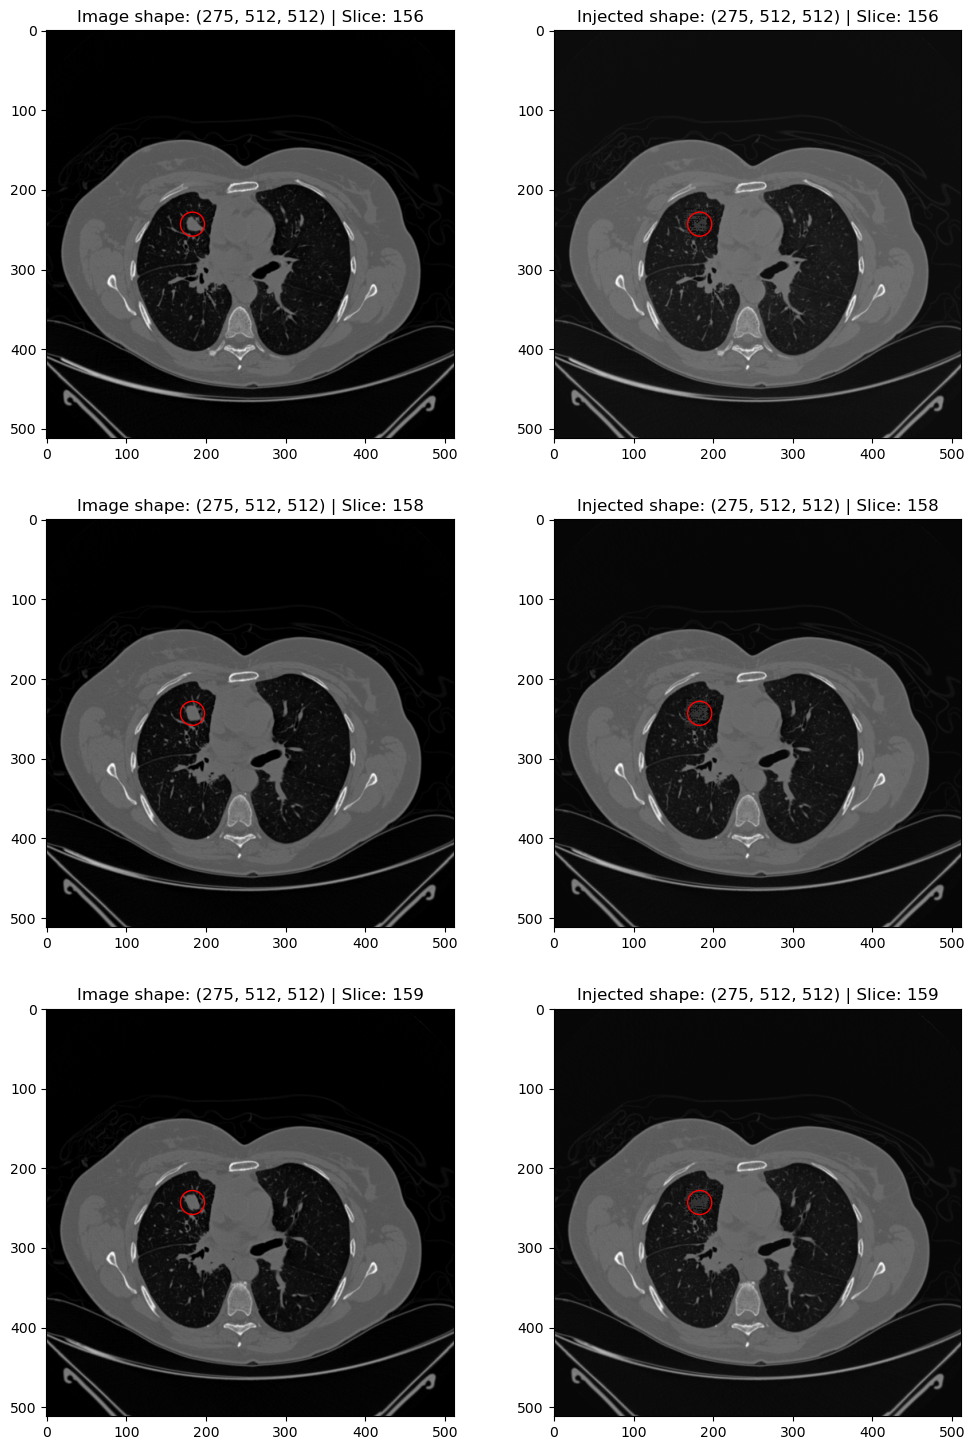

In [31]:
import matplotlib.pyplot as plt
import nibabel as nib
import numpy as np

img_path = '../data/1546.nii.gz'
injected_path = '../data/inference/1.nii.gz'

test_image_nib = nib.load(img_path)
test_injected_nib = nib.load(injected_path)
test_image = np.transpose(test_image_nib.get_fdata(), (2, 1, 0))[:, -1::-1, -1::-1]
test_injected = np.transpose(test_injected_nib.get_fdata(), (2, 1, 0))[:, -1::-1, -1::-1]

locations = [
    [156, 158, 159],
    [183],
    [243],
]
fig, axs = plt.subplots(3, 2, figsize=(12, 18))
for i, z in enumerate(locations[0]):
    axs[i, 0].imshow(test_image[z], cmap='gray')
    axs[i, 0].scatter(locations[1], locations[2], s=300, facecolors='none', edgecolors='r')
    axs[i, 0].set_title(f'Image shape: {test_image.shape} | Slice: {z}')
    axs[i, 1].imshow(test_injected[z], cmap='gray')
    axs[i, 1].scatter(locations[1], locations[2], s=300, facecolors='none', edgecolors='r')
    axs[i, 1].set_title(f'Injected shape: {test_injected.shape} | Slice: {z}')
plt.show()